# Import all the libraries and packages 

In [54]:
import os
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive, EmpiricalMarginal
from pyro.infer.autoguide import init_to_mean, init_to_median, init_to_value
from pyro.infer.inspect import get_dependencies
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

import gempy as gp
import gempy_engine
import gempy_viewer as gpv
from gempy_engine.core.backend_tensor import BackendTensor
import arviz as az
from gempy_probability.plot_posterior import default_red, default_blue, PlotPosterior

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal, norm

# Get the path of all the data

In [55]:

filename_a = './Fw__Hyperspectral_datasets_from_the_KSL_cores/CuSp131.pkl'
filename_b = './Fw__Hyperspectral_datasets_from_the_KSL_cores/CuSp133.pkl'
filename_c = './Fw__Hyperspectral_datasets_from_the_KSL_cores/CuSp136.pkl'

# Load and get the data

In [56]:
with open(filename_a, 'rb') as myfile:
    a= joblib.load(myfile)

# Description about Hyperspectral data
## Data is obtained by scannig the core data from different boreholes using hyperspectral sensors. There were around 450 channels for each pixels initially. It was preprocessed and seperated based on 10 different types of rocks. In each of the file we have "X", "Y", "Z" coordinates points corresponding to sensors and corresponding to each rock type we have a transformed RGB correspondence information. 

(235,)
(234,)


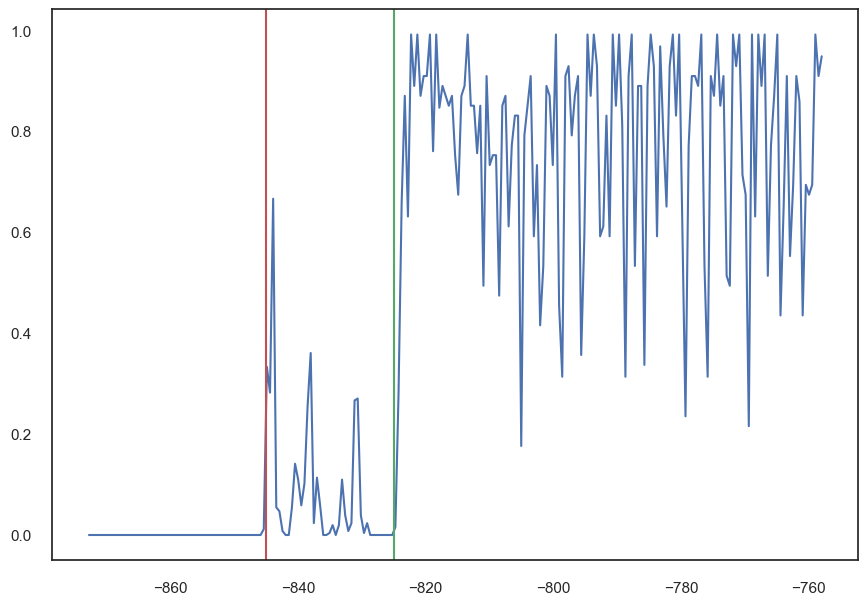

In [57]:
# The variability in "X" and "Y" are much smaller as compared to "Z" direction in case of birehole information. 
# Therefore, we are trying to build our model considering the "Z" direction mostly. 
# get the z-cordinates of borehole
zz = a['XYZ'][:,2]
print(zz.shape)
# sort the z-cordinates
ixx = np.argsort( zz )
# mask if values is less than some specified value
mask = zz[ixx] < -700
ah = a['BR_Anhydrite'][:,0] # correlates to "anhydrite index" derived from hyperspectral 
position_cord , hsi_data = zz[ixx][mask], ah[ixx][mask]/255 # To normalize the hyperspectral spectra, divide it with 255. 
plt.plot( position_cord , hsi_data )
print(position_cord.shape)

# define breakpoints 
# In general it is very difficult to define the breakpoints in the plot. Prepocessing of hyperspectral data is itself a very difficult task
# becasue of high correaltion, high dimensional and noisy data. 
brk1 = -845 
brk2 = -825 

plt.axvline( brk1, color='r' )
plt.axvline( brk2, color='g')

In [58]:
hsi_data.reshape(1,-1)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.01176471, 0.33333333, 0.28235294, 0.66666667,
        0.05490196, 0.04705882, 0.00784314, 0.        , 0.        ,
        0.05490196, 0.14117647, 0.10980392, 0.05882353, 0.10196078,
        0.25490196, 0.36078431, 0.02352941, 0.11

# Since it is difficult to classify a hyperspectral data in general. We can apply different classical clustering methods to have some starting guess

In [59]:

X = np.concatenate(((position_cord.reshape((-1,1))/1000.0), hsi_data.reshape((-1,1))), axis=1)


In [60]:
#gm2 = BayesianGaussianMixture(n_components=3,covariance_type="full", random_state=0).fit(hsi_data.reshape(-1,1))
gm2 = BayesianGaussianMixture(n_components=3,covariance_type="full", random_state=0).fit(X)
gm2.means_ , gm2.covariances_

(array([[-0.79129305,  0.494441  ],
        [-0.84909215,  0.01754853],
        [-0.79521703,  0.87787907]]),
 array([[[0.00063178, 0.00251908],
         [0.00251908, 0.03378569]],
 
        [[0.00022452, 0.00043622],
         [0.00043622, 0.00486684]],
 
        [[0.00039097, 0.00084857],
         [0.00084857, 0.01155452]]]))

In [61]:
loc_mean = torch.tensor(gm2.means_)
loc_cov  = torch.tensor(gm2.covariances_)

In [62]:
correct_order = [0,2,1]
loc_mean, loc_cov = loc_mean[correct_order], loc_cov[correct_order]

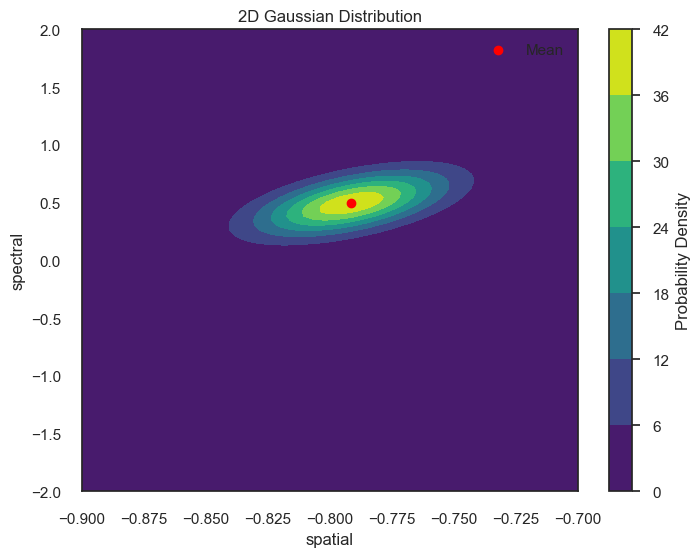

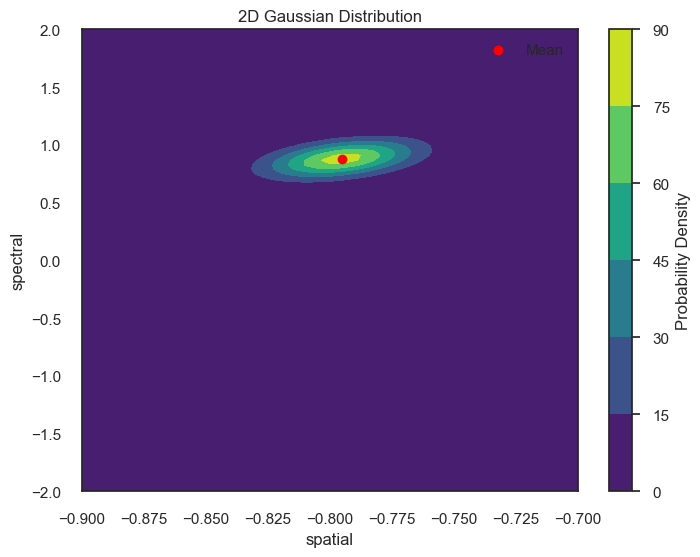

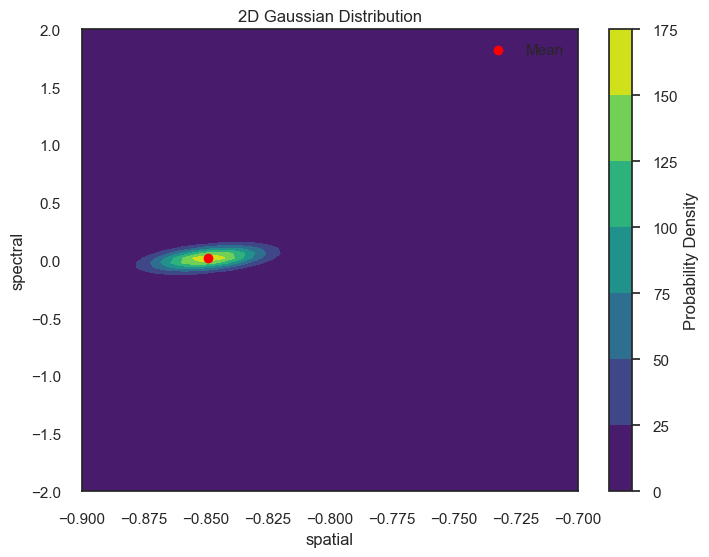

In [63]:
from scipy.stats import multivariate_normal

# Create a grid of points
x, y = np.meshgrid(np.linspace(-0.9, -0.7, 100), np.linspace(-2, 2, 100))
pos = np.dstack((x, y))  # Combine x and y grids into a (100, 100, 2) array
for i in range(3):
    # Create a multivariate normal distribution
    rv = multivariate_normal(loc_mean[i], loc_cov[i])

    # Calculate PDF values for each point in the grid
    pdf_values = rv.pdf(pos)

    # Plot the Gaussian distribution using contour plot
    plt.figure(figsize=(8, 6))
    plt.contourf(x, y, pdf_values, cmap='viridis')
    plt.colorbar(label='Probability Density')
    plt.xlabel('spatial')
    plt.ylabel('spectral')
    plt.title('2D Gaussian Distribution')
    plt.scatter(loc_mean[i][0], loc_mean[i][1], color='red', label='Mean')
    plt.legend()
    plt.grid(True)
plt.show()

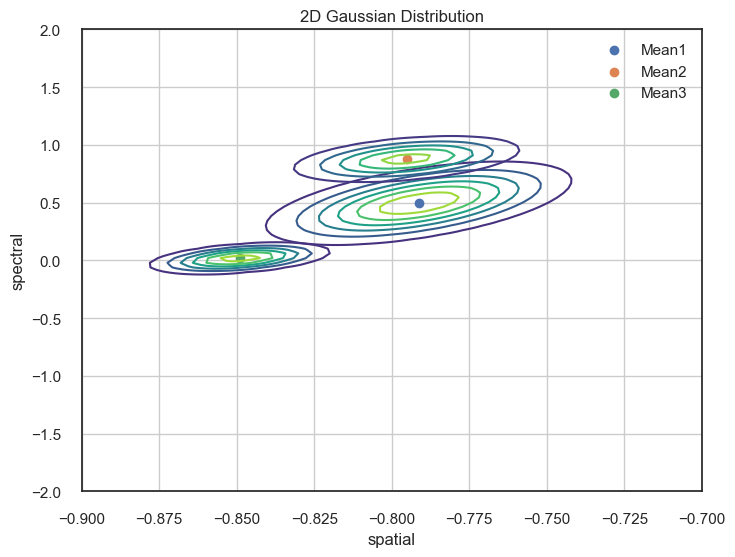

In [64]:
from scipy.stats import multivariate_normal, norm
plt.figure(figsize=(8, 6))
# Create a grid of points
x, y = np.meshgrid(np.linspace(-0.9, -0.7, 100), np.linspace(-2, 2, 100))
pos = np.dstack((x, y))  # Combine x and y grids into a (100, 100, 2) array
for i in range(3):
    # Create a multivariate normal distribution
    rv = multivariate_normal(loc_mean[i], loc_cov[i])

    # Calculate PDF values for each point in the grid
    pdf_values = rv.pdf(pos)

    # Plot the Gaussian distribution using contour plot
    
    plt.contour(x, y, pdf_values, cmap='viridis')
    plt.scatter(loc_mean[i][0], loc_mean[i][1], label='Mean'+str(i+1))
#plt.colorbar(label='Probability Density')
plt.xlabel('spatial')
plt.ylabel('spectral')
plt.title('2D Gaussian Distribution')

plt.legend()
plt.grid(True)
plt.show()

In [65]:
y_gmm_label2 = gm2.predict(X)
print(y_gmm_label2)
y_gmm_label_arranged2 = np.zeros_like(y_gmm_label2)
y_gmm_label_arranged2[y_gmm_label2 == 1] = 3
y_gmm_label_arranged2[y_gmm_label2 == 0] = 2
y_gmm_label_arranged2[y_gmm_label2 == 2] = 1
y_gmm_label_arranged2 = torch.Tensor(y_gmm_label_arranged2)
y_gmm_label_arranged2 

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 1 1 1 1 1 1 1 1 1 1 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 0 2 2 0 2 2 2 0 2 2 2 0 2 0 0 2 2
 2 2 0 0 2 2 2 2 2 0 0 2 2 2 2 0 0 2 0 2 2 2 2 0 2 2 0 2 2 0 2 2 2 0 2 2 0
 2 2 2 2 0 0 2 2 2 2 2 0 0 2 2 2 2 2 0 0 2 2 2 0 0 0 2 0 2 2 2 0 0 2 2 0 0
 2 0 0 2 2 0 0 0 0 2 2 2]


tensor([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 2., 2., 1., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        2., 1., 1., 1., 1., 2., 1., 1., 2., 1., 1., 1., 2., 1., 1., 1., 2., 1.,
        2., 2., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1., 2., 2., 1., 1., 1.,
        1., 2., 2., 1., 2., 1., 1., 1., 1., 2., 1., 1., 2., 1., 1., 2., 1., 1.,
        1., 2., 1., 1., 2., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1., 2., 2.,
        1., 1., 1., 1., 1., 2., 2., 1., 1., 1., 2., 2., 2., 1., 2., 1., 1., 1.,
        2., 2., 1., 1., 2., 2., 1., 2., 

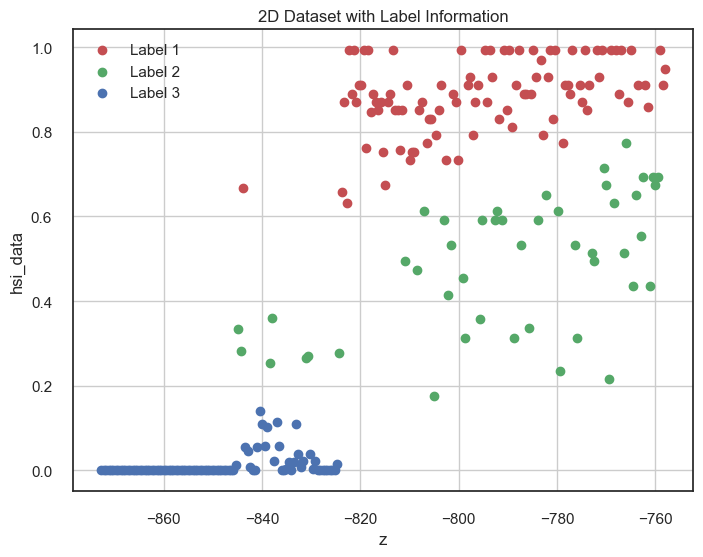

In [66]:
import matplotlib.pyplot as plt
# Define colors for each label
colors = ['r', 'g', 'b']
labels = y_gmm_label_arranged2

# Plot the dataset with different colors for each label
plt.figure(figsize=(8, 6))
for label_val, color in zip([1,2,3], colors):
    plt.scatter(position_cord[labels == label_val], hsi_data[labels == label_val], c=color, label=f'Label {label_val}')

plt.xlabel('z')
plt.ylabel('hsi_data')
plt.title('2D Dataset with Label Information')
plt.legend()
plt.grid(True)
plt.show()

In [67]:
# A = np.zeros_like(a['BR_Anhydrite'][:, 0])
# B = np.zeros_like(a['BR_Anhydrite'][:, 0])
# C = np.zeros_like(a['BR_Anhydrite'][:, 0])

A = np.zeros_like(hsi_data)
B = np.zeros_like(hsi_data)
C = np.zeros_like(hsi_data)

# Get indices where the mask is True
# indices_A = np.where(mask & (zz[ixx] < brk1))
# indices_B = np.where(mask & (zz[ixx] > brk1) & (zz[ixx] < brk2))
# indices_C = np.where(mask & (zz[ixx] > brk2))
shift =0
# Get indices where the mask is True
indices_A = np.where(mask & (zz[ixx] < (brk1+shift)))
indices_B = np.where(mask & (zz[ixx] > (brk1+shift)) & (zz[ixx] < (brk2+shift)))
indices_C = np.where(mask & (zz[ixx] > (brk2+shift)))

y_obs_label = torch.ones(234)
y_obs_label[indices_A] =3
y_obs_label[indices_B] = 2
y_obs_label

tensor([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [68]:
matched_label2 = y_obs_label == y_gmm_label_arranged2
(matched_label2.sum()/len(y_obs_label)) *100

tensor(67.5214)

In [69]:
#y_obs_label = y_gmm_label_arranged
y_obs_label = hsi_data.reshape((-1,1))
y_obs_label2 = X

/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


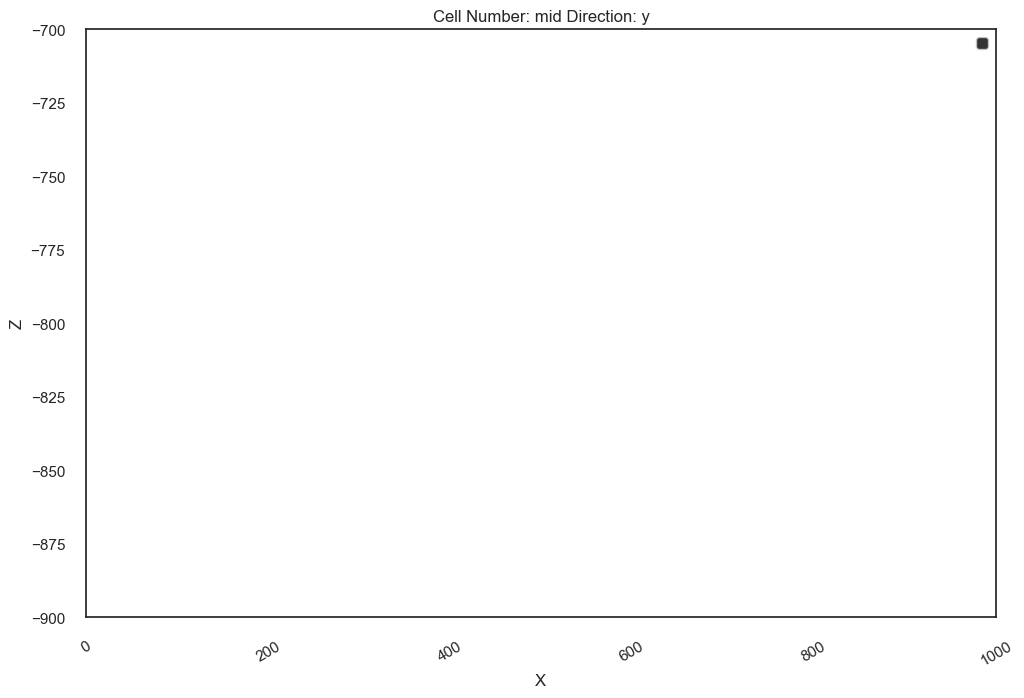

In [70]:
geo_model_test = gp.create_geomodel(
    project_name='Gempy_abc_Test',
    extent=[0, 1000, -500, 500, -900, -700],
    resolution=[100,100,100],
    refinement=3,
    structural_frame= gp.data.StructuralFrame.initialize_default_structure()
    )
p2d = gpv.plot_2d(geo_model_test)

In [71]:
geo_model_test.grid.active_grids_bool

array([False, False, False, False, False])

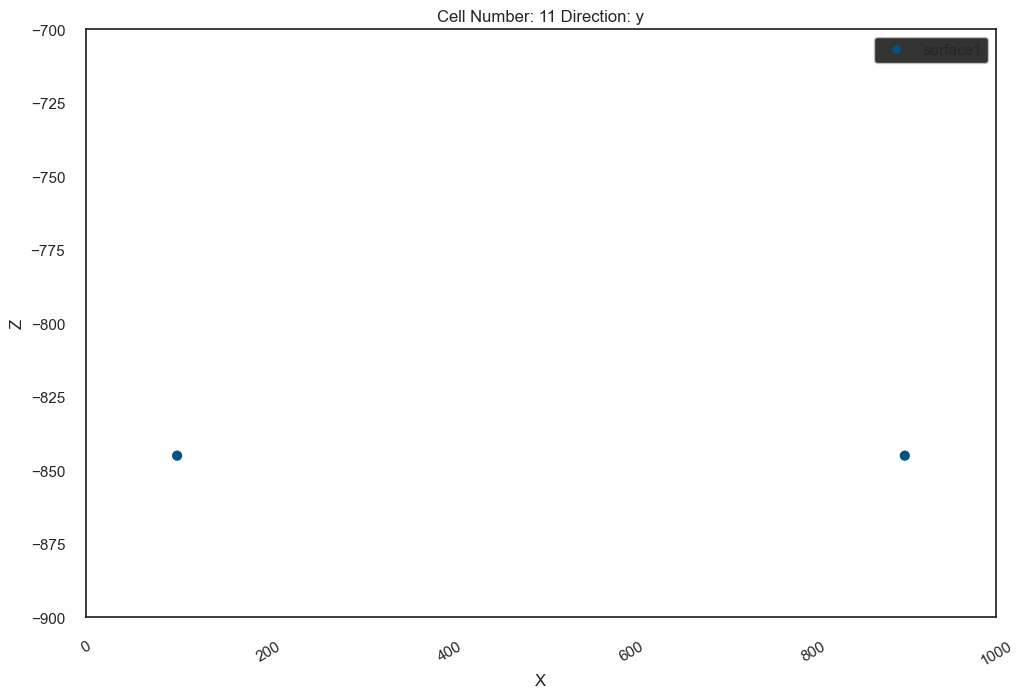

In [72]:
gp.add_surface_points(
    geo_model=geo_model_test,
    x=[100.0, 900.0],
    y=[0.0, 0.0],
    z=[brk1, brk1],
    elements_names=['surface1', 'surface1']
)
gpv.plot_2d(geo_model_test, cell_number=11)

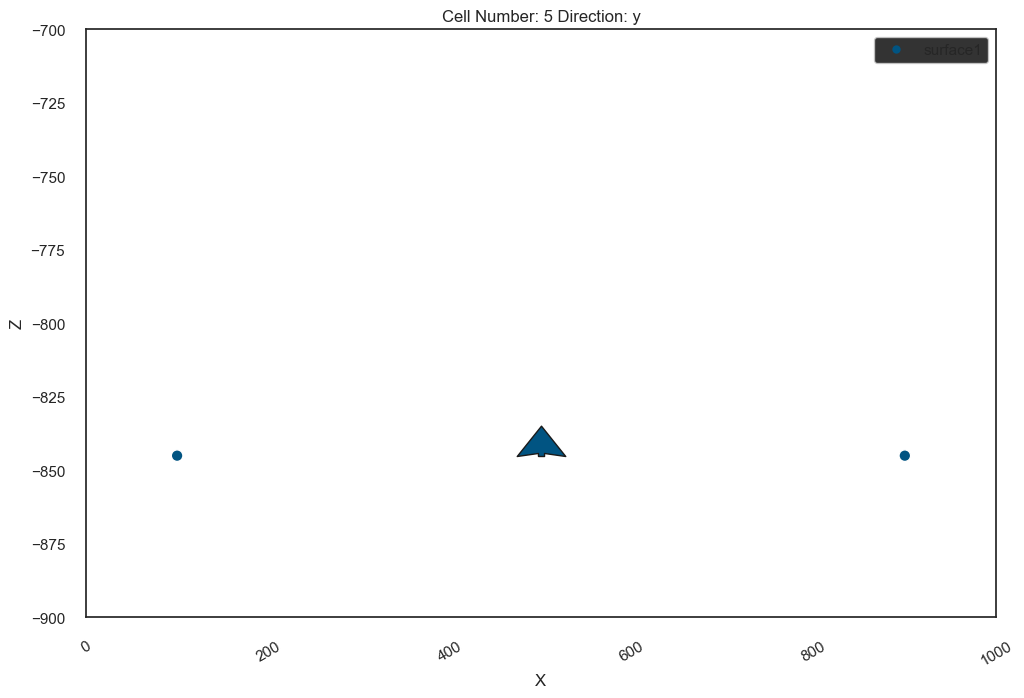

In [73]:
gp.add_orientations(
    geo_model=geo_model_test,
    x=[500],
    y=[0.0],
    z=[brk1],
    elements_names=['surface1'],
    pole_vector=[[0, 0, 1]]
)

gpv.plot_2d(geo_model_test, cell_number=5)

In [74]:
geo_model_test.update_transform(gp.data.GlobalAnisotropy.NONE)

In [75]:
gp.compute_model(geo_model_test, engine_config=gp.data.GemPyEngineConfig())

Setting Backend To: AvailableBackends.numpy


/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(


Solutions(3 Octree Levels, 1 DualContouringMeshes)

In [76]:
geo_model_test.interpolation_options.kernel_options

KernelOptions(range=5, c_o=10, uni_degree=1, i_res=4, gi_res=2, number_dimensions=3, kernel_function=AvailableKernelFunctions.cubic, compute_condition_number=False, kernel_solver=Solvers.DEFAULT)

/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


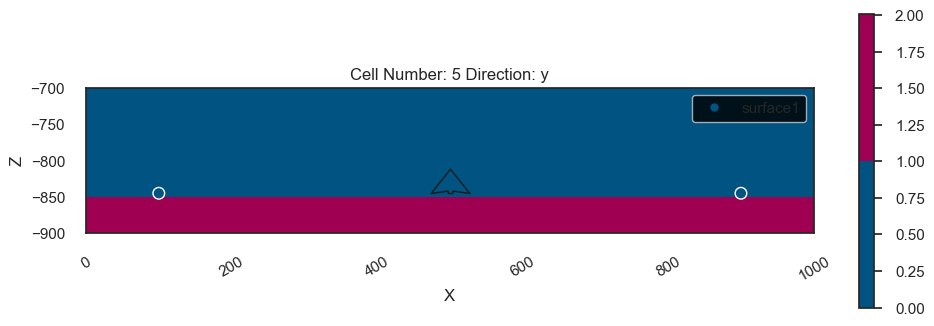

In [77]:
gpv.plot_2d(geo_model_test, cell_number=[5])

In [78]:
geo_model_test.structural_frame

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=default_formations,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=surface1,
	color=#015482,
	is_active=True
)
]
)
],
	fault_relations=
[[False]],

Setting Backend To: AvailableBackends.numpy


/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


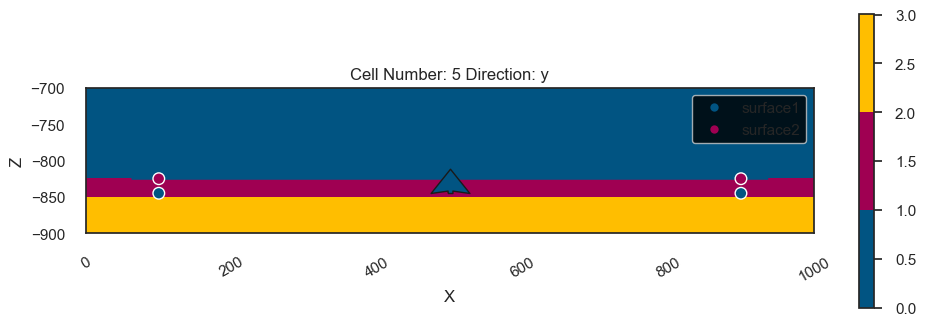

In [79]:
element2 = gp.data.StructuralElement(
    name='surface2',
    color=next(geo_model_test.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([100.0, 900.0]),
        y=np.array([0.0, 0.0]),
        z=np.array([brk2, brk2]),
        names='surface2'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test.structural_frame.structural_groups[0].append_element(element2)
# Compute and visualize the updated model:
gp.compute_model(geo_model_test)
gpv.plot_2d(geo_model_test, cell_number=5, legend='force')
    

In [80]:
#gpv.plot_3d(geo_model_test, image=True)

In [81]:
geo_model_test.structural_frame

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=default_formations,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=surface1,
	color=#015482,
	is_active=True
),
Element(
	name=surface2,
	color=#9f0052,
	is_active=True
)
]
)
],
	fault_relations=
[[False]],

In [82]:
geo_model_test.structural_frame.structural_groups[0].elements[0], geo_model_test.structural_frame.structural_groups[0].elements[1] = \
geo_model_test.structural_frame.structural_groups[0].elements[1], geo_model_test.structural_frame.structural_groups[0].elements[0]

In [83]:
geo_model_test.structural_frame

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=default_formations,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=surface2,
	color=#9f0052,
	is_active=True
),
Element(
	name=surface1,
	color=#015482,
	is_active=True
)
]
)
],
	fault_relations=
[[False]],

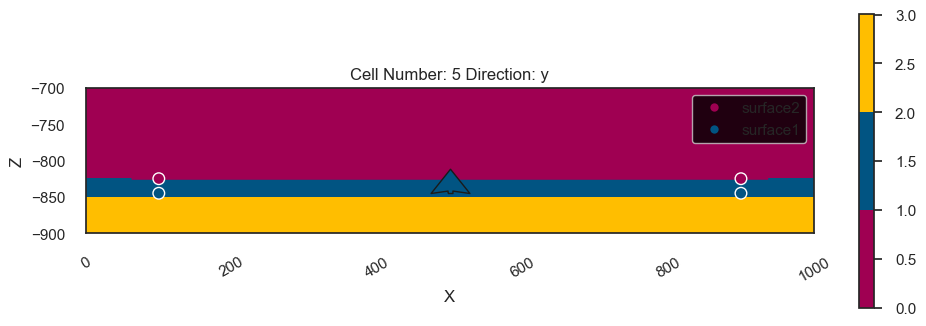

In [84]:
gpv.plot_2d(geo_model_test, cell_number=5, legend='force')

# Create a custome grid where the observed data information is available 

In [85]:
x_loc = 300
y_loc = 0
z_loc = position_cord
xyz_coord = np.array([[x_loc, y_loc, z] for z in z_loc])
gp.set_custom_grid(geo_model_test.grid, xyz_coord=xyz_coord)

Active grids: ['custom']


In [86]:
sp_coords_copy_test = geo_model_test.interpolation_input.surface_points.sp_coords.copy()
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

array([[ 100.,    0., -825.],
       [ 900.,    0., -825.],
       [ 100.,    0., -845.],
       [ 900.,    0., -845.]])

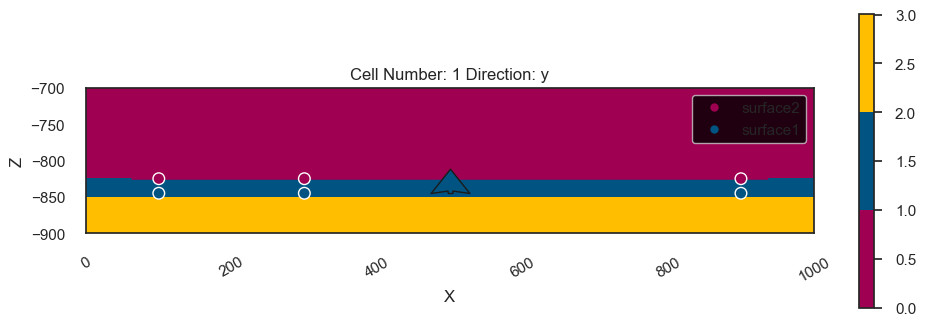

In [87]:
gp.add_surface_points(
    geo_model=geo_model_test,
    x=[x_loc, x_loc],
    y=[0.0, 0.0],
    z=[brk1, brk2],
    elements_names=['surface1', 'surface2']
)
gpv.plot_2d(geo_model_test, cell_number=1)

In [88]:
geo_model_test.surface_points

X,Y,Z,id,nugget
100.00,0.00,-825.00,69872879,0.00
900.00,0.00,-825.00,69872879,0.00
300.00,0.00,-825.00,69872879,0.00
100.00,0.00,-845.00,8002659,0.00
900.00,0.00,-845.00,8002659,0.00
300.00,0.00,-845.00,8002659,0.00


Setting Backend To: AvailableBackends.numpy


/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


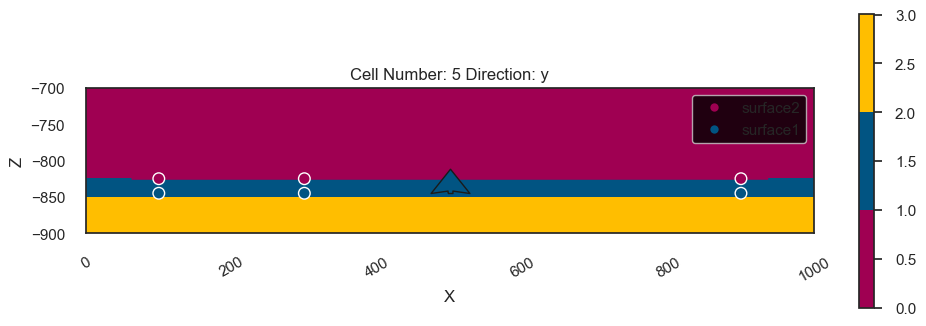

In [89]:
gp.compute_model(geo_model_test)
gpv.plot_2d(geo_model_test, cell_number=5, legend='force')

In [90]:
sp_coords_copy_test = geo_model_test.interpolation_input.surface_points.sp_coords.copy()
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

array([[ 100.,    0., -825.],
       [ 900.,    0., -825.],
       [ 300.,    0., -825.],
       [ 100.,    0., -845.],
       [ 900.,    0., -845.],
       [ 300.,    0., -845.]])

In [91]:
# Change the backend to PyTorch for probabilistic modeling
BackendTensor.change_backend_gempy(engine_backend=gp.data.AvailableBackends.PYTORCH)
# Set random seed for PyTorch backend
torch.manual_seed(42)

Setting Backend To: AvailableBackends.PYTORCH


In [92]:
geo_model_test.interpolation_options.uni_degree = 0
geo_model_test.interpolation_options.mesh_extraction = False
geo_model_test.interpolation_options.sigmoid_slope = 1100.

In [93]:
#geo_model_test.solutions.octrees_output[0].last_output_center

In [94]:
custom_grid_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
custom_grid_values.shape

(234,)

In [95]:
y_obs_label.shape, y_obs_label2.shape

((234, 1), (234, 2))

In [96]:
geo_model_test.surface_points

X,Y,Z,id,nugget
100.00,0.00,-825.00,69872879,0.00
900.00,0.00,-825.00,69872879,0.00
300.00,0.00,-825.00,69872879,0.00
100.00,0.00,-845.00,8002659,0.00
900.00,0.00,-845.00,8002659,0.00
300.00,0.00,-845.00,8002659,0.00


In [97]:
geo_model_test.orientations

X,Y,Z,G_x,G_y,G_z,id,nugget
500.00,0.00,-845.00,0.00,0.00,1.00,8002659,0.01


In [98]:
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

array([[ 100.,    0., -825.],
       [ 900.,    0., -825.],
       [ 300.,    0., -825.],
       [ 100.,    0., -845.],
       [ 900.,    0., -845.],
       [ 300.,    0., -845.]])

Condition number: 45563.51606342727.
Condition number: 45563.51606342727.


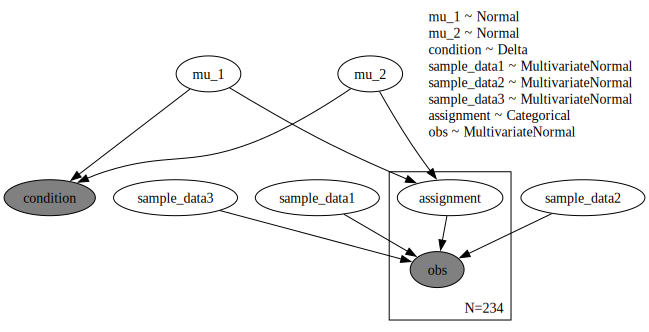

In [100]:

# Set random seed for Pyro
pyro.set_rng_seed(42)

@config_enumerate
def model_test(y_obs_label):
    """
    This Pyro model represents the probabilistic aspects of the geological model.
    It defines a prior distribution for the top layer's location and
    computes the thickness of the geological layer as an observed variable.
    """
    # Define prior for the top layer's location
    prior_mean_surface_1 = sp_coords_copy_test[2, 2]
    prior_mean_surface_2 = sp_coords_copy_test[5, 2]
    
    

    
    mu_surface_1 = pyro.sample('mu_1', dist.Normal(prior_mean_surface_1, torch.tensor(0.02, dtype=torch.float64)))
    mu_surface_2 = pyro.sample('mu_2', dist.Normal(prior_mean_surface_2, torch.tensor(0.02, dtype=torch.float64)))
    
    # Ensure that mu_surface_1 is greater than mu_surface_2
    pyro.sample('condition', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_1 > mu_surface_2))
    # Update the model with the new top layer's location
    interpolation_input = geo_model_test.interpolation_input
    
    
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([2]), torch.tensor([2])),
        mu_surface_1
    )
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([5]), torch.tensor([2])),
        mu_surface_2
    )
    

    
    
    # # Compute the geological model
    geo_model_test.solutions = gempy_engine.compute_model(
        interpolation_input=interpolation_input,
        options=geo_model_test.interpolation_options,
        data_descriptor=geo_model_test.input_data_descriptor,
        geophysics_input=geo_model_test.geophysics_input,
    )
    
    # Compute and observe the thickness of the geological layer
    
    custom_grid_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
    
    lambda_ = 4
    class_label = F.softmax(- lambda_ * (torch.tensor([1,2,3], dtype=torch.float64) - custom_grid_values.reshape(-1,1))**2, dim=1)
    
    sample =[]
    for i in range(loc_mean.shape[0]):
        sample_data = pyro.sample("sample_data"+str(i+1), dist.MultivariateNormal(loc=loc_mean[i],covariance_matrix=loc_cov[i]))
        sample.append(sample_data)
    sample_tesnor = torch.stack(sample, dim=0)
    
    
    with pyro.plate('N='+str(y_obs_label.shape[0]), y_obs_label.shape[0]):
        assignment = pyro.sample("assignment", dist.Categorical(class_label))
        
        obs = pyro.sample("obs", dist.MultivariateNormal(loc=sample_tesnor[assignment],covariance_matrix=loc_cov[assignment]), obs=y_obs_label)
        
    return obs
    
dependencies = get_dependencies(model_test, model_args=(torch.tensor(X),))
pyro.render_model(model_test, model_args=(torch.tensor(X),),render_distributions=True)


In [101]:
y_obs_label =torch.tensor(X)

In [102]:

model_test(y_obs_label)

Condition number: 45563.51606342729.


tensor([[-0.8727,  0.0000],
        [-0.8722,  0.0000],
        [-0.8717,  0.0000],
        [-0.8713,  0.0000],
        [-0.8708,  0.0000],
        [-0.8703,  0.0000],
        [-0.8698,  0.0000],
        [-0.8693,  0.0000],
        [-0.8688,  0.0000],
        [-0.8683,  0.0000],
        [-0.8678,  0.0000],
        [-0.8674,  0.0000],
        [-0.8669,  0.0000],
        [-0.8664,  0.0000],
        [-0.8659,  0.0000],
        [-0.8654,  0.0000],
        [-0.8649,  0.0000],
        [-0.8644,  0.0000],
        [-0.8639,  0.0000],
        [-0.8635,  0.0000],
        [-0.8630,  0.0000],
        [-0.8625,  0.0000],
        [-0.8620,  0.0000],
        [-0.8615,  0.0000],
        [-0.8610,  0.0000],
        [-0.8605,  0.0000],
        [-0.8600,  0.0000],
        [-0.8595,  0.0000],
        [-0.8591,  0.0000],
        [-0.8586,  0.0000],
        [-0.8581,  0.0000],
        [-0.8576,  0.0000],
        [-0.8571,  0.0000],
        [-0.8566,  0.0000],
        [-0.8561,  0.0000],
        [-0.8556,  0

Condition number: 21514.2085370576.
Condition number: 28227.572368273126.
Condition number: 28230.78205018406.
Condition number: 21195.12963309508.
Condition number: 34175.83480903274.
Condition number: 21876.687283694926.
Condition number: 47612.659309017734.
Condition number: 30837.653122028547.
Condition number: 48949.39776218426.
Condition number: 21416.838675175943.
Condition number: 21564.459642793696.
Condition number: 43102.706848165784.
Condition number: 43104.46360295912.
Condition number: 42824.04246076933.
Condition number: 28904.088672253376.
Condition number: 37682.912488879054.
Condition number: 33280.575326761216.
Condition number: 21223.918916987124.
Condition number: 26523.443454512624.
Condition number: 21821.93448203231.
Condition number: 27380.567492605252.
Condition number: 21294.770693669558.
Condition number: 21309.128961863382.
Condition number: 22291.182143054742.
Condition number: 33907.802196160344.
Condition number: 46185.66763617107.
Condition number: 2208

/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


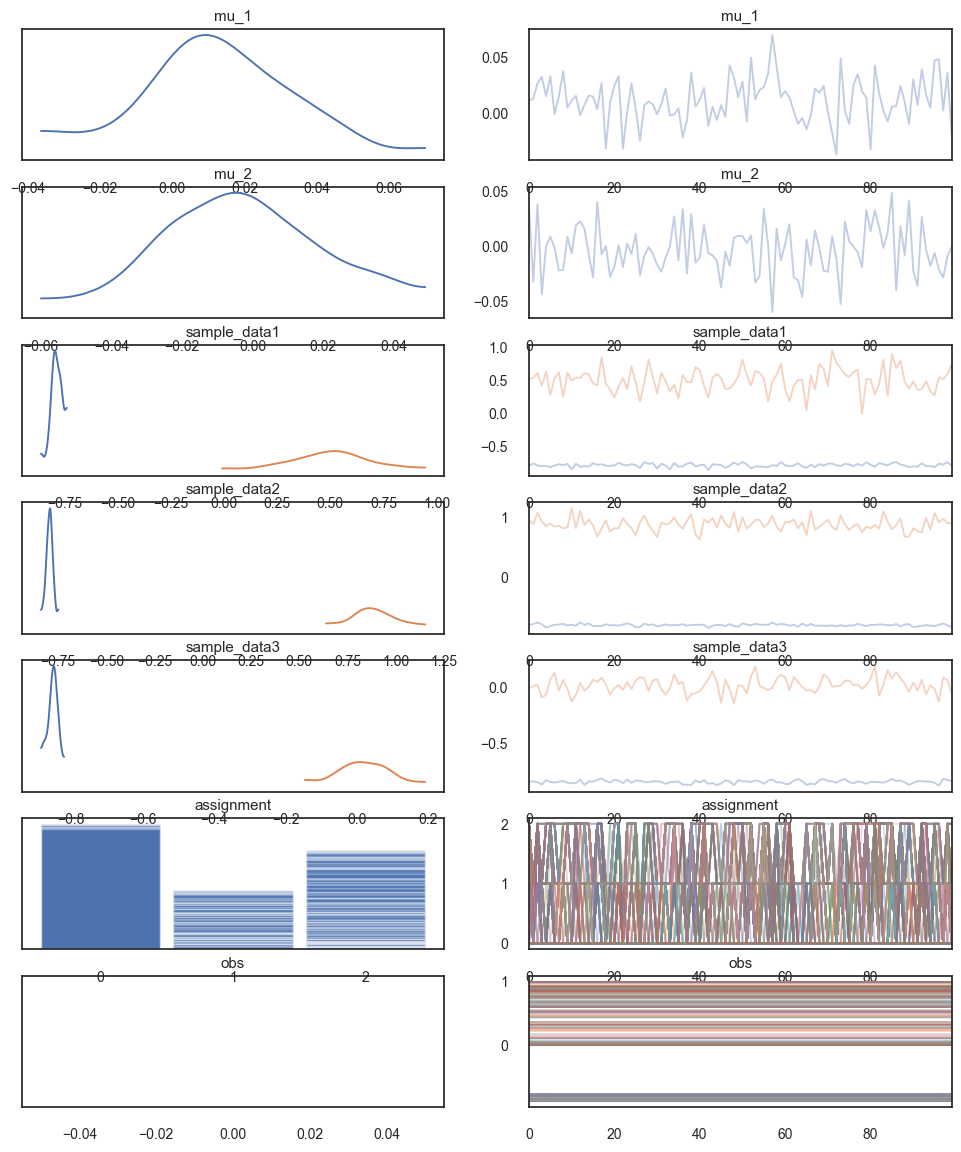

In [103]:
prior = Predictive(model_test, num_samples=100)(y_obs_label)

# Key to avoid
avoid_key = 'condition'

# Create sub-dictionary without the avoid_key
prior = dict((key, value) for key, value in prior.items() if key != avoid_key)

data = az.from_pyro(prior=prior)
az.plot_trace(data.prior)
plt.show()

In [104]:
pyro.primitives.enable_validation(is_validate=True)
nuts_kernel = NUTS(model_test, step_size=0.0085, adapt_step_size=True, target_accept_prob=0.9, max_tree_depth=10, init_strategy=init_to_mean)
mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=50, disable_validation=False)
mcmc.run(y_obs_label)

Warmup:   0%|          | 0/250 [00:00, ?it/s]

Condition number: 53452.74010717873.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 21135.17566992755.
Condition number: 52007.3427657542.
Condition number: 37104.84410674049.
Condition number: 52007.3427657542.
Condition number: 53124.27493106241.
Condition number: 52007.3427657542.
Condition number: 54084.803278844935.
Condition number: 52007.3427657542.
Condition number: 52140.17923261866.
Condition number: 52007.3427657542.
Condition number: 51598.96925034696.
Condition number: 51782.45475030826.
Condition number: 52399.75287092372.
Condition number: 52955.975565685476.
Condition number: 51709.18119234299.
Condition number: 51845.45990059657.
Condition number: 52153.44042430554.


Warmup:   1%|          | 2/250 [00:01,  2.08it/s, step size=2.43e-03, acc. prob=0.882]

Condition number: 52455.78317717336.
Condition number: 38695.526451579.
Condition number: 53146.90626066436.
Condition number: 20741.45547654337.
Condition number: 21511.628487044953.
Condition number: 21567.26869141723.


Warmup:   1%|          | 3/250 [00:01,  3.22it/s, step size=2.19e-04, acc. prob=0.588]

Condition number: 29296.775777625888.
Condition number: 20735.740747843927.
Condition number: 20739.173202872415.
Condition number: 20754.221705762146.
Condition number: 20781.83400464639.
Condition number: 20819.2621960936.
Condition number: 20860.72979702227.
Condition number: 20900.524595870582.
Condition number: 20754.91866212094.
Condition number: 20776.15079720368.
Condition number: 20804.45531112194.
Condition number: 20836.620481685448.
Condition number: 20868.1739831487.
Condition number: 20895.677164111246.
Condition number: 20916.436814988487.
Condition number: 20928.565501562764.
Condition number: 20934.723484518592.
Condition number: 20960.579124429212.
Condition number: 20976.377478212795.
Condition number: 20981.329365270612.
Condition number: 20975.450004739032.
Condition number: 20959.567714225934.
Condition number: 20935.39513793228.
Condition number: 20905.86982652171.
Condition number: 20876.003698043165.
Condition number: 20852.130088699756.
Condition number: 20839

Warmup:   2%|▏         | 4/250 [00:02,  1.80it/s, step size=2.42e-04, acc. prob=0.690]

Condition number: 20861.263806663264.
Condition number: 20894.091548564797.
Condition number: 20936.747926781863.
Condition number: 20982.67649845523.
Condition number: 20847.20189049787.
Condition number: 20871.570076196065.
Condition number: 20908.12903272537.
Condition number: 20949.52065683526.
Condition number: 20988.0941650338.
Condition number: 21018.35391937914.
Condition number: 21037.10892777599.
Condition number: 20851.032385454666.
Condition number: 20878.88444882428.
Condition number: 20918.23567516658.
Condition number: 20961.50996016209.
Condition number: 21001.102990689677.
Condition number: 21031.68246382177.
Condition number: 21050.178400281035.
Condition number: 21055.026624728.
Condition number: 21045.949272299087.
Condition number: 21023.944558343537.
Condition number: 20991.448710030167.
Condition number: 20952.904085730283.
Condition number: 20915.37783838131.
Condition number: 20886.986609189415.
Condition number: 20874.08335909318.
Condition number: 20879.65081

Warmup:   2%|▏         | 5/250 [00:04,  1.29s/it, step size=2.86e-04, acc. prob=0.750]

Condition number: 20920.842039344014.
Condition number: 20899.905357195144.
Condition number: 20898.149290790887.
Condition number: 20916.42271728508.
Condition number: 20950.653285380187.
Condition number: 20935.989773170986.
Condition number: 20953.515693769605.
Condition number: 20970.072212032974.
Condition number: 20941.547207784948.
Condition number: 20954.89615266373.
Condition number: 20970.719237034526.
Condition number: 20982.89000703875.
Condition number: 20987.00506244141.
Condition number: 20981.91316044471.
Condition number: 20969.996196060176.
Condition number: 20956.377113782128.
Condition number: 20946.982303759854.
Condition number: 20946.106466934893.
Condition number: 20954.73259246336.
Condition number: 20970.221873008417.
Condition number: 20984.01009153694.
Condition number: 20990.46651340594.
Condition number: 20987.61252130441.
Condition number: 20977.09667755056.
Condition number: 20963.47860589226.
Condition number: 20952.59918625917.
Condition number: 20949.

Warmup:   2%|▏         | 6/250 [00:09,  2.32s/it, step size=3.54e-04, acc. prob=0.790]

Condition number: 20963.399031515433.
Condition number: 20952.09966631187.
Condition number: 20948.409072638566.
Condition number: 20954.205624072736.
Condition number: 20967.70315469435.
Condition number: 20962.79491622164.
Condition number: 20969.03899083263.
Condition number: 20973.091763648525.
Condition number: 20955.93078848669.
Condition number: 20958.75432728846.
Condition number: 20964.181131251305.
Condition number: 20969.077816226494.
Condition number: 20973.297381374316.
Condition number: 20970.41096842584.
Condition number: 20967.097468433392.
Condition number: 20966.29222389216.
Condition number: 20969.38896229777.
Condition number: 20975.40122439096.
Condition number: 20981.587369869885.
Condition number: 20985.057960099246.
Condition number: 20970.89443934239.
Condition number: 20969.14394132521.
Condition number: 20965.630743848633.
Condition number: 20963.357317678703.
Condition number: 20964.703211242868.
Condition number: 20969.972922724228.
Condition number: 20977.

Warmup:   3%|▎         | 7/250 [00:14,  3.49s/it, step size=4.67e-04, acc. prob=0.820]

Condition number: 20986.689831016694.
Condition number: 20983.435375508663.
Condition number: 20977.16476257591.
Condition number: 20969.82147126342.
Condition number: 20963.780521483066.
Condition number: 20960.414357529735.
Condition number: 21020.22340446008.
Condition number: 21019.775185809864.
Condition number: 20992.571461744184.
Condition number: 20957.784820241424.
Condition number: 20941.705456270513.
Condition number: 20955.188711731298.
Condition number: 20984.571458850936.
Condition number: 21004.95990274791.
Condition number: 21000.485182831133.
Condition number: 20971.709887145746.
Condition number: 20935.444021333253.
Condition number: 20916.326359790673.
Condition number: 20927.20183515349.
Condition number: 20958.25418577443.
Condition number: 20985.568439251678.
Condition number: 20990.595117636323.
Condition number: 20970.1790515968.
Condition number: 20937.311904285165.
Condition number: 20915.83133381771.
Condition number: 20923.007067447314.
Condition number: 209

Warmup:   3%|▎         | 8/250 [00:18,  3.35s/it, step size=3.45e-04, acc. prob=0.819]

Condition number: 20995.569622059324.
Condition number: 20973.343042770775.
Condition number: 20982.058654582735.
Condition number: 20983.9985590007.
Condition number: 20983.415742419544.
Condition number: 20981.138726031648.
Condition number: 20978.791932315427.
Condition number: 20977.96658200122.
Condition number: 20969.90825464058.
Condition number: 20968.931198701986.
Condition number: 20970.347899638247.
Condition number: 20972.841362965948.
Condition number: 20974.58359187908.
Condition number: 20974.254262799845.
Condition number: 20971.768363882777.
Condition number: 20968.337510607296.
Condition number: 20965.826947888134.
Condition number: 20965.72568607294.
Condition number: 20968.3011163121.
Condition number: 20972.439365063306.
Condition number: 20976.267386802578.
Condition number: 20978.180327980852.
Condition number: 20977.68272229565.
Condition number: 20975.61569713864.
Condition number: 20973.681521984796.
Condition number: 20973.505736857132.
Condition number: 2097

Warmup:   4%|▎         | 9/250 [00:22,  3.71s/it, step size=4.65e-04, acc. prob=0.839]

Condition number: 20976.001735294132.
Condition number: 20979.371108016563.
Condition number: 20981.445297911654.
Condition number: 20978.274820489143.
Condition number: 20976.596680277333.
Condition number: 20978.451664364795.
Condition number: 20976.825570019802.
Condition number: 20972.54014605191.
Condition number: 20967.837601374336.
Condition number: 20965.788388365338.
Condition number: 20967.10092145813.
Condition number: 20969.407640921338.
Condition number: 20969.721655625188.
Condition number: 20967.548802837333.


Warmup:   4%|▍         | 10/250 [00:23,  2.73s/it, step size=6.27e-04, acc. prob=0.854]

Condition number: 20965.422047120755.
Condition number: 20966.274703248106.
Condition number: 20970.34897561084.
Condition number: 20974.89649930497.
Condition number: 20990.02438293499.
Condition number: 20972.13947382649.
Condition number: 20943.962741099687.
Condition number: 20958.92674602934.
Condition number: 20989.405772463408.
Condition number: 20980.751915896486.
Condition number: 20952.155935340128.
Condition number: 20947.74655435526.
Condition number: 20972.46925287635.
Condition number: 20999.42954107232.
Condition number: 20986.467521256935.
Condition number: 20957.991051198936.
Condition number: 20963.42433935955.
Condition number: 20995.463517674478.


Warmup:   4%|▍         | 11/250 [00:23,  2.05s/it, step size=4.04e-04, acc. prob=0.846]

Condition number: 21006.354809519296.
Condition number: 20979.99035718527.
Condition number: 21002.20670987812.
Condition number: 20986.058603715217.
Condition number: 20957.566408298375.
Condition number: 20948.434403500858.
Condition number: 20959.40268980584.
Condition number: 20983.103095080598.
Condition number: 21003.75511238937.
Condition number: 21008.82919135796.
Condition number: 20995.920233636734.
Condition number: 20973.183254002666.
Condition number: 20955.534448372586.
Condition number: 20955.184574707488.
Condition number: 20972.887452916395.
Condition number: 20997.522700536374.
Condition number: 21014.40036973225.
Condition number: 21014.765374139915.
Condition number: 20999.02729123312.
Condition number: 20976.460584188826.
Condition number: 20961.577617837585.
Condition number: 20964.636272411608.
Condition number: 20983.58749918376.
Condition number: 21005.345382519175.
Condition number: 21015.628070116356.
Condition number: 21007.74626180063.
Condition number: 209

Warmup:   5%|▍         | 12/250 [00:27,  2.64s/it, step size=5.25e-04, acc. prob=0.857]

Condition number: 20947.819746045432.
Condition number: 20948.60126265945.
Condition number: 20966.85492299198.
Condition number: 21019.069188537156.
Condition number: 21000.672336494335.
Condition number: 20967.24163492715.
Condition number: 20973.77873261822.
Condition number: 20955.703681416264.
Condition number: 20972.32121234002.
Condition number: 21005.17027783409.
Condition number: 21018.3497206575.
Condition number: 20997.526322455287.
Condition number: 20962.513356503157.
Condition number: 20952.33988825905.
Condition number: 20976.28079360159.
Condition number: 20999.572390981797.
Condition number: 20989.938791615365.
Condition number: 20955.40382081713.
Condition number: 20952.79956584781.
Condition number: 20973.00253158707.
Condition number: 21005.86051078078.
Condition number: 21017.623018558636.
Condition number: 20997.18372371395.
Condition number: 20964.3792687538.
Condition number: 20955.480966614527.
Condition number: 20980.2674672226.
Condition number: 21007.6444325

Warmup:   5%|▌         | 13/250 [00:28,  2.27s/it, step size=5.42e-04, acc. prob=0.861]

Condition number: 20969.093857065112.
Condition number: 20952.12212951234.
Condition number: 20971.41103712947.
Condition number: 21004.97575958616.
Condition number: 21015.845530723545.
Condition number: 20993.912144918097.
Condition number: 20972.82723633095.
Condition number: 20974.20506493079.
Condition number: 21004.717202865802.
Condition number: 21004.27727302152.
Condition number: 21012.83228343174.
Condition number: 20989.13089716596.
Condition number: 20958.00902595571.
Condition number: 20955.132924100806.
Condition number: 20983.711519815897.
Condition number: 21010.976197879703.
Condition number: 21008.76335680046.
Condition number: 20979.874250382123.
Condition number: 20956.015825258757.
Condition number: 20965.998886699286.
Condition number: 20998.74945820212.
Condition number: 21008.905938546508.
Condition number: 20981.06843206964.
Condition number: 20953.82826182318.
Condition number: 20961.450707576674.
Condition number: 20990.16778340418.
Condition number: 20998.60

Warmup:   6%|▌         | 14/250 [00:37,  4.07s/it, step size=7.40e-04, acc. prob=0.871]

Condition number: 20930.83688620986.
Condition number: 20940.22734071899.
Condition number: 20920.548036713717.
Condition number: 20899.879954195017.
Condition number: 20910.055255794352.
Condition number: 20941.20314178699.
Condition number: 20980.792560843638.
Condition number: 20944.91843937389.
Condition number: 20957.152765408682.
Condition number: 20988.359927232825.
Condition number: 20959.237335935046.
Condition number: 20943.433438885546.
Condition number: 20985.043505527625.
Condition number: 20981.54654897302.
Condition number: 20943.06842640749.
Condition number: 20968.524339703836.
Condition number: 20990.396399153142.
Condition number: 20954.862783545123.
Condition number: 20944.97804221084.
Condition number: 20982.428927830835.
Condition number: 20969.321259810156.
Condition number: 20933.685123570358.
Condition number: 20965.62183137725.
Condition number: 20983.868628629163.
Condition number: 20946.948624030956.
Condition number: 20953.231762162828.
Condition number: 20

Warmup:   6%|▌         | 15/250 [00:40,  3.87s/it, step size=6.47e-04, acc. prob=0.870]

Condition number: 20954.71092911853.
Condition number: 20932.47414012406.
Condition number: 20876.576610849675.
Condition number: 20907.26205844164.
Condition number: 20979.200844939598.
Condition number: 20971.333310798138.
Condition number: 20919.78407776819.
Condition number: 20878.747359868543.
Condition number: 20929.76747758993.
Condition number: 20976.138058378987.
Condition number: 20941.417373256518.
Condition number: 20885.856982728925.
Condition number: 20925.363294128307.
Condition number: 20986.15063667352.
Condition number: 20965.25778243738.
Condition number: 20893.669844807275.
Condition number: 20914.705051906647.
Condition number: 20989.80271441888.
Condition number: 20983.887261921966.
Condition number: 20904.30705951805.
Condition number: 20899.4871702508.
Condition number: 20978.87374163094.
Condition number: 20993.604631017937.
Condition number: 20922.512100287102.
Condition number: 20893.90289184684.
Condition number: 20964.680616826605.
Condition number: 21004.9

Warmup:   6%|▋         | 16/250 [00:41,  3.08s/it, step size=7.84e-05, acc. prob=0.828]

Condition number: 20994.54019566128.
Condition number: 20966.187722890314.
Condition number: 20967.20360305258.
Condition number: 20967.70138337484.
Condition number: 20967.66815122232.
Condition number: 20967.105215486292.
Condition number: 20966.028122824537.
Condition number: 20964.466424025748.
Condition number: 20962.722594909264.
Condition number: 20960.36658260036.
Condition number: 20957.676966993302.
Condition number: 20954.728083829024.
Condition number: 20951.60234295835.
Condition number: 20948.38802087219.
Condition number: 20945.17678117653.
Condition number: 20942.06101247397.
Condition number: 20939.131090041497.
Condition number: 20936.47267395865.
Condition number: 20934.164153400543.
Condition number: 20932.27432820722.
Condition number: 20930.860406719097.
Condition number: 20929.96636998711.
Condition number: 20929.621738381848.
Condition number: 20929.840756889822.
Condition number: 20930.622009818737.
Condition number: 20931.94846672448.
Condition number: 20933.7

Warmup:   7%|▋         | 17/250 [00:46,  3.50s/it, step size=1.09e-04, acc. prob=0.838]

Condition number: 20960.606250688117.
Condition number: 20958.800266761773.
Condition number: 20942.684689192087.
Condition number: 20943.758700066108.
Condition number: 20945.132091406664.
Condition number: 20946.720590090725.
Condition number: 20948.428612846605.
Condition number: 20950.154718523274.
Condition number: 20951.79735811718.
Condition number: 20941.68738503531.
Condition number: 20941.83762127421.
Condition number: 20942.430160137083.
Condition number: 20943.442082053938.
Condition number: 20944.827680433802.
Condition number: 20946.521149794262.
Condition number: 20948.4404215488.
Condition number: 20950.491905941326.
Condition number: 20952.57583898451.
Condition number: 20954.591889945226.
Condition number: 20956.44467917375.
Condition number: 20958.048880105056.
Condition number: 20959.33363747402.
Condition number: 20960.246105669194.
Condition number: 20960.753985258143.
Condition number: 20960.84699733969.
Condition number: 20960.537281116114.
Condition number: 209

Warmup:   7%|▋         | 18/250 [01:03,  7.66s/it, step size=1.51e-04, acc. prob=0.847]

Condition number: 20937.78543785065.
Condition number: 20938.501178241062.
Condition number: 20939.542780979602.
Condition number: 20940.8322388461.
Condition number: 20942.27734692978.
Condition number: 20943.77725027724.
Condition number: 20944.99390672047.
Condition number: 20942.37635227944.
Condition number: 20940.425332051396.
Condition number: 20951.17796024294.
Condition number: 20954.141066820725.
Condition number: 20956.629127920118.
Condition number: 20958.406537387873.
Condition number: 20959.312287560348.
Condition number: 20959.275610349778.
Condition number: 20958.322832135913.
Condition number: 20956.575201095355.
Condition number: 20954.237668066562.
Condition number: 20951.578985523087.
Condition number: 20948.90435822898.
Condition number: 20946.523108722682.
Condition number: 20939.320905073142.
Condition number: 20939.15207979667.
Condition number: 20939.907421180527.
Condition number: 20941.47661220025.
Condition number: 20943.662723751568.
Condition number: 20946

Warmup:   8%|▊         | 19/250 [01:23, 11.37s/it, step size=2.06e-04, acc. prob=0.855]

Condition number: 20982.815114791334.
Condition number: 20985.00730458761.
Condition number: 20987.65958867684.
Condition number: 20990.464594025438.
Condition number: 20993.096884171875.
Condition number: 20995.246062691804.
Condition number: 20928.340989164953.
Condition number: 20921.73082267678.
Condition number: 20915.95393786118.
Condition number: 20939.92442345383.
Condition number: 20943.189134996475.
Condition number: 20944.211304838827.
Condition number: 20943.132645586185.
Condition number: 20940.526722417817.
Condition number: 20937.287796503144.
Condition number: 20934.44978828549.
Condition number: 20932.974883742474.
Condition number: 20933.56087513362.
Condition number: 20936.504124452415.
Condition number: 20941.639830184376.
Condition number: 20948.371574570156.
Condition number: 20911.89377655623.
Condition number: 20910.073902245593.
Condition number: 20910.544252225693.
Condition number: 20912.867371936776.
Condition number: 20916.210928064585.
Condition number: 20

Warmup:   8%|▊         | 20/250 [01:40, 12.86s/it, step size=2.78e-04, acc. prob=0.862]

Condition number: 20933.809831022267.
Condition number: 20935.38420125787.
Condition number: 20934.921631734025.
Condition number: 20932.22411791557.
Condition number: 20927.514520295575.
Condition number: 20969.05261948175.
Condition number: 20971.078591833117.
Condition number: 20963.443063841158.
Condition number: 20943.805845547056.
Condition number: 20930.692648977554.
Condition number: 20924.831302783172.
Condition number: 20929.075887897725.
Condition number: 20942.467633205662.
Condition number: 20960.53926678072.
Condition number: 20977.117911943595.
Condition number: 20986.9312505554.
Condition number: 20987.22995068666.
Condition number: 20978.081864354506.
Condition number: 20962.39528209399.
Condition number: 20945.56862138411.
Condition number: 20933.769686976277.
Condition number: 20931.38307405428.
Condition number: 20939.21860619834.
Condition number: 20954.202162666774.
Condition number: 20970.61508973696.
Condition number: 20982.471474166803.
Condition number: 20985.

Warmup:   8%|▊         | 21/250 [01:41,  9.36s/it, step size=3.02e-04, acc. prob=0.865]

Condition number: 20972.144859483768.
Condition number: 20942.774494558318.
Condition number: 20940.88098424608.
Condition number: 20947.87273206091.
Condition number: 20949.78077181012.
Condition number: 20956.827097608984.
Condition number: 20960.7694020414.
Condition number: 20959.889555644324.
Condition number: 20957.746339982863.
Condition number: 20966.98423232112.
Condition number: 20972.4485134854.
Condition number: 20972.656298453043.
Condition number: 20968.334580594477.
Condition number: 20962.192905593867.
Condition number: 20957.887884531418.
Condition number: 20958.400410787122.
Condition number: 20964.589293867044.
Condition number: 20974.73089544721.
Condition number: 20985.320080370897.
Condition number: 20992.698963727842.
Condition number: 20994.58509885404.
Condition number: 20990.867415711462.
Condition number: 20983.620168265617.
Condition number: 20976.359781054256.
Condition number: 20972.598660365253.
Condition number: 20974.24362576917.
Condition number: 20980

Warmup:   9%|▉         | 22/250 [01:45,  7.87s/it, step size=4.12e-04, acc. prob=0.871]

Condition number: 20975.172207413787.
Condition number: 20965.460291769363.
Condition number: 20957.577029088112.
Condition number: 20961.528302864695.
Condition number: 20975.110031810804.
Condition number: 20973.134061703837.
Condition number: 20955.303208502282.
Condition number: 20956.13240951804.
Condition number: 20963.169015758147.
Condition number: 20970.824529456375.
Condition number: 20966.561817607857.
Condition number: 20961.36141831288.
Condition number: 20962.591126947198.
Condition number: 20970.189491111058.
Condition number: 20978.970046718052.
Condition number: 20982.869065330135.
Condition number: 20979.530494994422.
Condition number: 20971.88181423579.
Condition number: 20973.31323221574.
Condition number: 20969.086140906897.
Condition number: 20961.96770059553.
Condition number: 20958.35704901832.
Condition number: 20962.101367422714.
Condition number: 20971.200182582856.
Condition number: 20979.414969884325.
Condition number: 20981.344592975387.
Condition number: 

Warmup:   9%|▉         | 23/250 [01:48,  6.38s/it, step size=5.45e-04, acc. prob=0.876]

Condition number: 20982.173313530064.
Condition number: 20972.099393544362.
Condition number: 20949.486761684322.
Condition number: 20957.288377630226.
Condition number: 20965.617722831183.
Condition number: 20987.891629383877.
Condition number: 20995.90805899646.
Condition number: 20980.85486360946.
Condition number: 20963.99391098963.
Condition number: 20969.625060984275.
Condition number: 20989.535930840168.
Condition number: 20995.67470983524.
Condition number: 20979.03491337675.
Condition number: 20960.57596562333.
Condition number: 20965.186584011033.
Condition number: 20986.433241019462.
Condition number: 20996.14838304251.
Condition number: 20982.893717429975.
Condition number: 20965.046696624224.
Condition number: 20968.513223056772.
Condition number: 20991.084308570407.
Condition number: 21005.96178545766.
Condition number: 20997.841536959895.
Condition number: 20979.17558455748.
Condition number: 20976.141114249793.
Condition number: 20994.695341877006.
Condition number: 210

Warmup:  10%|▉         | 24/250 [01:58,  7.38s/it, step size=5.00e-04, acc. prob=0.876]

Condition number: 20953.603785591527.
Condition number: 20992.515895097837.
Condition number: 20984.846627008603.
Condition number: 20982.037644762968.
Condition number: 20987.116105041296.
Condition number: 20994.118120845098.
Condition number: 20994.147819121663.
Condition number: 20984.733076171506.
Condition number: 20972.226447920177.
Condition number: 20965.720809074344.
Condition number: 20967.01464091484.
Condition number: 20968.591291362674.
Condition number: 20962.430709295266.
Condition number: 20948.88561533374.
Condition number: 20936.654952908677.
Condition number: 20933.153503332534.
Condition number: 20935.776392408006.
Condition number: 20935.029388154784.
Condition number: 20926.056875522063.
Condition number: 20914.743033961822.
Condition number: 20910.670205674378.
Condition number: 20915.21206054783.
Condition number: 20919.771883465044.
Condition number: 20916.602190858535.
Condition number: 20908.49902664976.
Condition number: 20905.23422234863.
Condition number:

Warmup:  10%|█         | 25/250 [02:05,  7.48s/it, step size=6.26e-04, acc. prob=0.880]

Condition number: 20923.191077788215.
Condition number: 20927.802299030605.
Condition number: 20931.214288050192.
Condition number: 20963.51917902467.
Condition number: 20954.372891638795.
Condition number: 20929.348591002265.
Condition number: 20912.391059266512.
Condition number: 20933.36535647902.
Condition number: 20951.52968672114.
Condition number: 20929.901087739694.
Condition number: 20943.47065291075.
Condition number: 20979.3877997146.
Condition number: 20980.88347374677.
Condition number: 20952.144585017933.
Condition number: 20952.1875617302.
Condition number: 20988.824260731755.
Condition number: 21002.908363259354.
Condition number: 20976.27874255247.
Condition number: 20957.58741851442.
Condition number: 20984.692182314848.
Condition number: 21013.227722896074.
Condition number: 20999.49924624719.
Condition number: 20966.299774436724.
Condition number: 20971.789812564348.
Condition number: 21006.749826673607.
Condition number: 21011.3381059003.
Condition number: 20976.75

Warmup:  10%|█         | 26/250 [02:07,  5.68s/it, step size=3.72e-04, acc. prob=0.873]

Condition number: 20977.09424544639.
Condition number: 20939.276199397347.
Condition number: 20950.114195095128.
Condition number: 20995.054259525907.
Condition number: 20993.431348108763.
Condition number: 20970.948236293225.
Condition number: 20937.957491516045.
Condition number: 20912.71542153784.
Condition number: 20908.74864386267.
Condition number: 20925.75605131855.
Condition number: 20950.35542223645.
Condition number: 20964.65912995722.
Condition number: 20958.37905617585.
Condition number: 20934.07430830016.
Condition number: 20906.318172207415.
Condition number: 20980.62763627708.
Condition number: 21013.729094644343.
Condition number: 21032.551018171416.
Condition number: 21029.683922948807.
Condition number: 21007.574112597486.
Condition number: 20978.264399298183.
Condition number: 20959.7444341303.
Condition number: 20964.27591629846.
Condition number: 20989.458597719833.
Condition number: 21020.074165954305.
Condition number: 21039.331831797637.
Condition number: 21038.

Warmup:  11%|█         | 27/250 [02:09,  4.53s/it, step size=3.23e-04, acc. prob=0.872]

Condition number: 21015.764277540264.
Condition number: 20994.50653914787.
Condition number: 20981.047929184806.
Condition number: 21016.65800027454.
Condition number: 21010.524676685793.
Condition number: 21000.164342052776.
Condition number: 20990.046083500478.
Condition number: 20984.597902035828.
Condition number: 20986.182532838207.
Condition number: 20993.933045154383.
Condition number: 21004.186511693606.
Condition number: 21012.243167634933.
Condition number: 21014.365321297475.
Condition number: 21009.06576042685.
Condition number: 20997.58240066536.
Condition number: 20971.994384902635.
Condition number: 20970.05197729955.
Condition number: 20974.3232799373.
Condition number: 20980.736912388413.
Condition number: 20984.18745899575.
Condition number: 20981.051930286463.
Condition number: 20970.740838446534.
Condition number: 20955.978540788336.
Condition number: 20941.757196193597.
Condition number: 20932.948665091844.
Condition number: 20931.7670396105.
Condition number: 2093

Warmup:  11%|█         | 28/250 [02:12,  4.29s/it, step size=4.19e-04, acc. prob=0.876]

Condition number: 20980.905558525512.
Condition number: 20924.528431426603.
Condition number: 20917.9105264066.
Condition number: 20931.34362590725.
Condition number: 20956.285838504835.
Condition number: 20974.924152053336.
Condition number: 20975.657439731312.
Condition number: 20960.959442704174.
Condition number: 20957.3172379222.
Condition number: 20953.982544884744.
Condition number: 20935.780249626274.
Condition number: 20917.966457317656.
Condition number: 20916.482917692105.
Condition number: 20934.364349475196.
Condition number: 20959.01576991354.


Warmup:  12%|█▏        | 29/250 [02:13,  3.21s/it, step size=3.89e-04, acc. prob=0.876]

Condition number: 20972.696860418648.
Condition number: 20956.266528375218.
Condition number: 20965.253234415268.
Condition number: 20953.487997413682.
Condition number: 20927.52322793158.
Condition number: 20904.673550178475.
Condition number: 20900.464577790615.
Condition number: 20918.04977223838.
Condition number: 20917.693329572754.
Condition number: 20921.77458506527.
Condition number: 20947.63938400575.
Condition number: 20980.25232737187.
Condition number: 21000.353534922102.
Condition number: 20998.81774365228.
Condition number: 20979.74614883958.
Condition number: 20958.94200444068.
Condition number: 20955.04941649768.
Condition number: 20974.12113818562.
Condition number: 21004.478238109852.
Condition number: 21027.299856996353.
Condition number: 21030.814832168562.
Condition number: 21013.70814764168.
Condition number: 20984.838250569806.
Condition number: 20961.56389421359.
Condition number: 20958.87730397403.
Condition number: 20976.786769421316.
Condition number: 21000.4

Warmup:  12%|█▏        | 30/250 [02:18,  3.84s/it, step size=2.86e-04, acc. prob=0.873]

Condition number: 20956.95953511175.
Condition number: 20992.113910359007.
Condition number: 21016.412076174416.
Condition number: 21018.49032380229.
Condition number: 20963.46282969158.
Condition number: 20955.486662414783.
Condition number: 20942.168535080298.
Condition number: 20929.197423916725.
Condition number: 20922.41386497786.
Condition number: 20925.40703903438.
Condition number: 20938.044699495968.
Condition number: 20953.136382681772.
Condition number: 20938.042550530463.
Condition number: 20923.014485862288.
Condition number: 20913.781849784536.
Condition number: 20913.880197299313.
Condition number: 20923.360218975995.
Condition number: 20938.775000798698.
Condition number: 20954.43582047223.
Condition number: 20956.42499561921.
Condition number: 20974.431467556264.
Condition number: 20986.37366217462.
Condition number: 20989.06213865505.
Condition number: 20982.554360997026.
Condition number: 20970.102119932308.
Condition number: 20957.388417050675.
Condition number: 209

Warmup:  12%|█▏        | 31/250 [02:20,  3.16s/it, step size=3.82e-04, acc. prob=0.877]

Condition number: 21015.837507661483.
Condition number: 21019.32324415201.
Condition number: 21013.23490095969.
Condition number: 20999.82075140084.
Condition number: 20958.64448056569.
Condition number: 20957.45878522595.
Condition number: 20952.890032800336.
Condition number: 20947.50143244304.
Condition number: 20944.689273001502.
Condition number: 20946.336975447226.
Condition number: 20951.493261524207.
Condition number: 20957.04988240133.
Condition number: 20959.89995153808.
Condition number: 20958.998523830043.
Condition number: 20955.99972323192.
Condition number: 20954.14862427364.
Condition number: 20956.06673442533.
Condition number: 20961.887808767668.
Condition number: 20969.131594575123.
Condition number: 20953.329288058565.
Condition number: 20952.735922174747.
Condition number: 20956.485613562283.
Condition number: 20963.50791020362.
Condition number: 20970.545605693467.
Condition number: 20974.419027704047.
Condition number: 20974.105997705978.
Condition number: 20971.

Warmup:  13%|█▎        | 32/250 [02:22,  2.81s/it, step size=5.00e-04, acc. prob=0.881]

Condition number: 20985.504023827645.
Condition number: 20981.18079337699.
Condition number: 20975.745999964463.
Condition number: 20964.533659029505.
Condition number: 20953.84975885125.
Condition number: 20962.448286053066.
Condition number: 20974.838162977685.
Condition number: 20979.46019320047.
Condition number: 20973.7917205839.
Condition number: 20966.816408094233.
Condition number: 20966.185109001206.
Condition number: 20957.576295798404.
Condition number: 20947.027968935217.
Condition number: 20945.603674005823.
Condition number: 20953.723107817415.
Condition number: 20960.750854360056.
Condition number: 20957.903688766586.
Condition number: 20948.116635793027.
Condition number: 20942.589073997387.
Condition number: 20947.65332182252.
Condition number: 20957.214447858652.
Condition number: 20960.179211348557.
Condition number: 20953.19462338775.
Condition number: 20944.12612346672.
Condition number: 20943.269236529846.
Condition number: 20951.402128214348.
Condition number: 20

Warmup:  13%|█▎        | 33/250 [02:24,  2.46s/it, step size=6.13e-04, acc. prob=0.883]

Condition number: 20952.414965393848.
Condition number: 20986.79805993896.
Condition number: 20919.52324620738.
Condition number: 20936.141650680773.
Condition number: 20964.793528204726.
Condition number: 20948.443847747603.
Condition number: 20910.150035942243.
Condition number: 20913.964879704738.
Condition number: 20949.960908535973.
Condition number: 20952.190501024463.
Condition number: 20916.877642769756.
Condition number: 20907.647023638918.
Condition number: 20942.265832949706.
Condition number: 20961.765481988477.
Condition number: 20936.567043604173.
Condition number: 20912.643777081103.
Condition number: 20936.028996066103.
Condition number: 20969.627388265846.
Condition number: 20960.080088225295.
Condition number: 20925.774832146282.
Condition number: 20930.3567197165.
Condition number: 20969.09478599813.
Condition number: 20976.843611842352.
Condition number: 20942.555438385916.
Condition number: 20926.53872329683.
Condition number: 20959.429834125745.
Condition number: 

Warmup:  14%|█▎        | 34/250 [02:26,  2.43s/it, step size=2.77e-04, acc. prob=0.875]

Condition number: 20965.326258018275.
Condition number: 20942.131397363934.
Condition number: 20969.76702332047.
Condition number: 20962.86567890489.
Condition number: 20949.820819776603.
Condition number: 20934.28224827743.
Condition number: 20920.968999292872.
Condition number: 20913.80041320931.
Condition number: 20914.377291440975.
Condition number: 20921.464385552554.
Condition number: 20931.417777715204.
Condition number: 20939.52683426586.
Condition number: 20941.92548434489.
Condition number: 20936.998093660044.
Condition number: 20925.82455380353.
Condition number: 20911.91681871894.
Condition number: 20900.008216627342.
Condition number: 20961.928744992372.
Condition number: 20951.586442018866.
Condition number: 20942.62804112081.
Condition number: 20939.20412286018.
Condition number: 20943.45799999109.
Condition number: 20954.67849564722.
Condition number: 20969.552690844677.
Condition number: 20983.496353511528.
Condition number: 20992.41925573599.
Condition number: 20993.9

Warmup:  14%|█▍        | 35/250 [02:35,  4.28s/it, step size=3.58e-04, acc. prob=0.878]

Condition number: 20914.881431173755.
Condition number: 20933.902113227177.
Condition number: 20934.28644161375.
Condition number: 20909.975538395585.
Condition number: 20914.985415731502.
Condition number: 20928.30479028479.
Condition number: 20943.24985057009.
Condition number: 20952.24523545045.
Condition number: 20951.56437354253.
Condition number: 20943.24823583991.
Condition number: 20934.05460055241.
Condition number: 20931.48253781285.
Condition number: 20938.979215602933.
Condition number: 20953.718783938857.
Condition number: 20968.338652328814.
Condition number: 20975.673833134384.
Condition number: 20972.849294934273.
Condition number: 20962.570046176475.
Condition number: 20951.87759544658.
Condition number: 20948.281299546907.
Condition number: 20954.971036450534.
Condition number: 20968.622513682858.
Condition number: 20981.610218846607.
Condition number: 20986.913350261886.
Condition number: 20981.88808022194.
Condition number: 20969.43147797593.
Condition number: 20956

Warmup:  14%|█▍        | 36/250 [02:40,  4.52s/it, step size=3.91e-04, acc. prob=0.880]

Condition number: 20930.782488870544.
Condition number: 20941.212436325255.
Condition number: 20954.27608423544.
Condition number: 20940.774592045495.
Condition number: 20922.29682668146.
Condition number: 20925.28165603657.
Condition number: 20948.421254944176.
Condition number: 20975.462656386542.
Condition number: 20988.002539078534.
Condition number: 20978.52974424762.
Condition number: 20980.78741050378.
Condition number: 20974.122407294995.
Condition number: 20950.311549466616.
Condition number: 20924.97926157619.
Condition number: 20915.608693976887.
Condition number: 20928.43164111841.
Condition number: 20954.452505489066.
Condition number: 20975.63749639667.
Condition number: 20978.293255474146.
Condition number: 20960.999862886372.
Condition number: 20935.15763100517.
Condition number: 20919.11149185009.
Condition number: 20924.776369722455.
Condition number: 20949.107882340617.
Condition number: 20975.868625652176.
Condition number: 20987.764048801182.
Condition number: 2097

Warmup:  15%|█▍        | 37/250 [02:44,  4.54s/it, step size=3.60e-04, acc. prob=0.879]

Condition number: 20982.947951145907.
Condition number: 20957.22499713811.
Condition number: 20935.437223581845.
Condition number: 20931.16727761141.
Condition number: 20947.363985900825.
Condition number: 20974.233512742747.
Condition number: 20995.668305287832.
Condition number: 20994.314490559358.
Condition number: 20974.270455023958.
Condition number: 20948.37134731683.
Condition number: 20931.989320804467.
Condition number: 20935.365211836448.
Condition number: 20956.889709893978.
Condition number: 20984.023776663445.
Condition number: 21001.757952751104.
Condition number: 21001.585082448575.
Condition number: 20984.012799197782.
Condition number: 20958.49918883818.
Condition number: 20940.455546234694.
Condition number: 20941.67645279281.
Condition number: 20961.87204640019.
Condition number: 20988.66606626555.
Condition number: 21006.534647208737.
Condition number: 21006.442026359873.
Condition number: 20988.349807380597.
Condition number: 20961.186132234474.
Condition number: 2

Warmup:  15%|█▌        | 38/250 [02:49,  4.60s/it, step size=4.72e-04, acc. prob=0.882]

Condition number: 20971.724644741.
Condition number: 20987.118650159013.
Condition number: 20972.21220514813.
Condition number: 20956.081095955353.
Condition number: 20974.35233828189.
Condition number: 20961.369593020994.
Condition number: 20961.6573208704.
Condition number: 20974.244142128973.
Condition number: 20984.841426169114.
Condition number: 20981.414088479884.
Condition number: 20964.969987555352.
Condition number: 20949.08183254908.
Condition number: 20947.306885986614.
Condition number: 20958.216290305976.
Condition number: 20967.171155849406.
Condition number: 20962.308707722983.
Condition number: 20952.753396144806.
Condition number: 20963.162677533903.
Condition number: 20973.772531339597.
Condition number: 20971.54951601221.
Condition number: 20956.30971846108.
Condition number: 20940.975151023533.
Condition number: 20939.370522610905.
Condition number: 20951.4859907806.
Condition number: 20963.634757805296.
Condition number: 20963.03465590918.
Condition number: 20950.1

Warmup:  16%|█▌        | 39/250 [02:53,  4.25s/it, step size=6.03e-04, acc. prob=0.885]

Condition number: 20974.956551179148.
Condition number: 20925.86776583525.
Condition number: 20961.36392297419.
Condition number: 20991.11059185261.
Condition number: 20974.954295429074.
Condition number: 20941.66283813987.
Condition number: 20952.63174136968.
Condition number: 20971.954368774994.
Condition number: 20933.538763582263.
Condition number: 20924.145055243116.
Condition number: 20962.57109887732.
Condition number: 20986.04472978575.
Condition number: 20961.36709699741.
Condition number: 20934.299261414435.
Condition number: 20960.943856299924.


Warmup:  16%|█▌        | 40/250 [02:53,  3.18s/it, step size=3.82e-04, acc. prob=0.881]

Condition number: 20952.913192624565.
Condition number: 20976.90889713676.
Condition number: 20966.036516295862.
Condition number: 20930.843941824314.
Condition number: 20919.57239066802.
Condition number: 20925.761769556633.
Condition number: 20944.495097319446.
Condition number: 20947.77463296576.
Condition number: 20936.65987347555.
Condition number: 20943.125266731033.
Condition number: 20965.40971620381.
Condition number: 20990.54642939242.
Condition number: 21004.372883735716.
Condition number: 21000.75779289697.
Condition number: 20983.738064054553.
Condition number: 20966.06366796271.
Condition number: 20961.79379867999.
Condition number: 20975.68537899613.
Condition number: 20999.60441947672.
Condition number: 21019.04863077351.
Condition number: 21023.453793335375.
Condition number: 21010.756835478784.
Condition number: 20987.735676104625.
Condition number: 20967.949370252503.
Condition number: 20963.756852766484.
Condition number: 20977.00858408794.
Condition number: 20997.6

Warmup:  16%|█▋        | 41/250 [03:08,  6.57s/it, step size=4.84e-04, acc. prob=0.883]

Condition number: 20950.0448247413.
Condition number: 20971.36511540456.
Condition number: 20979.21161024924.
Condition number: 20970.688443692863.
Condition number: 21002.52449535457.
Condition number: 20979.388324807125.
Condition number: 20985.559204169167.
Condition number: 21009.44468168111.
Condition number: 21001.69021430863.
Condition number: 20984.79503640093.
Condition number: 20973.0439247495.
Condition number: 21000.278632579295.
Condition number: 21009.08251712356.
Condition number: 21002.828257345314.
Condition number: 20985.204033500955.
Condition number: 20970.504740893222.
Condition number: 20970.35240350299.
Condition number: 20980.629955423585.
Condition number: 20986.13887651004.
Condition number: 20976.506253730502.
Condition number: 20990.157919591376.
Condition number: 20998.73736015399.
Condition number: 20992.051395323913.
Condition number: 20974.556028386956.
Condition number: 20962.130274099243.
Condition number: 20966.040534209937.
Condition number: 20980.02

Warmup:  17%|█▋        | 42/250 [03:19,  8.14s/it, step size=5.82e-04, acc. prob=0.885]

Condition number: 20957.407932994938.
Condition number: 20966.101527187922.
Condition number: 20974.302719267846.
Condition number: 20949.05074093885.
Condition number: 20962.681424946273.
Condition number: 20988.34522317786.
Condition number: 20999.43421169633.
Condition number: 20992.109514374366.
Condition number: 20963.025614850485.
Condition number: 20958.67025870263.
Condition number: 20988.44590767895.
Condition number: 21008.79462327819.
Condition number: 20992.326518315225.
Condition number: 20962.980539977038.
Condition number: 20966.405312043466.
Condition number: 20998.53329611408.
Condition number: 21012.25552147145.
Condition number: 20989.05774712731.
Condition number: 20961.38662994617.
Condition number: 20971.09036516091.


Warmup:  17%|█▋        | 43/250 [03:20,  5.93s/it, step size=4.21e-04, acc. prob=0.883]

Condition number: 21003.358314481713.
Condition number: 21010.85724449756.
Condition number: 20983.222670022773.
Condition number: 20959.38434067649.
Condition number: 20975.159336185403.
Condition number: 21005.415594498718.
Condition number: 21005.281842956756.
Condition number: 20972.923805732742.
Condition number: 20961.627514086056.
Condition number: 21002.937257448786.
Condition number: 20987.577408228182.
Condition number: 20971.16135592287.
Condition number: 20967.023840128222.
Condition number: 20978.741488980853.
Condition number: 20997.03326475501.
Condition number: 21007.903536720627.
Condition number: 21003.482292867855.
Condition number: 20986.622887977843.
Condition number: 20969.340105023108.
Condition number: 20964.516729653948.
Condition number: 20974.949837530417.
Condition number: 20990.83111671336.
Condition number: 20998.357679548706.
Condition number: 20990.597627719446.
Condition number: 20971.768576068742.
Condition number: 20954.872878343227.
Condition number:

Warmup:  18%|█▊        | 44/250 [03:23,  4.96s/it, step size=6.00e-02, acc. prob=0.884]

Condition number: 20987.5075536559.
Condition number: 20976.56700042094.
Condition number: 20993.671174164992.
Condition number: 21010.272831212955.
Condition number: 20998.682483534634.
Condition number: 20976.27820324499.
Condition number: 20979.893031218187.
Condition number: 20999.03622392306.
Condition number: 20993.90387410444.
Condition number: 20967.484390617163.
Condition number: 20963.555315952435.
Condition number: 20982.912240350866.
Condition number: 20981.10568555526.
Condition number: 20958.10466954824.
Condition number: 20958.764680010398.
Condition number: 20988.152233225694.
Condition number: 20962.427018044214.
Condition number: 20963.590694093033.
Condition number: 20977.753317254934.
Condition number: 20967.587965842813.
Condition number: 20944.0319219665.
Condition number: 20945.796150949915.
Condition number: 20963.164323277113.
Condition number: 20958.899237634898.
Condition number: 20939.581931527213.
Condition number: 20942.751025883415.
Condition number: 2096

Warmup:  18%|█▊        | 45/250 [03:24,  3.80s/it, step size=7.19e-01, acc. prob=0.887]

Condition number: 22449.066992783068.
Condition number: 20990.603144848294.
Condition number: 20955.941939223903.
Condition number: 20963.24518721824.
Condition number: 20912.401838676196.
Condition number: 21081.931011758737.
Condition number: 20900.39677616531.
Condition number: 21069.67199688577.
Condition number: 20938.486221016756.
Condition number: 21016.135461265287.
Condition number: 20897.27817175038.
Condition number: 21118.9425220641.
Condition number: 20932.67751974173.
Condition number: 21003.379746908005.
Condition number: 21067.981118662603.
Condition number: 20921.24085518994.
Condition number: 21082.746881120125.
Condition number: 20964.494231547636.
Condition number: 20961.012752591796.
Condition number: 21064.450129975365.
Condition number: 20854.484416520638.
Condition number: 21121.03142223687.
Condition number: 20916.239122653915.
Condition number: 20992.898113432417.
Condition number: 21041.23773856957.
Condition number: 20888.193508217544.
Condition number: 2115

Warmup:  19%|█▉        | 47/250 [03:25,  2.29s/it, step size=8.19e-03, acc. prob=0.851]

Condition number: 20853.11410229279.
Condition number: 21230.123017679707.
Condition number: 21087.94871849687.
Condition number: 20584.427472018586.
Condition number: 20957.91508777424.
Condition number: 20952.51849296072.
Condition number: 20947.249375511725.
Condition number: 20968.32105578724.
Condition number: 20972.96835821286.
Condition number: 20977.032075851785.
Condition number: 20980.380953817916.
Condition number: 20982.910524535524.
Condition number: 20984.544970522446.
Condition number: 20985.23819115722.
Condition number: 20984.974415650988.
Condition number: 20983.768587429706.
Condition number: 20981.66657589674.
Condition number: 20978.745091060988.
Condition number: 20975.11099878002.
Condition number: 20970.899629247444.
Condition number: 20966.271666381548.
Condition number: 20961.408363136023.
Condition number: 20956.50509755723.
Condition number: 20951.76360306131.
Condition number: 20947.38344907204.
Condition number: 20943.553447629973.
Condition number: 20940.

Warmup:  19%|█▉        | 48/250 [03:33,  3.72s/it, step size=7.79e-03, acc. prob=0.854]

Condition number: 20936.581153317828.
Condition number: 20936.183463373014.
Condition number: 20934.932020612814.
Condition number: 20932.860762320473.
Condition number: 20930.03017233459.
Condition number: 20926.52730432553.
Condition number: 20922.46535250139.
Condition number: 20938.53005877787.
Condition number: 20938.078421729184.
Condition number: 20936.894891159034.
Condition number: 20935.010809359555.
Condition number: 20932.479465645578.
Condition number: 20929.375710255703.
Condition number: 20925.795087382452.
Condition number: 20937.223113282984.
Condition number: 20935.5131503113.
Condition number: 20933.168755678154.
Condition number: 20930.270210817154.
Condition number: 20926.91904272394.
Condition number: 20923.23593734542.
Condition number: 20919.35725096926.
Condition number: 20915.43005165908.
Condition number: 20921.852139656923.
Condition number: 20917.677557915154.
Condition number: 20913.41399812211.
Condition number: 20909.210637396936.
Condition number: 20905

Warmup:  20%|█▉        | 49/250 [03:37,  3.86s/it, step size=1.88e-02, acc. prob=0.857]

Condition number: 20899.739097951457.
Condition number: 20899.73665682185.
Condition number: 20900.518545862193.
Condition number: 20902.082682275868.
Condition number: 20886.62810574285.
Condition number: 20890.765939600064.
Condition number: 20899.429273415866.
Condition number: 20890.39768564846.
Condition number: 20896.17907603491.
Condition number: 20901.98247723297.
Condition number: 20905.940557022946.
Condition number: 20911.44857636994.
Condition number: 20925.06555449154.
Condition number: 20938.184399300768.
Condition number: 20948.887654524693.
Condition number: 20955.821349275582.
Condition number: 20958.362818475074.
Condition number: 20956.667688005873.
Condition number: 20951.67391312303.
Condition number: 20945.01011147941.
Condition number: 20938.703027334126.
Condition number: 20934.72392854388.
Condition number: 20934.550294704528.
Condition number: 20938.861023571582.
Condition number: 20947.396527141296.
Condition number: 20959.004539259993.
Condition number: 2097

Warmup:  20%|██        | 50/250 [03:45,  4.86s/it, step size=1.88e-02, acc. prob=0.859]

Condition number: 20942.063344839007.
Condition number: 20944.00882020411.
Condition number: 20951.577516262194.
Condition number: 20963.62722000566.
Condition number: 20978.08188703048.
Condition number: 20992.41271066787.
Condition number: 21004.215735253714.
Condition number: 20953.788954117506.
Condition number: 20964.247649283552.
Condition number: 20974.65408089841.
Condition number: 20982.72844814495.
Condition number: 20986.76982217694.
Condition number: 20985.87236171597.
Condition number: 20979.991887139848.
Condition number: 20969.935991578222.
Condition number: 20957.28212918941.
Condition number: 20944.160518177672.
Condition number: 20932.86134201656.
Condition number: 20925.346739493798.
Condition number: 20922.834639588895.
Condition number: 20925.569807634074.
Condition number: 20932.795662901543.
Condition number: 20942.90615547658.
Condition number: 20953.76049833171.
Condition number: 20963.11794711681.
Condition number: 20969.093779047787.
Condition number: 20970.4

Warmup:  20%|██        | 51/250 [03:50,  4.82s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20887.18357689889.
Condition number: 20896.5894253375.
Condition number: 20908.955705324213.
Condition number: 20922.227960405864.
Condition number: 20934.188906895244.
Condition number: 20978.160116856492.
Condition number: 20990.51191310613.
Condition number: 21001.11080608642.
Condition number: 20958.176600459155.
Condition number: 20954.813295643333.
Condition number: 20957.265278019244.
Condition number: 20965.109899877003.
Condition number: 20976.802566291426.
Condition number: 20990.02508104056.
Condition number: 21002.222800905707.
Condition number: 21011.15254773756.
Condition number: 21015.25687035487.
Condition number: 21013.822905192814.
Condition number: 21007.014306068617.
Condition number: 20995.858140178803.
Condition number: 21007.883505624308.
Condition number: 21009.512840817893.
Condition number: 21005.57379355544.
Condition number: 20996.570139890526.
Condition number: 20983.90885809802.
Condition number: 20969.756597215528.
Condition number: 2095

Sample:  21%|██        | 52/250 [03:54,  4.79s/it, step size=1.88e-02, acc. prob=0.978]

Condition number: 20943.502439415137.
Condition number: 20932.956908830045.
Condition number: 20920.57077278092.
Condition number: 20908.50664123683.
Condition number: 20898.916130912585.
Condition number: 20893.44093252166.
Condition number: 20996.149612481222.
Condition number: 20995.78971702557.
Condition number: 20990.668178032545.
Condition number: 20983.10362497822.
Condition number: 20974.324435811224.
Condition number: 20965.81800244308.
Condition number: 20959.042075436257.
Condition number: 20991.505818330115.
Condition number: 20984.64571553725.
Condition number: 20976.88211367051.
Condition number: 20969.73958798328.
Condition number: 20964.645418280157.
Condition number: 20962.60702557689.
Condition number: 20963.97758146341.
Condition number: 20968.376150408923.
Condition number: 20955.10560397902.
Condition number: 20954.517120449673.
Condition number: 20957.07536541774.
Condition number: 20961.926998692838.
Condition number: 20967.77162705726.
Condition number: 20973.15

Sample:  21%|██        | 53/250 [03:57,  4.28s/it, step size=1.88e-02, acc. prob=0.985]

Condition number: 20982.061609992714.
Condition number: 20989.45749469959.
Condition number: 20997.154961545908.
Condition number: 21003.66549796568.
Condition number: 21007.727166109915.
Condition number: 21008.494839366464.
Condition number: 21005.652011990376.
Condition number: 20966.43041819421.
Condition number: 20964.73626307986.
Condition number: 20962.518618074802.
Condition number: 20967.10272161807.
Condition number: 20966.01430401943.
Condition number: 20964.277556219877.
Condition number: 20962.31833320517.
Condition number: 20960.245242020792.
Condition number: 20958.429596784925.
Condition number: 20957.531498457287.
Condition number: 20957.865580195998.
Condition number: 20959.536686754982.
Condition number: 20962.41607619003.
Condition number: 20966.164090518545.
Condition number: 20970.295237256425.
Condition number: 20960.631086165155.
Condition number: 20959.682369233175.
Condition number: 20959.81711732247.
Condition number: 20961.187149670488.
Condition number: 209

Sample:  22%|██▏       | 54/250 [04:02,  4.24s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20943.434410693284.
Condition number: 20941.41326093648.
Condition number: 20938.51099669321.
Condition number: 20935.032158038233.
Condition number: 20998.291604186226.
Condition number: 20973.653224487563.
Condition number: 20962.170870009526.
Condition number: 21006.603626629734.
Condition number: 21010.024513757857.
Condition number: 21007.90330915521.
Condition number: 21000.415805420664.
Condition number: 20988.55876307678.
Condition number: 20974.11690664248.
Condition number: 20959.481569446667.
Condition number: 20947.217294798676.
Condition number: 20939.463452064974.
Condition number: 20937.417671487474.
Condition number: 20941.079009765166.
Condition number: 20949.274239114544.
Condition number: 20954.56981586037.
Condition number: 20952.510260315015.
Condition number: 20956.465204756933.
Condition number: 20965.61489921581.
Condition number: 20978.03513502089.
Condition number: 20991.15900186813.
Condition number: 21002.39212068384.
Condition number: 2100

Sample:  22%|██▏       | 55/250 [04:04,  3.67s/it, step size=1.88e-02, acc. prob=0.980]

Condition number: 20962.428211163733.
Condition number: 20977.61845322686.
Condition number: 20983.82581610064.
Condition number: 20987.802604045766.
Condition number: 20989.086423992383.
Condition number: 20987.720347989543.
Condition number: 20984.238969390135.
Condition number: 20979.5813326387.
Condition number: 20974.929412642043.
Condition number: 20971.48452969075.
Condition number: 20970.221907199197.
Condition number: 20971.681895245656.
Condition number: 20975.8506381301.
Condition number: 20982.160175875226.
Condition number: 20989.609526009677.
Condition number: 20996.97713443053.
Condition number: 21003.066938656073.
Condition number: 21006.922576973884.
Condition number: 21007.968572845923.
Condition number: 21006.076034412374.
Condition number: 21001.57042620172.
Condition number: 20995.190853625747.
Condition number: 20987.992040306646.
Condition number: 20981.175913374067.
Condition number: 20975.864065872345.
Condition number: 20972.86078169292.
Condition number: 2097

Sample:  22%|██▏       | 56/250 [04:05,  2.97s/it, step size=1.88e-02, acc. prob=0.981]

Condition number: 20974.44717707608.
Condition number: 20978.018139658914.
Condition number: 20982.094995173047.
Condition number: 20985.49623926187.
Condition number: 20995.372702583198.
Condition number: 20992.579069883664.
Condition number: 20988.859414616796.
Condition number: 20997.314847148242.
Condition number: 20996.50204643227.
Condition number: 20994.8257303586.
Condition number: 20992.692733399526.
Condition number: 20990.556902593824.
Condition number: 20988.835296575042.
Condition number: 20987.828735725212.
Condition number: 20987.663318018887.
Condition number: 20988.266073360224.
Condition number: 20989.38047899496.
Condition number: 20990.618387821567.
Condition number: 20991.536821747744.
Condition number: 20991.723476704414.
Condition number: 20990.874765046567.
Condition number: 20988.85374118477.
Condition number: 20985.71977861206.
Condition number: 20981.72547851686.
Condition number: 20977.279380427655.
Condition number: 20972.877622461434.
Condition number: 209

Sample:  23%|██▎       | 57/250 [04:09,  3.08s/it, step size=1.88e-02, acc. prob=0.984]

Condition number: 20971.000237691344.
Condition number: 20968.028282718133.
Condition number: 20965.60401480799.
Condition number: 20964.00298148925.
Condition number: 20963.309838850546.
Condition number: 20963.404045977648.
Condition number: 20963.989070440744.
Condition number: 20966.015253055277.
Condition number: 20962.474466561718.
Condition number: 20961.50011251453.
Condition number: 20978.156075318228.
Condition number: 20984.645493075215.
Condition number: 20989.91965040857.
Condition number: 20993.11481682693.
Condition number: 20963.13540672688.
Condition number: 20966.899045664883.
Condition number: 20971.890340778435.
Condition number: 20976.981993351452.
Condition number: 20981.0528074277.
Condition number: 20983.20289562881.
Condition number: 20982.90919223179.
Condition number: 20980.10788223663.
Condition number: 20993.75034155215.
Condition number: 20991.791454092825.
Condition number: 20987.650029581273.
Condition number: 20982.126735752776.
Condition number: 20976.

Sample:  23%|██▎       | 58/250 [04:13,  3.37s/it, step size=1.88e-02, acc. prob=0.985]

Condition number: 20929.500695310522.
Condition number: 20933.346357492996.
Condition number: 20919.212090384746.
Condition number: 20934.281343819846.
Condition number: 20940.730736435442.
Condition number: 20944.096436017713.
Condition number: 20943.385231079174.
Condition number: 20938.4085092228.
Condition number: 20929.77524190932.
Condition number: 20914.552691103145.
Condition number: 20913.850531209795.
Condition number: 20917.728074098457.
Condition number: 20925.92064250293.
Condition number: 20937.30513959609.
Condition number: 20950.100156871318.
Condition number: 20962.24099043298.
Condition number: 20971.83175038213.
Condition number: 20918.82131004186.
Condition number: 20907.41799084821.
Condition number: 20897.59096459923.
Condition number: 20891.04089870211.
Condition number: 20888.769273595306.
Condition number: 20890.89914111096.
Condition number: 20896.65409717519.
Condition number: 20904.490140334332.
Condition number: 20912.440448067155.
Condition number: 20918.6

Sample:  24%|██▎       | 59/250 [04:15,  2.99s/it, step size=1.88e-02, acc. prob=0.981]

Condition number: 20894.350829222712.
Condition number: 20886.047784076647.
Condition number: 20879.700335145764.
Condition number: 20876.85273762575.
Condition number: 20878.31729621418.
Condition number: 20884.003286973897.
Condition number: 20911.085509256154.
Condition number: 20915.55049941594.
Condition number: 20919.930258386958.
Condition number: 20905.280864436056.
Condition number: 20905.09895293832.
Condition number: 20906.898501312444.
Condition number: 20910.300136239883.
Condition number: 20914.597831468156.
Condition number: 20918.912621296262.
Condition number: 20922.38540278593.
Condition number: 20924.355138935178.
Condition number: 20924.481161465188.
Condition number: 20922.798827506736.
Condition number: 20919.71339206185.
Condition number: 20915.931326983078.
Condition number: 20923.38259035075.
Condition number: 20925.280136578927.
Condition number: 20925.3326785774.
Condition number: 20923.643689056473.
Condition number: 20920.69715800583.
Condition number: 2091

Sample:  24%|██▍       | 60/250 [04:19,  3.28s/it, step size=1.88e-02, acc. prob=0.983]

Condition number: 20939.11542557229.
Condition number: 20939.192429508956.
Condition number: 20941.579031318033.
Condition number: 20944.389589538176.
Condition number: 20946.653578091784.
Condition number: 20947.547388254137.
Condition number: 20946.55679029126.
Condition number: 20942.371257135495.
Condition number: 20947.728096769468.
Condition number: 20954.566471893115.
Condition number: 20961.961266475966.
Condition number: 20968.876474515462.
Condition number: 20974.37689266275.
Condition number: 20977.80365931131.
Condition number: 20978.882027376523.
Condition number: 20943.573534275183.
Condition number: 20938.91415118528.
Condition number: 20933.259262950924.
Condition number: 20927.520191478176.
Condition number: 20922.65632041663.
Condition number: 20919.484598876865.
Condition number: 20918.524589665496.
Condition number: 20919.90692986539.
Condition number: 20923.354945295483.
Condition number: 20928.23862769902.
Condition number: 20933.69359105443.
Condition number: 209

Sample:  24%|██▍       | 61/250 [04:23,  3.76s/it, step size=1.88e-02, acc. prob=0.984]

Condition number: 20933.369705407717.
Condition number: 20980.84453810758.
Condition number: 20985.269859448796.
Condition number: 20986.401713976138.
Condition number: 20987.055646837194.
Condition number: 20987.497275865575.
Condition number: 20987.994186870645.
Condition number: 20988.758914005466.
Condition number: 20977.466966404416.
Condition number: 20973.467947091176.
Condition number: 20969.098937120787.
Condition number: 20964.670883003535.
Condition number: 20960.497740049006.
Condition number: 20956.83852508019.
Condition number: 20953.850232962726.
Condition number: 20951.56174516229.
Condition number: 20949.87374701699.
Condition number: 20948.583549045466.
Condition number: 20947.428593602002.
Condition number: 20946.139497984943.
Condition number: 20944.492696370307.
Condition number: 20942.353492546106.
Condition number: 20939.702116770335.
Condition number: 20936.6380580998.
Condition number: 20933.361473308607.
Condition number: 20930.13462812135.
Condition number: 2

Sample:  25%|██▍       | 62/250 [04:27,  3.83s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20918.83669702524.
Condition number: 20918.448977476848.
Condition number: 20918.279174319105.
Condition number: 20918.572656331122.
Condition number: 20909.725948432853.
Condition number: 20915.868497024676.
Condition number: 20918.344813919306.
Condition number: 20919.621060454763.
Condition number: 20919.391568190727.
Condition number: 20917.66254039027.
Condition number: 20914.75301800994.
Condition number: 20911.242541466716.
Condition number: 20907.863096680267.
Condition number: 20905.34654580049.
Condition number: 20904.261995110115.
Condition number: 20904.887691388005.
Condition number: 20907.14972954557.
Condition number: 20910.639574040524.
Condition number: 20914.70580395453.
Condition number: 20907.498106168336.
Condition number: 20906.638940089546.
Condition number: 20907.430405697756.
Condition number: 20909.80590551492.
Condition number: 20913.364464008057.
Condition number: 20917.46046819886.
Condition number: 20921.3474205269.
Condition number: 2092

Sample:  25%|██▌       | 63/250 [04:32,  3.98s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20932.15348441255.
Condition number: 20942.507800422816.
Condition number: 20948.041933428365.
Condition number: 20929.765966111983.
Condition number: 20930.313781317298.
Condition number: 20933.937650606073.
Condition number: 20940.181874265596.
Condition number: 20948.076912623153.
Condition number: 20956.332975496407.
Condition number: 20963.605817764776.
Condition number: 20968.761909439134.
Condition number: 20971.072904701694.
Condition number: 20970.316662897087.
Condition number: 20966.80301857221.
Condition number: 20961.336795249117.
Condition number: 20952.13590459211.
Condition number: 20953.85567180296.
Condition number: 20952.733040568135.
Condition number: 20948.83878410304.
Condition number: 20942.776994052605.
Condition number: 20935.594282186583.
Condition number: 20928.59496733058.
Condition number: 20923.08828828667.
Condition number: 20920.130625479265.
Condition number: 20920.323932847557.
Condition number: 20923.703801587166.
Condition number: 2

Sample:  26%|██▌       | 64/250 [04:34,  3.50s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 21014.704633951507.
Condition number: 21007.542120851016.
Condition number: 20962.581280777296.
Condition number: 20964.549044053107.
Condition number: 20962.958440013786.
Condition number: 20948.91788843304.
Condition number: 20939.26437629129.
Condition number: 20929.81789789448.
Condition number: 20922.254509962208.
Condition number: 20958.408187409284.
Condition number: 20952.083667556286.
Condition number: 20945.570319966504.
Condition number: 20940.55935292845.
Condition number: 20938.497537365733.
Condition number: 20940.26993712607.
Condition number: 20945.996306848967.
Condition number: 20954.991024864103.
Condition number: 20965.90753667133.
Condition number: 20977.04373412108.
Condition number: 20986.716514636417.
Condition number: 20993.57978442161.
Condition number: 20996.810005876967.
Condition number: 20996.173278648024.
Condition number: 20992.027359105683.
Condition number: 20985.28355639785.
Condition number: 20977.3078046415.
Condition number: 20969

Sample:  26%|██▌       | 65/250 [04:41,  4.52s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 20989.210929539768.
Condition number: 20999.86440483699.
Condition number: 21009.694686152743.
Condition number: 21017.19141367131.
Condition number: 21021.253988207016.
Condition number: 20934.068326962064.
Condition number: 20943.735005182043.
Condition number: 20947.253932994965.
Condition number: 20948.573995259587.
Condition number: 20947.215476489026.
Condition number: 20943.190472904716.
Condition number: 20936.98836850244.
Condition number: 20930.362588257514.
Condition number: 20928.794215734863.
Condition number: 20929.854093885573.
Condition number: 20933.449403786923.
Condition number: 20938.93252860109.
Condition number: 20945.248114163936.
Condition number: 20951.167979787064.
Condition number: 20955.55508904312.
Condition number: 20929.507154397787.
Condition number: 20921.90976854907.
Condition number: 20915.394245787218.
Condition number: 20910.92099192228.
Condition number: 20908.983531852104.
Condition number: 20909.494334159033.
Condition number: 2

Sample:  26%|██▋       | 66/250 [04:45,  4.35s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20981.732286651233.
Condition number: 20993.126164992915.
Condition number: 20980.61442775775.
Condition number: 20969.261881571296.
Condition number: 21013.231017464277.
Condition number: 21017.60971436983.
Condition number: 21017.121853973866.
Condition number: 21011.84835860602.
Condition number: 21002.590389530003.
Condition number: 20990.820156377667.
Condition number: 20978.523965030272.
Condition number: 20967.887065947063.
Condition number: 20960.861498363618.
Condition number: 20958.74605006914.
Condition number: 20961.904311248873.
Condition number: 20969.682393958195.
Condition number: 20961.111157384883.
Condition number: 20957.649976273537.
Condition number: 20959.497067982455.
Condition number: 20966.27260116154.
Condition number: 20976.6704273486.
Condition number: 20988.725685510293.
Condition number: 21000.22769428811.
Condition number: 21009.158460282462.
Condition number: 21014.02152652566.
Condition number: 21014.010210542263.
Condition number: 210

Sample:  27%|██▋       | 67/250 [04:49,  4.25s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20968.279371416196.
Condition number: 20980.237268407433.
Condition number: 20992.829574273528.
Condition number: 21005.70819563125.
Condition number: 21011.651128568035.
Condition number: 21011.09352062884.
Condition number: 20979.573313269164.
Condition number: 20964.296136813922.
Condition number: 20951.62482762615.
Condition number: 20944.24880529708.
Condition number: 20943.807010945784.
Condition number: 20950.55820687084.
Condition number: 20963.34608738333.
Condition number: 20979.847511108088.
Condition number: 20997.100927395906.
Condition number: 21012.18851058553.
Condition number: 21022.796627648404.
Condition number: 21027.464506226046.
Condition number: 21003.994918772445.
Condition number: 20991.346054355974.
Condition number: 20975.16073218273.
Condition number: 20958.28916748183.
Condition number: 20943.901434996475.
Condition number: 20934.756742875343.
Condition number: 20932.564488882123.
Condition number: 20937.634078153405.
Condition number: 209

Sample:  27%|██▋       | 68/250 [04:55,  4.77s/it, step size=1.88e-02, acc. prob=0.984]

Condition number: 21027.336418153573.
Condition number: 21014.578727614422.
Condition number: 20998.978832335222.
Condition number: 20982.893650485472.
Condition number: 20953.26782240357.
Condition number: 20936.107143014742.
Condition number: 20923.990366032063.
Condition number: 20955.057467992097.
Condition number: 20951.635580975748.
Condition number: 20943.640427316455.
Condition number: 20932.620117317572.
Condition number: 20920.860612074554.
Condition number: 20910.898882949998.
Condition number: 20904.892807503427.
Condition number: 20904.161955432934.
Condition number: 20908.97956334306.
Condition number: 20918.53897405359.
Condition number: 20931.07189219369.
Condition number: 20944.182335652.
Condition number: 20955.40513675255.
Condition number: 20962.77759143722.
Condition number: 20965.1587311912.
Condition number: 20962.302811354537.
Condition number: 20954.8631986805.
Condition number: 20944.371989739786.
Condition number: 20933.05370887598.
Condition number: 20923.37

Sample:  28%|██▊       | 69/250 [05:01,  5.16s/it, step size=1.88e-02, acc. prob=0.984]

Condition number: 20985.2408123617.
Condition number: 20992.341802658637.
Condition number: 20994.964308524148.
Condition number: 20986.086294052686.
Condition number: 20978.100042416485.
Condition number: 20969.629001169033.
Condition number: 20962.34614357254.
Condition number: 20957.74581106739.
Condition number: 20956.82579618566.
Condition number: 20994.256895339728.
Condition number: 20990.08682639127.
Condition number: 20983.21647518484.
Condition number: 20974.928174117198.
Condition number: 20966.816006191275.
Condition number: 20960.482620566723.
Condition number: 20957.203244021664.
Condition number: 20957.64842685746.
Condition number: 20961.736799886112.
Condition number: 20968.648903877922.
Condition number: 20977.001060462346.
Condition number: 20985.144438641386.
Condition number: 20991.511647586205.
Condition number: 20994.91395906235.
Condition number: 20994.72782189696.
Condition number: 20990.97055656666.
Condition number: 20984.291658158094.
Condition number: 20975

Sample:  28%|██▊       | 70/250 [05:06,  5.03s/it, step size=1.88e-02, acc. prob=0.985]

Condition number: 20878.306294081965.
Condition number: 20873.390252797526.
Condition number: 20867.557312333585.
Condition number: 21001.206845325883.
Condition number: 20995.738768380867.
Condition number: 20989.1701108151.
Condition number: 20982.548776800075.
Condition number: 20976.941555737914.
Condition number: 20973.230205659875.
Condition number: 20971.9301718055.
Condition number: 21005.764316130906.
Condition number: 21004.189551007592.
Condition number: 21000.26595666262.
Condition number: 20994.62790517636.
Condition number: 20988.192075817336.
Condition number: 20982.018919045688.
Condition number: 20977.13496425281.
Condition number: 20974.348177448886.
Condition number: 20973.079551220504.
Condition number: 20976.228216630196.
Condition number: 20980.531464368058.
Condition number: 20984.92592473744.
Condition number: 20988.3436092147.
Condition number: 20989.913037976217.
Condition number: 20989.109532055532.
Condition number: 20985.83931900897.
Condition number: 20980

Sample:  28%|██▊       | 71/250 [05:10,  4.70s/it, step size=1.88e-02, acc. prob=0.985]

Condition number: 20912.776484356375.
Condition number: 20910.687389142327.
Condition number: 20987.625548852535.
Condition number: 20979.5107856426.
Condition number: 20974.46445818969.
Condition number: 20970.108015601265.
Condition number: 20967.329979875227.
Condition number: 20966.68669931401.
Condition number: 20968.27857251185.
Condition number: 20971.72815485371.
Condition number: 20976.266090439007.
Condition number: 20980.901653963832.
Condition number: 20984.63059938508.
Condition number: 20986.62643618459.
Condition number: 20986.378521319373.
Condition number: 20983.767054811335.
Condition number: 20979.079757251915.
Condition number: 20972.972369941115.
Condition number: 20966.367812236014.
Condition number: 20960.29380122525.
Condition number: 20955.68107017238.
Condition number: 20953.168974008426.
Condition number: 20952.970758404223.
Condition number: 20954.83310532536.
Condition number: 20958.097584483574.
Condition number: 20961.846436155378.
Condition number: 20965

Sample:  29%|██▉       | 72/250 [05:18,  5.65s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20950.66724357258.
Condition number: 20946.97187503788.
Condition number: 20944.11368252244.
Condition number: 20971.92013689347.
Condition number: 20973.879332759076.
Condition number: 20971.599611840957.
Condition number: 20967.985651290976.
Condition number: 20962.92091997016.
Condition number: 20957.68412536431.
Condition number: 20953.291818096815.
Condition number: 20967.626604615623.
Condition number: 20962.75363578382.
Condition number: 20957.96820790182.
Condition number: 20954.26294146348.
Condition number: 20952.431434377064.
Condition number: 20952.8990009044.
Condition number: 20955.631292912683.
Condition number: 20960.142476078894.
Condition number: 20965.600642550162.
Condition number: 20971.00457333979.
Condition number: 20975.386625772677.
Condition number: 20977.99310279257.
Condition number: 20978.410216776363.
Condition number: 20976.626537122065.
Condition number: 20973.034289594605.
Condition number: 20968.370005033703.
Condition number: 20963.5

Sample:  29%|██▉       | 73/250 [05:20,  4.51s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20978.36777642005.
Condition number: 20973.664101250673.
Condition number: 20957.406283322285.
Condition number: 20950.925928024597.
Condition number: 20979.849393249722.
Condition number: 20982.828772783534.
Condition number: 20981.88735691525.
Condition number: 20977.00606943452.
Condition number: 20968.868933088484.
Condition number: 20958.791779001953.
Condition number: 20948.532450937953.
Condition number: 20939.963460967734.
Condition number: 20934.670543547458.
Condition number: 20933.60337495179.
Condition number: 20936.87522822826.
Condition number: 20943.740005755313.
Condition number: 20952.745812361543.
Condition number: 20962.047781568846.
Condition number: 20969.807905028643.
Condition number: 20974.56059509292.
Condition number: 20975.456558517748.
Condition number: 20972.379203297423.
Condition number: 20965.965394928917.
Condition number: 20957.5347040654.
Condition number: 20948.89118115284.
Condition number: 20941.977473740426.
Condition number: 209

Sample:  30%|██▉       | 74/250 [05:21,  3.73s/it, step size=1.88e-02, acc. prob=0.985]

Condition number: 20963.516944542935.
Condition number: 20968.74987821986.
Condition number: 20972.831310681544.
Condition number: 20975.59422127138.
Condition number: 20977.132727513086.
Condition number: 20977.778021444592.
Condition number: 20978.028430630595.
Condition number: 20978.445739825664.
Condition number: 20979.538011500812.
Condition number: 20981.65357965738.
Condition number: 20984.90918937852.
Condition number: 20989.167660352.
Condition number: 20994.068686787443.
Condition number: 20999.103379337863.
Condition number: 21003.71300793262.
Condition number: 20951.367433771367.
Condition number: 20945.632737317286.
Condition number: 20940.878655410277.
Condition number: 20937.474599666926.
Condition number: 20935.541472566954.
Condition number: 20934.93536747292.
Condition number: 20935.285355156764.
Condition number: 20936.07414793022.
Condition number: 20936.743322961953.
Condition number: 20936.802485569016.
Condition number: 20935.92281251801.
Condition number: 20933

Sample:  30%|███       | 75/250 [05:23,  3.22s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20933.51893320654.
Condition number: 20934.722542547843.
Condition number: 20936.937848715585.
Condition number: 20944.774073625867.
Condition number: 20958.44266493745.
Condition number: 20964.664329511543.
Condition number: 20968.91479136691.
Condition number: 20970.49949939547.
Condition number: 20969.26111136244.
Condition number: 20965.605498369645.
Condition number: 20960.441925837862.
Condition number: 20955.029225030077.
Condition number: 20950.73162703895.
Condition number: 20948.728208888904.
Condition number: 20949.75206950044.
Condition number: 20953.926570789812.
Condition number: 20960.733963641662.
Condition number: 20969.124321307165.
Condition number: 20977.744326056254.
Condition number: 20985.22723388385.
Condition number: 20990.462242380807.
Condition number: 20992.782579724495.
Condition number: 20992.058222935964.
Condition number: 20988.706110936328.
Condition number: 20983.624802906248.
Condition number: 20978.04730710777.
Condition number: 209

Sample:  30%|███       | 76/250 [05:31,  4.52s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20949.26105108204.
Condition number: 20942.04686830452.
Condition number: 20961.235597292583.
Condition number: 20971.02017376208.
Condition number: 20977.14439093336.
Condition number: 20978.920519580734.
Condition number: 20976.45413008998.
Condition number: 20970.631578251192.
Condition number: 20963.020249732195.
Condition number: 20955.633966179226.
Condition number: 20950.54069406119.
Condition number: 20949.390223975315.
Condition number: 20953.01573700967.
Condition number: 20961.22761171225.
Condition number: 20972.847222343044.
Condition number: 20985.986040177508.
Condition number: 20998.502980198624.
Condition number: 20936.81390384434.
Condition number: 20926.128432955826.
Condition number: 20918.86811167523.
Condition number: 20916.083094810383.
Condition number: 20917.9561399529.
Condition number: 20923.792602376176.
Condition number: 20932.166837057364.
Condition number: 20941.206469855.
Condition number: 20948.97391992281.
Condition number: 20953.8572

Sample:  31%|███       | 77/250 [05:32,  3.45s/it, step size=1.88e-02, acc. prob=0.985]

Condition number: 20951.771592312354.
Condition number: 20945.148831603397.
Condition number: 20936.27806818336.
Condition number: 20926.937466799493.
Condition number: 20919.05079826859.
Condition number: 20950.136358234424.
Condition number: 20944.968840321813.
Condition number: 20939.044359765092.
Condition number: 20932.55516131889.
Condition number: 20927.02850732144.
Condition number: 20923.85118869188.
Condition number: 20923.979528374035.
Condition number: 20948.121302866915.
Condition number: 20943.232670830046.
Condition number: 20936.362612501667.
Condition number: 20928.83554488644.
Condition number: 20922.15752961849.
Condition number: 20917.721583563507.
Condition number: 20916.540088326557.
Condition number: 20919.058686109074.
Condition number: 20927.736677162415.
Condition number: 20934.73258305651.
Condition number: 20943.925161499425.
Condition number: 20953.826920650372.
Condition number: 20962.824273067123.
Condition number: 20969.521118594464.
Condition number: 20

Sample:  31%|███       | 78/250 [05:35,  3.47s/it, step size=1.88e-02, acc. prob=0.985]

Condition number: 20919.723721214577.
Condition number: 20918.418925741556.
Condition number: 20920.96350194918.
Condition number: 20926.723099716957.
Condition number: 20934.535636201843.
Condition number: 20942.917736202347.
Condition number: 20950.346867498898.
Condition number: 20985.680517619014.
Condition number: 20983.560780628795.
Condition number: 20982.68824976952.
Condition number: 20983.42084873547.
Condition number: 20985.796908773165.
Condition number: 20989.526178556356.
Condition number: 20994.04698780032.
Condition number: 20998.635238434654.
Condition number: 21002.53872102739.
Condition number: 21005.107116667747.
Condition number: 21005.895115841948.
Condition number: 21004.7279692112.
Condition number: 21001.727384006273.
Condition number: 20997.297350259363.
Condition number: 20992.067497980148.
Condition number: 20986.792975573248.
Condition number: 20982.21943304668.
Condition number: 20978.936680155122.
Condition number: 20977.25520844459.
Condition number: 209

Sample:  32%|███▏      | 79/250 [05:40,  3.88s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20971.41229621014.
Condition number: 20970.08045506872.
Condition number: 20967.21690459874.
Condition number: 20963.232789870148.
Condition number: 20958.74606417558.
Condition number: 20969.338907529454.
Condition number: 20962.61848824604.
Condition number: 20961.76000400338.
Condition number: 20973.85213464301.
Condition number: 20977.983705280694.
Condition number: 20980.933648299186.
Condition number: 20982.126190555955.
Condition number: 20962.93715714479.
Condition number: 20965.92772737064.
Condition number: 20970.14789655633.
Condition number: 20974.773327398925.
Condition number: 20978.90636825203.
Condition number: 20981.748422598215.
Condition number: 20982.741411779356.
Condition number: 20981.65922858617.
Condition number: 20978.644976341184.
Condition number: 20974.193512624104.
Condition number: 20969.076043311332.
Condition number: 20964.20640650868.
Condition number: 20960.464251320784.
Condition number: 20958.511260428535.
Condition number: 20958.6

Sample:  32%|███▏      | 80/250 [05:43,  3.58s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20931.259405018733.
Condition number: 20927.512108070292.
Condition number: 20925.636955212427.
Condition number: 20925.67644821709.
Condition number: 20927.277124105003.
Condition number: 20929.764459862272.
Condition number: 20946.470213152927.
Condition number: 20963.100070545497.
Condition number: 20972.048220344222.
Condition number: 20941.649677716046.
Condition number: 20940.306212828375.
Condition number: 20942.44310882566.
Condition number: 20947.363395490105.
Condition number: 20953.83528462081.
Condition number: 20960.365335607665.
Condition number: 20965.507907170093.
Condition number: 20968.135804208843.
Condition number: 20967.623457188492.
Condition number: 20963.931349080965.
Condition number: 20957.603839913074.
Condition number: 20949.68513347734.
Condition number: 20941.54226100793.
Condition number: 20934.60209270125.
Condition number: 20930.057780525214.
Condition number: 20928.62472005549.
Condition number: 20930.40219736306.
Condition number: 20

Sample:  32%|███▏      | 81/250 [05:47,  3.65s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20974.99695298165.
Condition number: 20976.95642908621.
Condition number: 20975.630399518453.
Condition number: 20970.91468357705.
Condition number: 20963.383597032735.
Condition number: 20943.892573408903.
Condition number: 20948.19181946186.
Condition number: 20948.433057035378.
Condition number: 20944.627772063446.
Condition number: 20937.433934870085.
Condition number: 20928.13538837465.
Condition number: 20918.519641679497.
Condition number: 20926.386437338493.
Condition number: 20916.33922612103.
Condition number: 20908.046388629286.
Condition number: 20903.1737713009.
Condition number: 20902.679815746826.
Condition number: 20906.65070238223.
Condition number: 20914.296153452164.
Condition number: 20924.086766991964.
Condition number: 20910.549477907723.
Condition number: 20905.894726626295.
Condition number: 20905.53406500331.
Condition number: 20909.547303837004.
Condition number: 20917.094469666314.
Condition number: 20926.583760689897.
Condition number: 2093

Sample:  33%|███▎      | 82/250 [05:51,  3.73s/it, step size=1.88e-02, acc. prob=0.985]

Condition number: 20958.577967708214.
Condition number: 20953.049197326563.
Condition number: 20947.57836534035.
Condition number: 20943.572320628515.
Condition number: 20942.19072785354.
Condition number: 20944.092160046104.
Condition number: 20949.285845246384.
Condition number: 20957.120801594236.
Condition number: 20966.419201292552.
Condition number: 20975.730249492088.
Condition number: 20983.637115151578.
Condition number: 20989.02821495609.
Condition number: 20991.27552104042.
Condition number: 20990.315418747592.
Condition number: 20986.650911225544.
Condition number: 20964.68887914702.
Condition number: 20963.665956257944.
Condition number: 20959.752983802693.
Condition number: 20953.53498637007.
Condition number: 20946.075212616615.
Condition number: 20938.727979034487.
Condition number: 20932.873567464587.
Condition number: 20929.63207200689.
Condition number: 20929.629879585114.
Condition number: 20932.871667318876.
Condition number: 20938.739139595345.
Condition number: 2

Sample:  33%|███▎      | 83/250 [05:52,  2.90s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20959.906648686472.
Condition number: 20963.888842013144.
Condition number: 20964.976741517065.
Condition number: 20929.503188701365.
Condition number: 20949.402422650823.
Condition number: 20959.322154869467.
Condition number: 20966.51933413914.
Condition number: 20969.627935597146.
Condition number: 20968.086151797906.
Condition number: 20962.20557695325.
Condition number: 20953.1424308494.
Condition number: 20942.74711406884.
Condition number: 20933.245236618925.
Condition number: 20926.774789556363.
Condition number: 20924.913189278555.
Condition number: 20928.340632557618.
Condition number: 20936.695123777296.
Condition number: 20948.624497392466.
Condition number: 20923.7028591617.
Condition number: 20922.646752085075.
Condition number: 20926.728726251815.
Condition number: 20935.334219434226.
Condition number: 20946.95327985701.
Condition number: 20959.497634029463.
Condition number: 20970.764912849918.
Condition number: 20978.89798299244.
Condition number: 209

Sample:  34%|███▎      | 84/250 [05:54,  2.65s/it, step size=1.88e-02, acc. prob=0.985]

Condition number: 20956.29534043312.
Condition number: 20961.40179804273.
Condition number: 20961.985633550914.
Condition number: 20952.08341000042.
Condition number: 20947.36437817674.
Condition number: 20942.76106017504.
Condition number: 20938.89675240262.
Condition number: 20936.273620969987.
Condition number: 20935.17574412716.
Condition number: 20935.61691867998.
Condition number: 20937.342193015596.
Condition number: 20939.881010733476.
Condition number: 20942.640619342463.
Condition number: 20945.021102062186.
Condition number: 20946.52926521497.
Condition number: 20946.86968530549.
Condition number: 20945.997345905525.
Condition number: 20944.12428213349.
Condition number: 20941.67963449449.
Condition number: 20939.229011653773.
Condition number: 20937.366561925774.
Condition number: 20936.599971845135.
Condition number: 20937.251091927898.
Condition number: 20939.39170170154.
Condition number: 20942.827000137517.
Condition number: 20947.13079803568.
Condition number: 20951.72

Sample:  34%|███▍      | 85/250 [05:55,  2.17s/it, step size=1.88e-02, acc. prob=0.985]

Condition number: 20955.997801117082.
Condition number: 20959.404793440906.
Condition number: 20961.58238952502.
Condition number: 20962.403060343062.
Condition number: 20949.713108501266.
Condition number: 20961.394521064813.
Condition number: 20965.412056531815.
Condition number: 20967.819536282328.
Condition number: 20968.683748791533.
Condition number: 20968.35748243193.
Condition number: 20967.420867035933.
Condition number: 20966.57994973772.
Condition number: 20966.53341065543.
Condition number: 20967.829710355367.
Condition number: 20970.746514756233.
Condition number: 20975.223781276924.
Condition number: 20980.869686509242.
Condition number: 20987.039082448657.
Condition number: 20992.963696204533.
Condition number: 20943.206802882316.
Condition number: 20937.19729018127.
Condition number: 20932.31687980478.
Condition number: 20928.98943402074.
Condition number: 20927.350746472537.
Condition number: 20927.225968516406.
Condition number: 20928.16570844624.
Condition number: 20

Sample:  34%|███▍      | 86/250 [05:59,  2.73s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20950.37739476826.
Condition number: 20934.71232479296.
Condition number: 20940.552063095973.
Condition number: 20942.5564455643.
Condition number: 20943.878466406073.
Condition number: 20944.620799357173.
Condition number: 20944.989704342897.
Condition number: 20945.2518465441.
Condition number: 20931.266094552255.
Condition number: 20927.841199269158.
Condition number: 20924.71895324768.
Condition number: 20922.112654043838.
Condition number: 20920.123589934152.
Condition number: 20918.721394272354.
Condition number: 20917.75344725312.
Condition number: 20916.9811093487.
Condition number: 20916.134162395974.
Condition number: 20914.97072164663.
Condition number: 20913.329409777303.
Condition number: 20911.16355272492.
Condition number: 20908.551689628.
Condition number: 20905.682997590113.
Condition number: 20902.82012320026.
Condition number: 20900.24602344379.
Condition number: 20898.205449412973.
Condition number: 20896.853929225646.
Condition number: 20896.22591

Sample:  35%|███▍      | 87/250 [06:03,  3.14s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20980.597642700235.
Condition number: 20978.464520501777.
Condition number: 20976.970399652746.
Condition number: 20975.61227798893.
Condition number: 20974.703398097954.
Condition number: 20974.480657009983.
Condition number: 20975.056606848222.
Condition number: 20976.3955970433.
Condition number: 20978.31932416966.
Condition number: 20980.540589855977.
Condition number: 20982.717942275358.
Condition number: 20984.51969175953.
Condition number: 20985.684589933044.
Condition number: 20986.06817823749.
Condition number: 20985.667344362122.
Condition number: 20984.619627085518.
Condition number: 20983.177621820443.
Condition number: 20981.662535332445.
Condition number: 20980.404592650524.
Condition number: 20979.680985372972.
Condition number: 20979.66326263048.
Condition number: 20980.384654136946.
Condition number: 20981.733889632837.
Condition number: 20983.476592452804.
Condition number: 20985.29965134361.
Condition number: 20986.869480101876.
Condition number: 20

Sample:  35%|███▌      | 88/250 [06:06,  2.95s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20976.644177798556.
Condition number: 20984.40225787186.
Condition number: 20990.225444993055.
Condition number: 20994.648287464683.
Condition number: 20972.419422816958.
Condition number: 20968.237967168334.
Condition number: 20966.224402643675.
Condition number: 20966.598594911815.
Condition number: 20996.987764071473.
Condition number: 20996.922012793246.
Condition number: 20994.529340463374.
Condition number: 20990.268264873903.
Condition number: 20984.903000754333.
Condition number: 20979.37987758949.
Condition number: 20974.668459880086.
Condition number: 20971.593431847454.
Condition number: 20969.10247088175.
Condition number: 20973.051963441634.
Condition number: 20977.480791039878.
Condition number: 20981.34304332919.
Condition number: 20983.725419386636.
Condition number: 20984.02152931355.
Condition number: 20982.039147775366.
Condition number: 20978.031665550443.
Condition number: 20972.654376785646.
Condition number: 20966.848272266703.
Condition number:

Sample:  36%|███▌      | 89/250 [06:11,  3.56s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 20964.12201185157.
Condition number: 20968.580442746068.
Condition number: 20972.076449574874.
Condition number: 20973.937202140405.
Condition number: 20973.793782302495.
Condition number: 20959.069390277997.
Condition number: 20956.052285967537.
Condition number: 20954.516819260956.
Condition number: 20959.578981683288.
Condition number: 20959.019474001743.
Condition number: 20957.3633455766.
Condition number: 20954.82070554493.
Condition number: 20951.804070605132.
Condition number: 20948.853499464734.
Condition number: 20946.53339984233.
Condition number: 20945.320809567023.
Condition number: 20945.509114281776.
Condition number: 20947.148049869935.
Condition number: 20950.032425844758.
Condition number: 20953.74192472944.
Condition number: 20953.6673665885.
Condition number: 20953.914410249534.
Condition number: 20955.46702776212.
Condition number: 20958.286878496587.
Condition number: 20962.09308069753.
Condition number: 20966.417478587588.
Condition number: 2097

Sample:  36%|███▌      | 90/250 [06:15,  3.73s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 20978.66558192518.
Condition number: 20976.677269373984.
Condition number: 20974.517921638668.
Condition number: 20981.55096858602.
Condition number: 20973.636807084225.
Condition number: 20968.85646126644.
Condition number: 20968.055431293073.
Condition number: 20971.3294200312.
Condition number: 20977.995017793906.
Condition number: 20986.72244625385.
Condition number: 20995.804370983413.
Condition number: 21003.49335710437.
Condition number: 21008.316917485226.
Condition number: 21009.304376092394.
Condition number: 21006.114755644452.
Condition number: 20999.08733162032.
Condition number: 20989.22373580106.
Condition number: 20978.075774429784.
Condition number: 21000.8603121123.
Condition number: 21008.93947672821.
Condition number: 21014.116071006043.
Condition number: 21015.575365191526.
Condition number: 21013.075380568458.
Condition number: 21006.965363773073.
Condition number: 20998.157303701606.
Condition number: 20988.03295550324.
Condition number: 20978.2

Sample:  36%|███▋      | 91/250 [06:19,  3.79s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 20944.56346847654.
Condition number: 20979.69604221499.
Condition number: 20969.56214213555.
Condition number: 20959.72194768415.
Condition number: 20995.31849835887.
Condition number: 20998.892975516046.
Condition number: 20999.22149795015.
Condition number: 20996.688227004768.
Condition number: 20951.595571263795.
Condition number: 20946.265836092767.
Condition number: 20944.242412856536.
Condition number: 20945.36464609775.
Condition number: 20948.856069927228.
Condition number: 20953.509347071704.
Condition number: 20957.954061439294.
Condition number: 20960.937442653612.
Condition number: 20961.552774209238.
Condition number: 20959.38327478883.
Condition number: 20954.559615173326.
Condition number: 20947.736271603884.
Condition number: 20939.983162315875.
Condition number: 20932.59119157118.
Condition number: 20926.81899081832.
Condition number: 20923.640748865433.
Condition number: 20923.557078145855.
Condition number: 20926.50365976637.
Condition number: 20931

Sample:  37%|███▋      | 92/250 [06:22,  3.54s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 20969.205766957253.
Condition number: 20953.8973134491.
Condition number: 20946.92427435295.
Condition number: 20942.477044512656.
Condition number: 20941.53874701181.
Condition number: 20944.3474108453.
Condition number: 20950.339913584812.
Condition number: 20958.27214163435.
Condition number: 20966.493970815234.
Condition number: 20973.31434014639.
Condition number: 20977.347813077922.
Condition number: 20977.74550410011.
Condition number: 20974.295811050317.
Condition number: 20967.443862143537.
Condition number: 20958.252650935246.
Condition number: 20948.264096307717.
Condition number: 20939.216254078674.
Condition number: 20932.66392316345.
Condition number: 20929.629424471565.
Condition number: 20930.388321714832.
Condition number: 20934.42347618254.
Condition number: 20940.540113954932.
Condition number: 20947.12424144301.
Condition number: 20952.499365685257.
Condition number: 20955.282492512863.
Condition number: 20954.63289058827.
Condition number: 20950.3

Sample:  37%|███▋      | 93/250 [06:23,  2.76s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20933.599936932307.
Condition number: 20923.78529216035.
Condition number: 20915.229090285357.
Condition number: 20921.561848905796.
Condition number: 20929.471942320124.
Condition number: 20937.536805164942.
Condition number: 20911.592120741425.
Condition number: 20911.242842207397.
Condition number: 20914.135815849142.
Condition number: 20919.5903508286.
Condition number: 20944.328802970263.
Condition number: 20948.70859261433.
Condition number: 20950.034600276973.
Condition number: 20948.266189863574.
Condition number: 20943.97154795551.
Condition number: 20938.237082243824.
Condition number: 20932.46891068999.
Condition number: 20928.115850645256.
Condition number: 20926.410048209764.
Condition number: 20933.126131598216.
Condition number: 20938.32351122835.
Condition number: 20940.94186219429.
Condition number: 20940.45941559147.
Condition number: 20936.95767762386.
Condition number: 20931.106946904918.
Condition number: 20924.07435920816.
Condition number: 20917

Sample:  38%|███▊      | 94/250 [06:27,  3.17s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 20943.910552413654.
Condition number: 20950.641730128096.
Condition number: 20959.156516374085.
Condition number: 20967.888914629417.
Condition number: 20975.28935195942.
Condition number: 20976.56158527459.
Condition number: 20984.516899527258.
Condition number: 20989.137396730825.
Condition number: 20989.679497259614.
Condition number: 20986.137230250064.
Condition number: 20979.227602569426.
Condition number: 20970.299543793986.
Condition number: 20961.134518907696.
Condition number: 20953.62177517425.
Condition number: 20949.365402740394.
Condition number: 20949.336921101163.
Condition number: 20953.666973597454.
Condition number: 20961.616082908575.
Condition number: 20971.733346571364.
Condition number: 20982.180606679.
Condition number: 20991.133391767853.
Condition number: 20997.12485134509.
Condition number: 20999.25065226023.
Condition number: 20997.249182646417.
Condition number: 20991.510489706234.
Condition number: 20983.03804871993.
Condition number: 209

Sample:  38%|███▊      | 95/250 [06:33,  4.13s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20897.45127939159.
Condition number: 20891.024409700374.
Condition number: 20885.380961167317.
Condition number: 20882.044911250567.
Condition number: 20882.101738114838.
Condition number: 20956.10547882674.
Condition number: 20953.464997265215.
Condition number: 20958.770779949835.
Condition number: 20967.120446859168.
Condition number: 20976.680964637435.
Condition number: 20985.430070035774.
Condition number: 20991.573258555185.
Condition number: 20993.864644205507.
Condition number: 20991.788938300215.
Condition number: 20985.631190602246.
Condition number: 20976.4581192327.
Condition number: 20965.98269181851.
Condition number: 20956.267926117387.
Condition number: 20949.298460533915.
Condition number: 20946.543409146285.
Condition number: 20948.642657834145.
Condition number: 20955.27984251262.
Condition number: 20965.25069992625.
Condition number: 20976.71720603491.
Condition number: 20987.602839008396.
Condition number: 20996.021014272115.
Condition number: 21

Sample:  38%|███▊      | 96/250 [06:37,  3.95s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20955.93932880209.
Condition number: 20953.496548727726.
Condition number: 20955.482511439397.
Condition number: 20974.49620137576.
Condition number: 20975.295696661382.
Condition number: 20976.925616997552.
Condition number: 20979.006175910272.
Condition number: 20981.136244069115.
Condition number: 20982.905648767828.
Condition number: 20983.97211321578.
Condition number: 20984.123186183664.
Condition number: 20983.31335591219.
Condition number: 20981.671432710977.
Condition number: 20979.477443392112.
Condition number: 20977.11214660005.
Condition number: 20974.98671403789.
Condition number: 20973.464798186535.
Condition number: 20972.792321970297.
Condition number: 20973.049896368884.
Condition number: 20974.13828126034.
Condition number: 20975.79995156079.
Condition number: 20977.671717076613.
Condition number: 20979.356671096855.
Condition number: 20980.500307672868.
Condition number: 20980.856183331074.
Condition number: 20980.330138124147.
Condition number: 20

Sample:  39%|███▉      | 97/250 [06:39,  3.50s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 20978.6954335962.
Condition number: 20979.37318188853.
Condition number: 20980.983638686048.
Condition number: 20983.324148600255.
Condition number: 20986.0671049069.
Condition number: 20961.42470059131.
Condition number: 20985.413092730116.
Condition number: 20996.23230286335.
Condition number: 21003.623030917486.
Condition number: 21006.381585018862.
Condition number: 21004.100652978115.
Condition number: 20997.190473889972.
Condition number: 20952.769260554145.
Condition number: 20948.77597161003.
Condition number: 20950.22386916116.
Condition number: 20956.81077317547.
Condition number: 20967.215623533135.
Condition number: 20979.384767877542.
Condition number: 20990.987210886193.
Condition number: 20999.90312908915.
Condition number: 20986.84812071349.
Condition number: 20974.937848227823.
Condition number: 20963.709238114447.
Condition number: 20955.35358274717.
Condition number: 20951.52092429887.
Condition number: 20952.95391914034.
Condition number: 20959.328

Sample:  39%|███▉      | 98/250 [06:40,  2.82s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20975.230777803892.
Condition number: 20974.75023421899.
Condition number: 20975.778575843302.
Condition number: 20976.72456029733.
Condition number: 20975.62874308683.
Condition number: 20977.764357660613.
Condition number: 20981.084298701135.
Condition number: 20985.265392503254.
Condition number: 20977.205780318585.
Condition number: 20976.744007089485.
Condition number: 20975.046167903183.
Condition number: 20972.061919141248.
Condition number: 20967.99734344107.
Condition number: 20963.28227084739.
Condition number: 20958.494497865307.
Condition number: 20954.252508129728.
Condition number: 20951.0974871651.
Condition number: 20949.390021207764.
Condition number: 20949.243485178107.
Condition number: 20950.506803972465.
Condition number: 20952.79848331581.
Condition number: 20955.58410843852.
Condition number: 20958.281423301836.
Condition number: 20960.371803143586.
Condition number: 20961.496562956032.
Condition number: 20961.52152039223.
Condition number: 2096

Sample:  40%|███▉      | 99/250 [06:42,  2.63s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 21011.753528148296.
Condition number: 20991.217623606433.
Condition number: 20981.009858127676.
Condition number: 20972.916760904667.
Condition number: 20968.20407217951.
Condition number: 20967.57751710237.
Condition number: 20971.013793941933.
Condition number: 20977.733055974462.
Condition number: 20986.325072934007.
Condition number: 20995.011811711935.
Condition number: 21001.98712137307.
Condition number: 21005.742001899085.
Condition number: 21005.30231505547.
Condition number: 21000.365754299997.
Condition number: 20991.363709535995.
Condition number: 21019.218028423555.
Condition number: 21023.449206832294.
Condition number: 21023.957035389507.
Condition number: 21020.69732487289.
Condition number: 21014.062628209067.
Condition number: 21004.861384445663.
Condition number: 20994.268902832955.
Condition number: 20983.72006086604.
Condition number: 20974.725169755115.
Condition number: 20968.629706914988.


Sample:  40%|████      | 100/250 [06:44,  2.16s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20966.37516416716.
Condition number: 20968.323538904373.
Condition number: 20974.18640029492.
Condition number: 20983.072838989017.
Condition number: 20993.647260503854.
Condition number: 21004.361922493423.
Condition number: 20997.284649556084.
Condition number: 21000.685762937082.
Condition number: 21003.43886599076.
Condition number: 21005.210915849435.
Condition number: 21005.787716956766.
Condition number: 21005.099047656146.
Condition number: 21003.22719169402.
Condition number: 21000.397489430656.
Condition number: 20996.949479491766.
Condition number: 20993.28847966078.
Condition number: 20989.821094276256.
Condition number: 20986.883652297165.
Condition number: 20984.677617197158.
Condition number: 20983.227658320564.
Condition number: 20982.374635791133.
Condition number: 20990.2118451432.
Condition number: 20987.384590964433.
Condition number: 20985.4829097283.
Condition number: 20984.69001304487.
Condition number: 20985.029000904196.
Condition number: 2098

Sample:  40%|████      | 101/250 [06:45,  2.09s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20962.644165636648.
Condition number: 20960.205987911788.
Condition number: 20958.473180727728.
Condition number: 20957.873058965975.
Condition number: 20996.43731543802.
Condition number: 20983.259432504565.
Condition number: 20975.86941818267.
Condition number: 21000.0133704138.
Condition number: 21000.69203654494.
Condition number: 20998.400936383456.
Condition number: 20993.568590746447.
Condition number: 20987.067098883515.
Condition number: 20980.082167432804.
Condition number: 20973.91174415862.
Condition number: 20969.720304131708.
Condition number: 20968.302684247235.
Condition number: 20969.916967876725.
Condition number: 20974.22833405362.
Condition number: 20980.37876725234.
Condition number: 20969.638853787405.
Condition number: 20965.656678281317.
Condition number: 20964.612155697476.
Condition number: 20966.665750688895.
Condition number: 20971.42270586259.
Condition number: 20978.012327212753.
Condition number: 20985.256635117486.
Condition number: 209

Sample:  41%|████      | 102/250 [06:50,  2.73s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 20904.669478166314.
Condition number: 20903.237101759307.
Condition number: 20903.845304709106.
Condition number: 20906.99838575055.
Condition number: 20970.206777983505.
Condition number: 20965.103225431245.
Condition number: 20966.128976891127.
Condition number: 20969.50882330616.
Condition number: 20974.62022743708.
Condition number: 20980.503430266835.
Condition number: 20986.063260223018.
Condition number: 20990.286138395873.
Condition number: 20992.42209924115.
Condition number: 20992.103369760578.
Condition number: 20989.39556809289.
Condition number: 20984.786759215243.
Condition number: 20979.114614634334.
Condition number: 20973.429458935498.
Condition number: 20968.803983742582.
Condition number: 20966.123597934642.
Condition number: 20965.906243584977.
Condition number: 20968.195693317186.
Condition number: 20972.553294637462.
Condition number: 20978.150004036383.
Condition number: 20983.937040470893.
Condition number: 20988.85292048577.
Condition number: 

Sample:  41%|████      | 103/250 [06:54,  3.18s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 20909.23536399386.
Condition number: 20904.91079416749.
Condition number: 20901.182229567356.
Condition number: 20898.958784859253.
Condition number: 20898.851896949454.
Condition number: 20901.04498281937.
Condition number: 20904.59699521843.
Condition number: 20925.067172089486.
Condition number: 20930.596847985355.
Condition number: 20893.945470660117.
Condition number: 20886.229206900534.
Condition number: 20883.206598428806.
Condition number: 20885.65092905971.
Condition number: 20931.344007350875.
Condition number: 20927.15769079634.
Condition number: 20918.76520354647.
Condition number: 20907.77219922614.
Condition number: 20896.502169185747.
Condition number: 20887.485442867477.
Condition number: 20882.77887097044.
Condition number: 20883.506677821406.
Condition number: 20889.689443234605.
Condition number: 20900.2334096203.
Condition number: 20913.08532630221.
Condition number: 20925.68498768047.
Condition number: 20935.65037397332.
Condition number: 20941.30

Sample:  42%|████▏     | 104/250 [06:58,  3.33s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20962.065776559157.
Condition number: 20974.610030703905.
Condition number: 20984.445577308787.
Condition number: 20989.817645515555.
Condition number: 20981.90386074921.
Condition number: 20977.351758073386.
Condition number: 20969.013062484722.
Condition number: 20958.52834253645.
Condition number: 20948.00685308485.
Condition number: 20939.617383258043.
Condition number: 20935.128469081305.
Condition number: 20976.770141692.
Condition number: 20967.677196348643.
Condition number: 20955.937851493694.
Condition number: 20943.58922404092.
Condition number: 20932.843528269226.
Condition number: 20925.59702523085.
Condition number: 20923.020168765037.
Condition number: 20925.333010429684.
Condition number: 20931.76989955887.
Condition number: 20940.715690189765.
Condition number: 20950.021544386418.
Condition number: 20957.484368966772.
Condition number: 20961.346511612865.
Condition number: 20960.60889721982.
Condition number: 20955.124380556234.
Condition number: 2094

Sample:  42%|████▏     | 105/250 [07:02,  3.61s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20975.372428245144.
Condition number: 20970.558189828902.
Condition number: 20962.24981401685.
Condition number: 20952.13747609057.
Condition number: 20942.364476300696.
Condition number: 20920.7025144256.
Condition number: 20917.557384129497.
Condition number: 20923.024258637615.
Condition number: 20928.87097560761.
Condition number: 20939.702369643706.
Condition number: 20951.156486911357.
Condition number: 20961.10437341662.
Condition number: 20967.789932025382.
Condition number: 20970.122371846646.
Condition number: 20967.773209325867.
Condition number: 20961.19100528669.
Condition number: 20951.589474162432.
Condition number: 20940.829867766945.
Condition number: 20931.093686024567.
Condition number: 20924.401976771336.
Condition number: 20922.16693013226.
Condition number: 20924.90327939784.
Condition number: 20932.125826892974.
Condition number: 20942.433625042115.
Condition number: 20953.79156683106.
Condition number: 20963.98173668461.
Condition number: 20971

Sample:  42%|████▏     | 106/250 [07:06,  3.85s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20967.853512664027.
Condition number: 20983.065172621602.
Condition number: 20996.609444669422.
Condition number: 20944.48768733575.
Condition number: 20941.373835319282.
Condition number: 20945.492094631372.
Condition number: 20956.179259066528.
Condition number: 20971.40678718047.
Condition number: 20988.2283841946.
Condition number: 21003.502497364156.
Condition number: 21014.590543811788.
Condition number: 21019.749744943467.
Condition number: 21018.241989308088.
Condition number: 21010.336172537536.
Condition number: 20997.306425401894.
Condition number: 20981.390532454636.
Condition number: 20965.55633796551.
Condition number: 20952.941056604814.
Condition number: 20946.07765320091.
Condition number: 20946.24240530606.
Condition number: 20953.146801058727.
Condition number: 20965.006894208134.
Condition number: 20978.991520823998.
Condition number: 20991.962229307508.
Condition number: 21001.196668500994.
Condition number: 21004.82475798055.
Condition number: 21

Sample:  43%|████▎     | 107/250 [07:15,  5.27s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20926.523918916566.
Condition number: 20935.372366454474.
Condition number: 20948.828463435988.
Condition number: 20964.073753204164.
Condition number: 20977.237319689288.
Condition number: 20994.32230753228.
Condition number: 20995.844101131504.
Condition number: 20965.147837833185.
Condition number: 20953.99876571119.
Condition number: 20946.322329358878.
Condition number: 20943.997624343676.
Condition number: 20991.78370337777.
Condition number: 20982.603615970307.
Condition number: 20969.661299052827.
Condition number: 20955.08818367649.
Condition number: 20941.461617372624.
Condition number: 20931.266434507626.
Condition number: 20926.32983194173.
Condition number: 20927.440748416124.
Condition number: 20947.817823079567.
Condition number: 20957.30783232699.
Condition number: 20970.81100096063.
Condition number: 20985.86166014075.
Condition number: 20999.777274343985.
Condition number: 21010.244849680126.
Condition number: 21015.68311998983.
Condition number: 210

Sample:  43%|████▎     | 108/250 [07:20,  5.15s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20941.011036816588.
Condition number: 20931.65838347351.
Condition number: 20933.49593368862.
Condition number: 20951.07962775143.
Condition number: 20962.806190686664.
Condition number: 20974.288334008786.
Condition number: 20983.738198162453.
Condition number: 20989.81404161084.
Condition number: 20991.81187562418.
Condition number: 20989.737710851845.
Condition number: 20984.302282854107.
Condition number: 20976.842265233154.
Condition number: 20969.132162630154.
Condition number: 20963.06335417005.
Condition number: 20960.24141587769.
Condition number: 20961.619742768387.
Condition number: 20967.277161595463.
Condition number: 20976.39373530241.
Condition number: 20987.435312779187.
Condition number: 20998.50629207093.
Condition number: 21007.759800543812.
Condition number: 21013.731758492635.
Condition number: 21015.53509788708.
Condition number: 21012.939136066034.
Condition number: 21006.38411326322.
Condition number: 20996.947945157906.
Condition number: 20986

Sample:  44%|████▎     | 109/250 [07:24,  4.96s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20968.975144732332.
Condition number: 20973.887694537698.
Condition number: 20975.4783955656.
Condition number: 20973.256170290017.
Condition number: 20978.995106718343.
Condition number: 20974.36833961096.
Condition number: 20968.556161455614.
Condition number: 20962.926389680368.
Condition number: 20958.83379766374.
Condition number: 20957.329909297172.
Condition number: 20958.92529519433.
Condition number: 20980.668841767616.
Condition number: 20976.909421466156.
Condition number: 20970.47903447157.
Condition number: 20962.32670433932.
Condition number: 20953.763615963268.
Condition number: 20946.21836633243.
Condition number: 20940.93870667194.
Condition number: 20938.719370314564.
Condition number: 20963.471936800895.
Condition number: 20970.1973436823.
Condition number: 20977.882176614163.
Condition number: 20985.13143621393.
Condition number: 20990.658734098775.
Condition number: 20993.511765239844.
Condition number: 20993.210120968128.
Condition number: 20989.

Sample:  44%|████▍     | 110/250 [07:28,  4.52s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20964.59150832495.
Condition number: 20959.94941901627.
Condition number: 20953.515579045918.
Condition number: 20946.404671916753.
Condition number: 20960.49287586695.
Condition number: 20962.06960519744.
Condition number: 20959.689860267208.
Condition number: 20957.240571862887.
Condition number: 20953.37713597059.
Condition number: 20949.898696304503.
Condition number: 20947.757081929027.
Condition number: 20955.409650833026.
Condition number: 20949.868243530163.
Condition number: 20943.967714411836.
Condition number: 20938.70091767009.
Condition number: 20934.951787486647.
Condition number: 20933.314039666842.
Condition number: 20933.969980507558.
Condition number: 20936.653082765126.
Condition number: 20940.699684966003.
Condition number: 20945.181043287583.
Condition number: 20949.09202956446.
Condition number: 20951.555759200895.
Condition number: 20951.996099235093.
Condition number: 20950.243871070572.
Condition number: 20946.566169664486.
Condition number: 2

Sample:  44%|████▍     | 111/250 [07:36,  5.63s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20956.03319222456.
Condition number: 20959.169375038626.
Condition number: 20963.977615186323.
Condition number: 20969.494503844508.
Condition number: 20966.59712721713.
Condition number: 20949.922453320287.
Condition number: 20946.397851848767.
Condition number: 20947.39156274293.
Condition number: 20952.804111211324.
Condition number: 20961.65862488505.
Condition number: 20972.306013994992.
Condition number: 20982.784160899875.
Condition number: 20991.237006687858.
Condition number: 20996.263325102937.
Condition number: 20997.11974619436.
Condition number: 20993.796136419583.
Condition number: 20987.010726032626.
Condition number: 20978.128310752265.
Condition number: 20968.962633082625.
Condition number: 20961.448214879732.
Condition number: 20957.24296189085.
Condition number: 20957.372457460977.
Condition number: 20962.009761196994.
Condition number: 20970.437478424865.
Condition number: 20981.202702060724.
Condition number: 20992.43706416166.
Condition number: 2

Sample:  45%|████▍     | 112/250 [07:40,  5.18s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20992.345462084213.
Condition number: 21001.86356050475.
Condition number: 20954.23694818627.
Condition number: 20953.746560944586.
Condition number: 20958.285290981396.
Condition number: 20965.16140135629.
Condition number: 20973.10986281166.
Condition number: 20980.67866622312.
Condition number: 20986.53593283673.
Condition number: 20989.71640887842.
Condition number: 20989.763992714918.
Condition number: 20986.781027886707.
Condition number: 20981.407401085966.
Condition number: 20974.7299822426.
Condition number: 20968.106164738998.
Condition number: 20962.904683953457.
Condition number: 20960.21400272531.
Condition number: 20960.599159739682.
Condition number: 20963.975315581178.
Condition number: 20969.62985383939.
Condition number: 20976.388023688018.
Condition number: 20982.877899010255.
Condition number: 20987.815821782275.
Condition number: 20990.23544258072.
Condition number: 20989.62714863407.
Condition number: 20985.997380547273.
Condition number: 20979.8

Sample:  45%|████▌     | 113/250 [07:45,  5.09s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 20956.09434694225.
Condition number: 20928.847578579553.
Condition number: 20951.306078865207.
Condition number: 20959.796326894157.
Condition number: 20964.8044832314.
Condition number: 20965.922582047926.
Condition number: 20963.48477966115.
Condition number: 20958.51126967049.
Condition number: 20918.346348778206.
Condition number: 20910.54860057827.
Condition number: 20906.50256540521.
Condition number: 20906.51632158139.
Condition number: 20910.129300799785.
Condition number: 20916.205001925606.
Condition number: 20923.14011875253.
Condition number: 20929.19021554964.
Condition number: 20932.8521260035.
Condition number: 20933.18078452019.
Condition number: 20929.960114386144.
Condition number: 20923.734753122015.
Condition number: 20915.714795666485.
Condition number: 20907.53358058974.
Condition number: 20900.88724456598.
Condition number: 20897.17495395067.
Condition number: 20897.247391655812.
Condition number: 20901.28038040053.
Condition number: 20908.74735

Sample:  46%|████▌     | 114/250 [07:46,  3.90s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20948.589668233286.
Condition number: 20948.375081252445.
Condition number: 20938.428990870467.
Condition number: 20929.735603051577.
Condition number: 20920.998508307533.
Condition number: 20914.198221081915.
Condition number: 20910.950738664425.
Condition number: 20912.214344842025.
Condition number: 20918.12586816561.
Condition number: 20927.96092546117.
Condition number: 20940.238529451606.
Condition number: 20952.998135323047.
Condition number: 20964.214594775098.
Condition number: 20972.219307959243.
Condition number: 20975.990044562797.
Condition number: 20975.280313818334.
Condition number: 20970.64065769439.
Condition number: 20963.35925855158.
Condition number: 20955.29262824709.
Condition number: 20948.553712393405.
Condition number: 20945.08164481202.
Condition number: 20946.198451372424.
Condition number: 20952.28784580833.
Condition number: 20962.6831220772.
Condition number: 20975.80273844207.
Condition number: 20989.524310740733.
Condition number: 2100

Sample:  46%|████▌     | 115/250 [07:48,  3.37s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20970.486966785906.
Condition number: 20969.668884421942.
Condition number: 20964.586832084547.
Condition number: 20956.26282230119.
Condition number: 20946.38212813508.
Condition number: 20946.769403028302.
Condition number: 20935.13487017246.
Condition number: 20928.31724930777.
Condition number: 20949.087788281227.
Condition number: 20948.21980755916.
Condition number: 20944.290577416945.
Condition number: 20938.028122868083.
Condition number: 20922.820923186264.
Condition number: 20919.887721340896.
Condition number: 20920.225632541747.
Condition number: 20923.86815773118.
Condition number: 20930.167934169553.
Condition number: 20937.925505595627.
Condition number: 20945.644921376694.
Condition number: 20951.86394206286.
Condition number: 20955.460613816143.
Condition number: 20955.85661181837.
Condition number: 20953.10564065997.
Condition number: 20947.885461942453.
Condition number: 20941.38823594179.
Condition number: 20935.09497919693.
Condition number: 20930

Sample:  46%|████▋     | 116/250 [07:51,  3.11s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20934.911364970085.
Condition number: 20927.977796402713.
Condition number: 20921.82622433812.
Condition number: 20917.794986307294.
Condition number: 20916.79821811192.
Condition number: 20919.613649231298.
Condition number: 20915.741002029034.
Condition number: 20918.724401435244.
Condition number: 20924.29671047138.
Condition number: 20931.22980176867.
Condition number: 20938.02146076218.
Condition number: 20943.235942552103.
Condition number: 20945.803376665455.
Condition number: 20945.195942382554.
Condition number: 20941.491732681265.
Condition number: 20935.366289424946.
Condition number: 20928.004436843305.
Condition number: 20920.891205960543.
Condition number: 20915.49239967745.
Condition number: 20912.923780399557.
Condition number: 20925.81291232707.
Condition number: 20933.418003725885.
Condition number: 20940.928857405703.
Condition number: 20946.893291908822.
Condition number: 20950.20871628764.
Condition number: 20950.3102520894.
Condition number: 2094

Sample:  47%|████▋     | 117/250 [07:53,  2.81s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20978.866698944385.
Condition number: 20981.959373433285.
Condition number: 20981.547758487406.
Condition number: 20920.131143687297.
Condition number: 20915.877988186257.
Condition number: 20917.781933039412.
Condition number: 20942.271624644964.
Condition number: 20955.514137219143.
Condition number: 20966.61191594587.
Condition number: 20973.393906269994.
Condition number: 20974.598297539917.
Condition number: 20969.986118380966.
Condition number: 20960.34871588537.
Condition number: 20947.45483956371.
Condition number: 20933.806480799336.
Condition number: 20922.129909899297.
Condition number: 20914.76825773585.
Condition number: 20913.20356057036.
Condition number: 20925.570229377863.
Condition number: 20937.784815001258.
Condition number: 20952.041117183577.
Condition number: 20965.53473583714.
Condition number: 20975.69279822828.
Condition number: 20980.707131209667.
Condition number: 20979.772616755192.
Condition number: 20973.12664249347.
Condition number: 20

Sample:  47%|████▋     | 118/250 [07:55,  2.62s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20949.405494872797.
Condition number: 20962.617543156317.
Condition number: 20978.051585102385.
Condition number: 20970.042589315195.
Condition number: 20967.44649741819.
Condition number: 20961.7061567807.
Condition number: 20964.23276954978.
Condition number: 20956.738814767523.
Condition number: 20947.80002853183.
Condition number: 20939.09377474736.
Condition number: 20932.29275986094.
Condition number: 20928.717470927022.
Condition number: 20929.066125698697.
Condition number: 20933.277778037802.
Condition number: 20940.54457872327.
Condition number: 20949.471947538917.
Condition number: 20958.36553570242.
Condition number: 20965.58177617963.
Condition number: 20953.991222101125.
Condition number: 20945.891841382523.
Condition number: 20939.12351834293.
Condition number: 20935.176451219395.
Condition number: 20934.998701296463.
Condition number: 20938.791488310333.
Condition number: 20945.959319760066.
Condition number: 20955.229165253244.
Condition number: 20964

Sample:  48%|████▊     | 119/250 [07:59,  3.04s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20963.71021174287.
Condition number: 20956.399101002444.
Condition number: 20952.754659507988.
Condition number: 20953.260644381367.
Condition number: 20957.52445144904.
Condition number: 20958.292100709747.
Condition number: 20959.257054891932.
Condition number: 20962.93683877736.
Condition number: 20961.46601139723.
Condition number: 20966.535034729488.
Condition number: 20972.578246917772.
Condition number: 20978.488290724858.
Condition number: 20983.200297396048.
Condition number: 20985.892224842013.
Condition number: 20986.121844949714.
Condition number: 20983.893243717743.
Condition number: 20979.657361756745.
Condition number: 20974.246013278535.
Condition number: 20968.734866742965.
Condition number: 20964.244356560997.
Condition number: 20967.69703675004.
Condition number: 20972.443359277768.
Condition number: 20976.10789715056.
Condition number: 20977.853433742108.
Condition number: 20977.212729072304.
Condition number: 20974.155256372607.
Condition number: 

Sample:  48%|████▊     | 120/250 [08:03,  3.28s/it, step size=1.88e-02, acc. prob=0.986]

Condition number: 20971.998227873086.
Condition number: 20965.79297046676.
Condition number: 20960.337728577193.
Condition number: 20956.60457898284.
Condition number: 20955.216650322327.
Condition number: 20959.0557681234.
Condition number: 20955.647069782437.
Condition number: 20950.966760387695.
Condition number: 20945.91019723817.
Condition number: 20941.4631742477.
Condition number: 20938.502222520598.
Condition number: 20937.61016480973.
Condition number: 20938.951399692876.
Condition number: 20942.23496062809.
Condition number: 20946.77376446304.
Condition number: 20951.628777546197.
Condition number: 20955.806093285544.
Condition number: 20958.459298850474.
Condition number: 20959.051380543293.
Condition number: 20957.450551623053.
Condition number: 20953.95432697737.
Condition number: 20949.24117235557.
Condition number: 20944.248859753952.
Condition number: 20939.99152813505.
Condition number: 20937.35107099837.
Condition number: 20936.892319488947.
Condition number: 20938.74

Sample:  48%|████▊     | 121/250 [08:05,  2.94s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 20988.69356768579.
Condition number: 20983.972839882746.
Condition number: 20978.944242791582.
Condition number: 20974.625138423704.
Condition number: 20971.89521415108.
Condition number: 20940.558545327334.
Condition number: 20943.752266595173.
Condition number: 20947.484208370188.
Condition number: 20950.83126403941.
Condition number: 20952.976679062085.
Condition number: 20953.36719981999.
Condition number: 20951.812786465656.
Condition number: 20948.5185157125.
Condition number: 20944.047409749346.
Condition number: 20939.21654766162.
Condition number: 20934.938984005374.
Condition number: 20932.041500140473.
Condition number: 20931.09913684106.
Condition number: 20932.32249517631.
Condition number: 20935.518743803208.
Condition number: 20938.897221480656.
Condition number: 20941.21503883329.
Condition number: 20945.468654233577.
Condition number: 20951.041652462452.
Condition number: 20957.05987874377.
Condition number: 20962.574096704837.
Condition number: 20966

Sample:  49%|████▉     | 122/250 [08:12,  4.22s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 20994.685248221038.
Condition number: 20989.810353152337.
Condition number: 20985.872066757314.
Condition number: 20954.47768223892.
Condition number: 20952.830998724294.
Condition number: 20954.246760597263.
Condition number: 20958.61148202586.
Condition number: 20965.215626648573.
Condition number: 20972.904606504126.
Condition number: 20980.326561953163.
Condition number: 20986.204722685346.
Condition number: 20989.561478172047.
Condition number: 20989.859516620723.
Condition number: 20987.06669520682.
Condition number: 20981.661938066794.
Condition number: 20974.58157625074.
Condition number: 20967.086711679454.
Condition number: 20960.540968416557.
Condition number: 20956.12919889827.
Condition number: 20954.590315596917.
Condition number: 20956.044773668706.
Condition number: 20959.966785571065.
Condition number: 20965.307100767415.
Condition number: 20970.730024010983.
Condition number: 20974.89730390078.
Condition number: 20976.726407167032.
Condition number: 

Sample:  49%|████▉     | 123/250 [08:15,  3.91s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 20963.643513715033.
Condition number: 20968.54619682685.
Condition number: 20971.121739040336.
Condition number: 20970.710463758147.
Condition number: 20967.217869313783.
Condition number: 20931.09936663698.
Condition number: 20921.467899716787.
Condition number: 20912.19698173111.
Condition number: 20904.550550821776.
Condition number: 20899.47356566071.
Condition number: 20897.418486944563.
Condition number: 20898.27527469099.
Condition number: 20901.39253511953.
Condition number: 20905.68918550298.
Condition number: 20909.86698584993.
Condition number: 20912.694909547947.
Condition number: 20913.2743466592.
Condition number: 20911.204542660435.
Condition number: 20906.640090754787.
Condition number: 20900.263509014832.
Condition number: 20946.36965978093.
Condition number: 20950.22812289503.
Condition number: 20951.213162546206.
Condition number: 20949.758066954306.
Condition number: 20946.787911563508.
Condition number: 20943.553753565826.
Condition number: 20941.

Sample:  50%|████▉     | 124/250 [08:20,  4.00s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 20937.55687426728.
Condition number: 20951.439205262304.
Condition number: 20942.548777594737.
Condition number: 20935.05648470415.
Condition number: 20930.568386099134.
Condition number: 20930.140989041098.
Condition number: 20934.06155700014.
Condition number: 20941.781279299492.
Condition number: 20952.010104863235.
Condition number: 20962.97699777692.
Condition number: 20972.811611871988.
Condition number: 20979.93350836685.
Condition number: 20983.336514232964.
Condition number: 20982.736217134898.
Condition number: 20978.608720194738.
Condition number: 20972.135778521355.
Condition number: 20966.329511348824.
Condition number: 20969.51443633187.
Condition number: 20968.94910636989.
Condition number: 20964.826058480485.
Condition number: 20958.018789836482.
Condition number: 20949.952750059078.
Condition number: 20942.360824678515.
Condition number: 20936.94267306983.
Condition number: 20935.006235157365.
Condition number: 20937.187994691558.
Condition number: 20

Sample:  50%|█████     | 125/250 [08:21,  3.11s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 20949.441752671606.
Condition number: 20950.95968401344.
Condition number: 20952.087050446462.
Condition number: 20949.734575317856.
Condition number: 20951.007683408126.
Condition number: 20953.267144311816.
Condition number: 20956.34347531599.
Condition number: 20959.9222859535.
Condition number: 20963.604608995232.
Condition number: 20966.983827031483.
Condition number: 20969.722602123373.
Condition number: 20971.61441546682.
Condition number: 20972.618998128266.
Condition number: 20972.866515273283.
Condition number: 20972.63020819965.
Condition number: 20972.271501082356.
Condition number: 20972.166245659148.
Condition number: 20972.62556270843.
Condition number: 20973.827817221067.
Condition number: 20975.77741247532.
Condition number: 20978.30051583912.
Condition number: 20981.078827030567.
Condition number: 20983.712925349017.
Condition number: 20985.799944843173.
Condition number: 20987.00863300604.
Condition number: 20987.13798770253.
Condition number: 20986

Sample:  50%|█████     | 126/250 [08:25,  3.47s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 20965.103250491957.
Condition number: 20964.061559353613.
Condition number: 20962.36857364599.
Condition number: 20960.290607252886.
Condition number: 20958.20089268239.
Condition number: 20956.509212333138.
Condition number: 20941.980457237907.
Condition number: 20945.13165079262.
Condition number: 20947.84577178293.
Condition number: 20951.00051370863.
Condition number: 20954.23501995864.
Condition number: 20957.169522852793.
Condition number: 20959.476259950858.
Condition number: 20960.93843553346.
Condition number: 20961.486631130487.
Condition number: 20961.207450245216.
Condition number: 20960.3240168551.
Condition number: 20959.151799803916.
Condition number: 20958.03688961498.
Condition number: 20957.287481760686.
Condition number: 20957.1117484613.
Condition number: 20941.650573969524.
Condition number: 20941.96130034801.
Condition number: 20942.618308339403.
Condition number: 20943.275348287465.
Condition number: 20943.60563367069.
Condition number: 20943.36

Sample:  51%|█████     | 127/250 [08:27,  3.10s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 21001.252039321473.
Condition number: 21001.37422152469.
Condition number: 20999.362460554363.
Condition number: 20988.798259700707.
Condition number: 20984.27589952419.
Condition number: 21003.270388300873.
Condition number: 21005.07782146255.
Condition number: 21004.302285201185.
Condition number: 21000.88016807317.
Condition number: 20981.515991364493.
Condition number: 20981.0386830448.
Condition number: 20982.87524031133.
Condition number: 20986.559902333993.
Condition number: 20991.22933078512.
Condition number: 20995.804228058703.
Condition number: 20999.206620000055.
Condition number: 21000.56178504027.
Condition number: 20999.349199731052.
Condition number: 20995.48940999447.
Condition number: 20989.365778687617.
Condition number: 20981.777339546046.
Condition number: 20973.814365316764.
Condition number: 20966.659513747276.
Condition number: 20961.347535071964.
Condition number: 20958.543996564338.
Condition number: 20958.40353862343.
Condition number: 20960

Sample:  51%|█████     | 128/250 [08:32,  3.52s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 20890.8930825097.
Condition number: 20889.240538163558.
Condition number: 20889.61252122573.
Condition number: 20892.092238240057.
Condition number: 20896.331765899708.
Condition number: 20962.96027033265.
Condition number: 20957.259877801273.
Condition number: 20952.661314176818.
Condition number: 20947.70044042294.
Condition number: 20943.110718237112.
Condition number: 20939.56687203109.
Condition number: 20937.553645535856.
Condition number: 20963.43475084164.
Condition number: 20962.3978695774.
Condition number: 20960.263007722788.
Condition number: 20957.65476035086.
Condition number: 20955.29633492432.
Condition number: 20953.872024214576.
Condition number: 20953.89028886655.
Condition number: 20955.576985312364.
Condition number: 20937.271737134906.
Condition number: 20938.599908011216.
Condition number: 20941.119679175037.
Condition number: 20944.19749915294.
Condition number: 20947.108827339718.
Condition number: 20949.179548749926.
Condition number: 20949.9

Sample:  52%|█████▏    | 129/250 [08:36,  3.79s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 20949.57965304203.
Condition number: 20952.992842438493.
Condition number: 20955.329555310847.
Condition number: 20956.199794670327.
Condition number: 20955.506365418438.
Condition number: 20953.46344523377.
Condition number: 20937.233282911246.
Condition number: 20964.714772906405.
Condition number: 20977.312600539404.
Condition number: 20926.819495868636.
Condition number: 20920.959359186883.
Condition number: 20920.354480310612.
Condition number: 20924.688999867867.
Condition number: 20986.483828868557.
Condition number: 20991.00594523954.
Condition number: 20990.449906532755.
Condition number: 20985.19601493313.
Condition number: 20976.41032784792.
Condition number: 20965.94596851872.
Condition number: 20956.09239509865.
Condition number: 20949.14356455102.
Condition number: 20932.70227647299.
Condition number: 20942.42261648705.
Condition number: 20951.55608432186.
Condition number: 20957.979326295277.
Condition number: 20960.175025674318.
Condition number: 20957

Sample:  52%|█████▏    | 130/250 [08:40,  3.91s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 20974.787739702497.
Condition number: 20964.87606534009.
Condition number: 20953.46031679978.
Condition number: 20942.955336510313.
Condition number: 20995.94019129772.
Condition number: 20986.635682801803.
Condition number: 20974.79611363255.
Condition number: 21001.47972610679.
Condition number: 20996.981047129906.
Condition number: 20988.51444828935.
Condition number: 20977.68970480541.
Condition number: 20962.57146409628.
Condition number: 20952.29512274725.
Condition number: 20945.95392045875.
Condition number: 20944.729117751216.
Condition number: 20948.743516349034.
Condition number: 20957.043902785095.
Condition number: 20967.811702148312.
Condition number: 20978.77681364277.
Condition number: 20966.65778706308.
Condition number: 20957.70614856245.
Condition number: 20952.739293854705.
Condition number: 20952.82935233145.
Condition number: 20957.971857487482.
Condition number: 20967.088556857947.
Condition number: 20978.27846874645.
Condition number: 20989.275

Sample:  52%|█████▏    | 131/250 [08:44,  3.94s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 20993.40735222037.
Condition number: 20941.77063975833.
Condition number: 20943.739095672892.
Condition number: 20950.756028733886.
Condition number: 20954.13982472511.
Condition number: 20966.27476641713.
Condition number: 20979.53590223687.
Condition number: 20991.4952974312.
Condition number: 21000.11234365011.
Condition number: 21004.03808446645.
Condition number: 21002.71486103557.
Condition number: 20996.390089189783.
Condition number: 20986.116900422236.
Condition number: 20973.708895527838.
Condition number: 20961.52992670184.
Condition number: 20952.03894037999.
Condition number: 20947.202780499138.
Condition number: 20948.012774803905.
Condition number: 20954.252502142226.
Condition number: 20964.543981796247.
Condition number: 20976.67031822011.
Condition number: 20988.119330198482.
Condition number: 20996.65678146477.
Condition number: 21000.709325776203.
Condition number: 20999.51422429352.
Condition number: 20993.14971100591.
Condition number: 20982.5411

Sample:  53%|█████▎    | 132/250 [08:49,  4.08s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 21014.291557301407.
Condition number: 21011.17837888559.
Condition number: 21003.397661450897.
Condition number: 20992.0899544833.
Condition number: 20979.094593861177.
Condition number: 20966.682036751194.
Condition number: 20957.091333889577.
Condition number: 20952.011658959364.
Condition number: 20952.193435678364.
Condition number: 20957.287064718872.
Condition number: 20965.921791885656.
Condition number: 20976.009361197.
Condition number: 20985.21896574485.
Condition number: 20991.487526286626.
Condition number: 20993.399756237286.
Condition number: 20990.377270464545.
Condition number: 20982.736276770433.
Condition number: 20971.667178942287.
Condition number: 20959.095771472188.
Condition number: 20947.346933057477.
Condition number: 20938.641735636767.
Condition number: 20934.601408238996.
Condition number: 20935.91745746736.
Condition number: 20942.231307846814.
Condition number: 20952.21040574469.
Condition number: 20963.81789218863.
Condition number: 2097

Sample:  53%|█████▎    | 133/250 [08:57,  5.37s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 20943.326291338544.
Condition number: 20951.92679991549.
Condition number: 20963.354156929654.
Condition number: 20975.6867647737.
Condition number: 20986.87018167856.
Condition number: 20960.089888660048.
Condition number: 20962.167805586672.
Condition number: 20964.26214864308.
Condition number: 20965.803795534674.
Condition number: 20966.371839759686.
Condition number: 20965.773069297178.
Condition number: 20964.077630022395.
Condition number: 20958.323665147524.
Condition number: 20959.484830411213.
Condition number: 20962.182265030402.
Condition number: 20966.198579396492.
Condition number: 20971.075803194366.
Condition number: 20976.205952480945.
Condition number: 20980.950448844018.
Condition number: 20984.760828572365.
Condition number: 20987.27559787062.
Condition number: 20988.377560383546.
Condition number: 20988.206231377837.
Condition number: 20987.12667658325.
Condition number: 20985.660075814878.
Condition number: 20984.38576497734.
Condition number: 20

Sample:  54%|█████▎    | 134/250 [09:01,  4.83s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 20997.40818631692.
Condition number: 20994.09736856427.
Condition number: 20990.79529539691.
Condition number: 20998.50083447471.
Condition number: 20980.00412968297.
Condition number: 20970.82485651055.
Condition number: 20964.247340806407.
Condition number: 20961.68019637189.
Condition number: 20963.734015669637.
Condition number: 20970.08873992455.
Condition number: 20979.56360183771.
Condition number: 20990.37829411452.
Condition number: 21000.543333624126.
Condition number: 21008.26112358334.
Condition number: 21012.222020449695.
Condition number: 21011.75900738126.
Condition number: 21006.90185516777.
Condition number: 20998.377286192892.
Condition number: 21004.17111791279.
Condition number: 21005.795217383777.
Condition number: 21002.96156677923.
Condition number: 20995.988146699085.
Condition number: 20985.9029813805.
Condition number: 20974.339830429162.
Condition number: 20963.29113862263.
Condition number: 20954.716777651767.
Condition number: 20950.111609

Sample:  54%|█████▍    | 135/250 [09:05,  4.70s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 20897.06107329939.
Condition number: 20895.275169531284.
Condition number: 20995.204558874335.
Condition number: 20992.9559987965.
Condition number: 20986.44605303477.
Condition number: 20976.700111691767.
Condition number: 20965.397271150443.
Condition number: 20954.597527891678.
Condition number: 20946.3295029341.
Condition number: 20986.694609582242.
Condition number: 20977.74362788288.
Condition number: 20967.92295099928.
Condition number: 20959.315073916812.
Condition number: 20953.812272480183.
Condition number: 20952.695034823177.
Condition number: 20956.347341184348.
Condition number: 20964.168633708956.
Condition number: 20942.15444264309.
Condition number: 20942.839416994848.
Condition number: 20948.206866174027.
Condition number: 20957.17189506247.
Condition number: 20967.96404405492.
Condition number: 20978.504000640736.
Condition number: 20986.840181653162.
Condition number: 20991.51272771701.
Condition number: 20991.76959735041.
Condition number: 20987.6

Sample:  54%|█████▍    | 136/250 [09:10,  4.64s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 20917.572957455428.
Condition number: 20948.049644128736.
Condition number: 20961.49534825492.
Condition number: 20965.721884551534.
Condition number: 20967.182673724285.
Condition number: 20965.66791466494.
Condition number: 20961.517770689894.
Condition number: 20955.576570696496.
Condition number: 20941.2807950668.
Condition number: 20936.181132068265.
Condition number: 20933.68337420571.
Condition number: 20934.20289922938.
Condition number: 20937.554654667332.
Condition number: 20942.990195795068.
Condition number: 20949.349180833422.
Condition number: 20955.300397513445.
Condition number: 20959.61703469481.
Condition number: 20961.410870768526.
Condition number: 20960.27442713297.
Condition number: 20956.33213051186.
Condition number: 20950.221763563757.
Condition number: 20943.003840526395.
Condition number: 20935.979688594623.
Condition number: 20930.431118706743.
Condition number: 20927.347389008675.
Condition number: 20927.21692299463.
Condition number: 2092

Sample:  55%|█████▍    | 137/250 [09:12,  3.92s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 20957.463921393675.
Condition number: 20954.018792986335.
Condition number: 20949.314646764753.
Condition number: 20941.72964363225.
Condition number: 20938.828184075734.
Condition number: 20935.59299797195.
Condition number: 20931.332249379444.
Condition number: 20926.439865832057.
Condition number: 20921.44679108251.
Condition number: 20916.917498037168.
Condition number: 20913.336348840814.
Condition number: 20911.009694554603.
Condition number: 20910.00575017777.
Condition number: 20910.14401656063.
Condition number: 20911.035430362677.
Condition number: 20912.165057319085.
Condition number: 20912.999792266917.
Condition number: 20913.096747086143.
Condition number: 20912.189201122022.
Condition number: 20910.235860557415.
Condition number: 20907.428378785866.
Condition number: 20904.156820868433.
Condition number: 20900.9362726064.
Condition number: 20898.305231450915.
Condition number: 20896.71619635999.
Condition number: 20896.44328915908.
Condition number: 208

Sample:  55%|█████▌    | 138/250 [09:16,  4.09s/it, step size=1.88e-02, acc. prob=0.987]

Condition number: 20946.93785097898.
Condition number: 20946.965661741724.
Condition number: 20947.935702901694.
Condition number: 20949.33080652899.
Condition number: 20950.57955575449.
Condition number: 20951.16744110329.
Condition number: 20972.1047852813.
Condition number: 20970.199328793744.
Condition number: 20967.14216933088.
Condition number: 20972.43783726062.
Condition number: 20971.341606010883.
Condition number: 20969.961788359484.
Condition number: 20968.785728933042.
Condition number: 20963.187541769166.
Condition number: 20958.743876498407.
Condition number: 20954.300270523316.
Condition number: 20950.333397209757.
Condition number: 20947.21318625088.
Condition number: 20945.12860736271.
Condition number: 20944.05091619878.
Condition number: 20943.74251549773.
Condition number: 20943.809031844667.
Condition number: 20943.78303950307.
Condition number: 20943.221370352294.
Condition number: 20941.795530861553.
Condition number: 20939.35755674262.
Condition number: 20935.97

Sample:  56%|█████▌    | 139/250 [09:19,  3.82s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20939.293307014104.
Condition number: 20973.32928872429.
Condition number: 20977.604453567015.
Condition number: 20978.38460271041.
Condition number: 20970.370036060223.
Condition number: 20967.427462284468.
Condition number: 20964.967177272414.
Condition number: 20963.383781076718.
Condition number: 20978.203151532773.
Condition number: 20977.256428294662.
Condition number: 20975.895373586045.
Condition number: 20974.56069919203.
Condition number: 20973.69900003732.
Condition number: 20973.67476250386.


Sample:  56%|█████▌    | 140/250 [09:20,  2.83s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20974.6959521064.
Condition number: 20976.769292655084.
Condition number: 20968.758037738942.
Condition number: 20981.616451058257.
Condition number: 20988.162722217385.
Condition number: 20964.9872638316.
Condition number: 20964.151148946064.
Condition number: 20966.44024541846.
Condition number: 20971.429608961887.
Condition number: 20978.169725318676.
Condition number: 20985.386729684236.
Condition number: 20991.74213603318.
Condition number: 20996.085341618782.
Condition number: 20997.645512547882.
Condition number: 20996.143828982837.
Condition number: 20991.83201507284.
Condition number: 20985.462757782156.
Condition number: 20978.184721743306.
Condition number: 20971.354370755223.
Condition number: 20966.28182266369.
Condition number: 20963.963554825674.
Condition number: 20964.870473782416.
Condition number: 20968.84495673076.
Condition number: 20975.13122644938.
Condition number: 20982.53335325527.
Condition number: 20989.663439160133.
Condition number: 20995

Sample:  56%|█████▋    | 141/250 [09:24,  3.24s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20913.005943125972.
Condition number: 20947.760635579947.
Condition number: 20936.48448345568.
Condition number: 20934.781364301212.
Condition number: 20956.03846128758.
Condition number: 20964.58971254018.
Condition number: 20972.175224688406.
Condition number: 20977.752963537714.
Condition number: 20935.68156083721.
Condition number: 20938.51054352293.
Condition number: 20942.215524430187.
Condition number: 20945.581582339135.
Condition number: 20947.483028799237.
Condition number: 20947.109859762204.
Condition number: 20944.1145374948.
Condition number: 20938.66401601573.
Condition number: 20980.663725252078.
Condition number: 20980.736553752096.
Condition number: 20978.320281899894.
Condition number: 20974.24428348679.
Condition number: 20969.694492087525.
Condition number: 20965.992406486923.
Condition number: 20964.306652319447.
Condition number: 20965.377886467882.
Condition number: 20969.34228845499.
Condition number: 20975.699931491316.
Condition number: 2098

Sample:  57%|█████▋    | 142/250 [09:26,  2.91s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20899.20218907726.
Condition number: 20894.319632729777.
Condition number: 20888.762603156796.
Condition number: 20883.584263280853.
Condition number: 20879.825098905407.
Condition number: 21004.3351111232.
Condition number: 20995.86687340393.
Condition number: 20988.643493980268.
Condition number: 20981.1246715616.
Condition number: 20974.738855252155.
Condition number: 20970.704311310838.
Condition number: 20969.769892392083.
Condition number: 20972.0526088346.
Condition number: 20977.01268538585.
Condition number: 20983.571699944216.
Condition number: 20990.345301059548.
Condition number: 20995.929668587476.
Condition number: 20999.166887731077.
Condition number: 20999.335139646162.
Condition number: 20996.250390699064.
Condition number: 21003.987253419615.
Condition number: 21000.392767475416.
Condition number: 20994.101503756487.
Condition number: 20986.149862278355.
Condition number: 20977.903506355182.
Condition number: 20970.81091478776.
Condition number: 2096

Sample:  57%|█████▋    | 143/250 [09:30,  3.27s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20943.83325960977.
Condition number: 20953.277788504452.
Condition number: 20961.929242619146.
Condition number: 20968.646940549224.
Condition number: 20972.670433389732.
Condition number: 20967.402027411266.
Condition number: 20953.751377764638.
Condition number: 20944.637449338457.
Condition number: 20936.576925172183.
Condition number: 20931.37526986422.
Condition number: 20930.250602587246.
Condition number: 20933.576461407018.
Condition number: 20940.80139801031.
Condition number: 20950.554921982715.
Condition number: 20960.939300768947.
Condition number: 20969.957684485078.
Condition number: 20975.944901728995.
Condition number: 20977.85421572012.
Condition number: 20975.37043866187.
Condition number: 20968.927046577683.
Condition number: 20959.67300842988.
Condition number: 20949.336393208465.
Condition number: 20939.915938911778.
Condition number: 20933.246542065863.
Condition number: 20930.587775394786.
Condition number: 20932.35808501524.
Condition number: 2

Sample:  58%|█████▊    | 144/250 [09:35,  3.53s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20959.951264498068.
Condition number: 20966.66979786121.
Condition number: 20975.614606259358.
Condition number: 20958.96302138768.
Condition number: 20952.27713021738.
Condition number: 20944.19750530719.
Condition number: 20934.632266276803.
Condition number: 20925.322328224134.
Condition number: 20917.990524232522.
Condition number: 20913.977291953113.
Condition number: 20956.645535582124.
Condition number: 20951.130219002083.
Condition number: 20943.673432390315.
Condition number: 20935.971316670937.
Condition number: 20929.840351564388.
Condition number: 20926.851016124292.
Condition number: 20927.999605282464.
Condition number: 20933.488845708296.
Condition number: 20942.661751001004.
Condition number: 20954.11531649174.
Condition number: 20965.99582271975.
Condition number: 20976.40742367851.
Condition number: 20983.79933710747.
Condition number: 20987.226529262487.
Condition number: 20986.47474341635.
Condition number: 20982.092041985907.
Condition number: 209

Sample:  58%|█████▊    | 145/250 [09:38,  3.40s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20973.44292493735.
Condition number: 20979.384703493342.
Condition number: 20982.19775961987.
Condition number: 20940.808962116986.
Condition number: 20943.541616246577.
Condition number: 20946.008525724603.
Condition number: 20948.13293387896.
Condition number: 20949.898765157002.
Condition number: 20951.350909952824.
Condition number: 20952.583934523936.
Condition number: 20935.0745839694.
Condition number: 20932.37621336799.
Condition number: 20929.963461497613.
Condition number: 20927.9081828066.
Condition number: 20926.219556010183.
Condition number: 20924.84507883141.
Condition number: 20923.68425051757.
Condition number: 20922.612083681102.
Condition number: 20921.507541630395.
Condition number: 20920.281012853287.
Condition number: 20918.895187399234.
Condition number: 20917.375083476545.
Condition number: 20915.805163244167.
Condition number: 20914.314059117925.
Condition number: 20913.04998028004.
Condition number: 20912.15187547014.
Condition number: 20911.

Sample:  58%|█████▊    | 146/250 [09:42,  3.67s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20940.06511950502.
Condition number: 20937.79968241324.
Condition number: 20935.71241954311.
Condition number: 20933.95458426408.
Condition number: 20932.653268082446.
Condition number: 20931.887730787003.
Condition number: 20955.367914546034.
Condition number: 20957.23709170454.
Condition number: 20958.245399031097.
Condition number: 20954.946694265782.
Condition number: 20955.02738433056.
Condition number: 20955.591421286445.
Condition number: 20956.509308186458.
Condition number: 20958.962627190613.
Condition number: 20959.171674642457.
Condition number: 20958.73649358029.
Condition number: 20957.627487765185.
Condition number: 20955.927623384367.
Condition number: 20953.818325906206.
Condition number: 20951.54722358157.
Condition number: 20949.382950378094.
Condition number: 20947.565149735543.
Condition number: 20946.259468003842.
Condition number: 20945.526759011937.
Condition number: 20945.3128690549.
Condition number: 20945.46105270657.
Condition number: 20945

Sample:  59%|█████▉    | 147/250 [09:43,  2.88s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20942.14224875012.
Condition number: 20940.11619358944.
Condition number: 20938.012702009968.
Condition number: 20936.105859153336.
Condition number: 20934.650175992752.
Condition number: 20933.833040760925.
Condition number: 20938.62828705042.
Condition number: 20932.17824737668.
Condition number: 20927.416286739925.
Condition number: 20925.05348124609.
Condition number: 20925.344449289463.
Condition number: 20928.04084721229.
Condition number: 20932.44004441866.
Condition number: 20952.36695280741.
Condition number: 20957.494858239745.
Condition number: 20960.404940549175.
Condition number: 20960.801313436146.
Condition number: 20958.848079627198.
Condition number: 20955.141469646547.
Condition number: 20950.613837029006.
Condition number: 20946.36995185403.
Condition number: 20943.47683466713.
Condition number: 20942.750239756482.
Condition number: 20944.5858044529.
Condition number: 20948.872611045696.
Condition number: 20955.01030649305.
Condition number: 20962.0

Sample:  59%|█████▉    | 148/250 [09:44,  2.33s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20972.049246655144.
Condition number: 20966.643108880566.
Condition number: 20961.06407729413.
Condition number: 20956.49791254922.
Condition number: 20953.952717312655.
Condition number: 20981.370016624063.
Condition number: 20981.109234497646.
Condition number: 20977.11451583345.
Condition number: 20969.792558877838.
Condition number: 20960.149391995426.
Condition number: 20949.659831469515.
Condition number: 20940.010785758983.
Condition number: 20932.752741240292.
Condition number: 20928.961542415156.
Condition number: 20929.011723241954.
Condition number: 20932.507929839427.
Condition number: 20938.37372036733.
Condition number: 20945.076445326806.
Condition number: 20950.948635074263.
Condition number: 20954.533851420405.
Condition number: 20954.865723182935.
Condition number: 20951.627333631095.
Condition number: 20945.199533698928.
Condition number: 20936.6113147358.
Condition number: 20927.36897361572.
Condition number: 20919.154892910825.
Condition number: 2

Sample:  60%|█████▉    | 149/250 [09:46,  2.28s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20985.77837560502.
Condition number: 20977.127907859667.
Condition number: 20967.475436664627.
Condition number: 20958.631657974092.
Condition number: 20948.07311936697.
Condition number: 20941.827704347947.
Condition number: 20940.068695169633.
Condition number: 20969.842211514206.
Condition number: 20981.788826007443.
Condition number: 20991.86702506891.
Condition number: 20998.571317047943.
Condition number: 21001.003796413555.
Condition number: 20998.944858782183.
Condition number: 20992.866664715893.
Condition number: 20983.912140667006.
Condition number: 20973.796730205777.
Condition number: 20964.558736190673.
Condition number: 20958.14569272004.
Condition number: 20955.95314147593.
Condition number: 20958.48377963419.
Condition number: 20965.225036231877.
Condition number: 20974.76580958188.
Condition number: 20985.128330242987.
Condition number: 20994.22439398968.
Condition number: 21000.280818737127.
Condition number: 21002.11567533015.
Condition number: 209

Sample:  60%|██████    | 150/250 [09:49,  2.57s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20989.174098714666.
Condition number: 20997.260912811766.
Condition number: 21001.94374313593.
Condition number: 20973.381260998947.
Condition number: 20966.313764438066.
Condition number: 20962.874915250548.
Condition number: 20976.09539915447.
Condition number: 20977.85780833555.
Condition number: 20978.603151537925.
Condition number: 20978.47535621957.
Condition number: 20977.797593781048.
Condition number: 20977.007609190052.
Condition number: 20976.569073387185.
Condition number: 20976.875899566923.
Condition number: 20978.169874205963.
Condition number: 20980.489991718267.
Condition number: 20983.6644708835.
Condition number: 20987.345962648804.
Condition number: 20991.080166205327.
Condition number: 20994.39103925554.
Condition number: 20996.86407411733.
Condition number: 20998.21271151042.
Condition number: 20998.31942043634.
Condition number: 20997.24899328432.
Condition number: 20995.23530869004.
Condition number: 20992.64459427578.
Condition number: 20989.9

Sample:  60%|██████    | 151/250 [09:54,  3.12s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20909.449284085633.
Condition number: 20909.65989044109.
Condition number: 20975.984814814434.
Condition number: 20954.914648776616.
Condition number: 20945.772623246077.
Condition number: 20984.01078868581.
Condition number: 20988.40208093533.
Condition number: 20988.53612463507.
Condition number: 20984.567318495065.
Condition number: 20977.393543726568.
Condition number: 20968.534241005615.
Condition number: 20959.88742682194.
Condition number: 20953.364460412613.
Condition number: 20950.481364516196.
Condition number: 20952.025464834733.
Condition number: 20957.881167187803.
Condition number: 20967.049539499258.
Condition number: 20977.86953402931.
Condition number: 20988.40091327063.
Condition number: 20996.84547396331.
Condition number: 21001.862151500365.
Condition number: 21002.725820189586.
Condition number: 20999.37522977694.
Condition number: 20992.4042955734.
Condition number: 20983.004720785102.
Condition number: 20972.82269523496.
Condition number: 20963.

Sample:  61%|██████    | 152/250 [09:58,  3.47s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20955.938078305564.
Condition number: 20970.8435473008.
Condition number: 20958.580280720736.
Condition number: 20958.296424117754.
Condition number: 20980.845569216905.
Condition number: 20991.41333940723.
Condition number: 21000.942645886993.
Condition number: 21008.077001933194.
Condition number: 20962.13455136172.
Condition number: 20969.360781389893.
Condition number: 20978.648232254083.
Condition number: 20988.325463840436.
Condition number: 20996.688652869045.
Condition number: 21002.29378783203.
Condition number: 21004.16309110547.
Condition number: 21001.898487445316.
Condition number: 20995.732574395508.
Condition number: 20986.53303687711.
Condition number: 20975.733378994082.
Condition number: 20965.137756879594.
Condition number: 20956.59207691506.
Condition number: 20951.600909994835.
Condition number: 20951.006623344532.
Condition number: 20954.810262703995.
Condition number: 20962.16260595007.
Condition number: 20971.52892228691.
Condition number: 2098

Sample:  61%|██████    | 153/250 [10:00,  3.07s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 21002.888159355505.
Condition number: 20994.98896375094.
Condition number: 20985.222619323627.
Condition number: 20975.330800161013.
Condition number: 20967.131556435925.
Condition number: 20982.506319775002.
Condition number: 20987.352300382.
Condition number: 20990.97928877516.
Condition number: 20992.50857417137.
Condition number: 20991.438649320637.
Condition number: 20987.734135060906.
Condition number: 20981.845173514324.
Condition number: 20974.65014311918.
Condition number: 20967.313319236386.
Condition number: 20961.06642760085.
Condition number: 20956.95560816229.
Condition number: 20955.61761255419.
Condition number: 20957.142447330294.
Condition number: 20961.053428822663.
Condition number: 20966.40827204675.
Condition number: 20973.58555199845.
Condition number: 20971.558253298495.
Condition number: 20972.00877694437.
Condition number: 20975.00192426198.
Condition number: 20980.115083103796.
Condition number: 20986.53195149054.
Condition number: 20993.211

Sample:  62%|██████▏   | 154/250 [10:05,  3.43s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20989.03542747902.
Condition number: 20985.31599418553.
Condition number: 20984.368320688056.
Condition number: 20991.177778048765.
Condition number: 20993.01579371699.
Condition number: 20994.219084257424.
Condition number: 20994.555290362863.
Condition number: 20984.26491567148.
Condition number: 20984.995628548946.
Condition number: 20986.398044477453.
Condition number: 20988.18779980822.
Condition number: 20990.01014601326.
Condition number: 20991.502425009436.
Condition number: 20992.35587691199.
Condition number: 20992.366675327696.
Condition number: 20991.469134145806.
Condition number: 20989.747119306663.
Condition number: 20987.422094878937.
Condition number: 20984.81838884599.
Condition number: 20982.30921987163.
Condition number: 20980.251030834625.
Condition number: 20978.917562493145.
Condition number: 20978.446922137224.
Condition number: 20978.813296907992.
Condition number: 20979.83008032533.
Condition number: 20981.184333135912.
Condition number: 2098

Sample:  62%|██████▏   | 155/250 [10:11,  4.25s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20977.302300304476.
Condition number: 20980.035036647936.
Condition number: 20981.660582559965.
Condition number: 20970.569355456468.
Condition number: 20967.725294545606.
Condition number: 20965.86958060393.
Condition number: 20965.24076651323.
Condition number: 20981.86942884682.
Condition number: 20980.58611205663.
Condition number: 20977.985673057214.
Condition number: 20974.470488751977.
Condition number: 20970.60682065635.
Condition number: 20967.025643416473.
Condition number: 20964.302139867956.
Condition number: 20962.838455081284.
Condition number: 20962.77800082674.
Condition number: 20963.973467544078.
Condition number: 20966.017287873132.
Condition number: 20968.327617223873.
Condition number: 20970.269422083846.
Condition number: 20971.283091592108.
Condition number: 20970.994443919182.
Condition number: 20969.28776758023.
Condition number: 20966.331973009335.
Condition number: 20962.555565186332.
Condition number: 20958.570946626438.
Condition number: 2

Sample:  62%|██████▏   | 156/250 [10:15,  4.26s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20985.51716235872.
Condition number: 20983.220448671716.
Condition number: 20981.604399931097.
Condition number: 20974.835447551097.
Condition number: 20977.822424015583.
Condition number: 20978.26993782731.
Condition number: 20976.243511629495.
Condition number: 20972.304155461417.
Condition number: 20967.41614588177.
Condition number: 20962.77353528429.
Condition number: 20963.425611618106.
Condition number: 20957.009600668098.
Condition number: 20951.689353527992.
Condition number: 20948.463098369073.
Condition number: 20947.932681326758.
Condition number: 20950.18333430086.
Condition number: 20954.770093266903.
Condition number: 20960.812012786744.
Condition number: 20959.56571919909.
Condition number: 20958.727780158402.
Condition number: 20960.734703600516.
Condition number: 20965.490504524296.
Condition number: 20972.341238585308.
Condition number: 20980.21232834505.
Condition number: 20987.837020532184.
Condition number: 20994.013883081334.
Condition number: 2

Sample:  63%|██████▎   | 157/250 [10:17,  3.58s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 21000.56892493288.
Condition number: 20994.866661225187.
Condition number: 20989.540323975452.
Condition number: 20985.52539715302.
Condition number: 20983.535838598167.
Condition number: 20992.607503823816.
Condition number: 20995.302617069592.
Condition number: 20995.665450118933.
Condition number: 20993.85159001371.
Condition number: 20990.39648783141.
Condition number: 20986.123774882934.
Condition number: 20982.00069111545.
Condition number: 20978.95878278901.
Condition number: 20977.713522712656.
Condition number: 20978.623315531182.
Condition number: 20981.620720780327.
Condition number: 20986.231017211776.
Condition number: 20991.67232273303.
Condition number: 20997.01197069708.
Condition number: 21001.34108959225.
Condition number: 20981.630347512433.
Condition number: 20974.911032637447.
Condition number: 20968.724394723045.
Condition number: 20964.033963501057.
Condition number: 20961.52237058674.
Condition number: 20961.44748614571.
Condition number: 20963

Sample:  63%|██████▎   | 158/250 [10:23,  4.36s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20946.36510294582.
Condition number: 20946.34944521522.
Condition number: 20976.68206591035.
Condition number: 20970.22930541144.
Condition number: 20964.28688521704.
Condition number: 20985.547789348733.
Condition number: 20985.959241828892.
Condition number: 20983.18362201953.
Condition number: 20977.534980117685.
Condition number: 20969.84076013035.
Condition number: 20961.321719171643.
Condition number: 20953.385389927316.
Condition number: 20947.35392956067.
Condition number: 20944.190688654035.
Condition number: 20944.300169252605.
Condition number: 20947.44849977208.
Condition number: 20952.818000441654.
Condition number: 20960.256710243866.
Condition number: 20959.197423055102.
Condition number: 20961.5950171142.
Condition number: 20967.253430798697.
Condition number: 20975.33031180453.
Condition number: 20984.514281212665.
Condition number: 20993.30215502314.
Condition number: 21000.298027060202.
Condition number: 21004.45508563163.
Condition number: 21005.22

Sample:  64%|██████▎   | 159/250 [10:27,  4.30s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20976.329509675536.
Condition number: 20974.45697977887.
Condition number: 20998.445193176347.
Condition number: 20999.734285023103.
Condition number: 20997.384468087304.
Condition number: 20986.211400524815.
Condition number: 20977.36204058029.
Condition number: 20968.749661180907.
Condition number: 20962.000223304196.
Condition number: 20991.8796775936.
Condition number: 20984.28126273324.
Condition number: 20976.069081919595.
Condition number: 20968.881566518216.
Condition number: 20964.19165936843.
Condition number: 20962.998947910397.
Condition number: 20965.619954354228.
Condition number: 20971.624860424716.
Condition number: 20958.403271475632.
Condition number: 20958.633627303043.
Condition number: 20962.60685105825.
Condition number: 20969.49879082277.
Condition number: 20977.9252751808.
Condition number: 20986.242241642278.
Condition number: 20992.88649214614.
Condition number: 20996.66530652342.
Condition number: 20996.940927758053.
Condition number: 20993.

Sample:  64%|██████▍   | 160/250 [10:32,  4.29s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20966.097083364257.
Condition number: 20967.323177298.
Condition number: 20965.446840977438.
Condition number: 20984.258083663597.
Condition number: 20987.051059384652.
Condition number: 20988.699614935915.
Condition number: 20988.97224355855.
Condition number: 20987.87878338402.
Condition number: 20985.66829206037.
Condition number: 20982.788499031016.
Condition number: 20977.115241136886.
Condition number: 20973.930800068705.
Condition number: 20971.718011149627.
Condition number: 20970.80655993108.
Condition number: 20971.274711652768.
Condition number: 20972.93312994288.
Condition number: 20975.363070739295.
Condition number: 20978.000259654487.
Condition number: 20980.245513410315.
Condition number: 20981.578272762286.
Condition number: 20981.6513527436.
Condition number: 20980.35237778535.
Condition number: 20977.824781741583.
Condition number: 20974.445822157355.
Condition number: 20970.762436418296.
Condition number: 20967.391820761644.
Condition number: 20964

Sample:  64%|██████▍   | 161/250 [10:38,  4.91s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20935.303382051705.
Condition number: 20936.892285317637.
Condition number: 20988.24658681997.
Condition number: 20986.293715938635.
Condition number: 20983.885547098726.
Condition number: 20981.60400847605.
Condition number: 20979.999309255814.
Condition number: 20979.482630384166.
Condition number: 20980.24377575124.
Condition number: 20988.938603575498.
Condition number: 20987.236227093395.
Condition number: 20984.276824598288.
Condition number: 20980.43501566144.
Condition number: 20976.255090623694.
Condition number: 20972.354617082.
Condition number: 20969.307582271325.
Condition number: 20967.53070529936.
Condition number: 20982.212494524665.
Condition number: 20985.072405290157.
Condition number: 20988.324075826476.
Condition number: 20991.38227342066.
Condition number: 20993.68523163446.
Condition number: 20994.79360234891.
Condition number: 20994.462898787187.
Condition number: 20992.681399459096.
Condition number: 20989.671167933746.
Condition number: 20985

Sample:  65%|██████▍   | 162/250 [10:42,  4.69s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20983.42662643795.
Condition number: 20987.503728482865.
Condition number: 20972.70813524711.
Condition number: 20968.479732569267.
Condition number: 20994.873724014175.
Condition number: 21000.135026714757.
Condition number: 21002.163851503294.
Condition number: 21000.389651867245.
Condition number: 20994.862145036208.
Condition number: 20986.26191673124.
Condition number: 20975.84221478429.
Condition number: 20965.258790830398.
Condition number: 20956.27173726817.
Condition number: 20950.380270889647.
Condition number: 20948.500560865734.
Condition number: 20950.774664526.
Condition number: 20956.544964325592.
Condition number: 20964.492222192068.
Condition number: 20972.91192449161.
Condition number: 20980.068226845582.
Condition number: 20984.53221306004.
Condition number: 20985.424840920437.
Condition number: 20982.543310848236.
Condition number: 20976.391043429292.
Condition number: 20968.117595296535.
Condition number: 20959.344014050508.
Condition number: 2095

Sample:  65%|██████▌   | 163/250 [10:44,  3.92s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20970.927369351135.
Condition number: 20964.846258254885.
Condition number: 20961.69682212128.
Condition number: 20959.262575171473.
Condition number: 20958.029098647396.
Condition number: 20958.27577655745.
Condition number: 20960.01782805695.
Condition number: 20963.001633208798.
Condition number: 20966.75483763535.
Condition number: 20970.68081876247.
Condition number: 20974.176826509218.
Condition number: 20976.750062025963.
Condition number: 20978.10852825373.
Condition number: 20978.211673388072.
Condition number: 20977.274653894772.
Condition number: 20972.81363491549.
Condition number: 20973.520413726368.
Condition number: 20973.041587584165.
Condition number: 20971.61916300505.
Condition number: 20969.69693944837.
Condition number: 20967.836123210087.
Condition number: 20966.606255333547.
Condition number: 20966.471671882646.
Condition number: 20967.696886794925.
Condition number: 20970.291435838593.
Condition number: 20974.00645015654.
Condition number: 2097

Sample:  66%|██████▌   | 164/250 [10:51,  4.63s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20983.924119373096.
Condition number: 20982.672964044596.
Condition number: 20982.07987004682.
Condition number: 20982.546188066244.
Condition number: 20929.87020034723.
Condition number: 20926.667099034297.
Condition number: 20924.722392354433.
Condition number: 20923.472273264633.
Condition number: 20923.467150144763.
Condition number: 20924.990760058416.
Condition number: 20927.996790809397.
Condition number: 20929.908012562584.
Condition number: 20928.44819660379.
Condition number: 20925.523245282366.
Condition number: 20921.472641503147.
Condition number: 20916.88372820988.
Condition number: 20912.477725382865.
Condition number: 20908.958131057.
Condition number: 20906.857709399523.
Condition number: 20906.424012373485.
Condition number: 20907.569154607416.
Condition number: 20909.89167380579.
Condition number: 20912.76520299338.
Condition number: 20915.47608559575.
Condition number: 20917.378456191906.
Condition number: 20918.03004448947.
Condition number: 20917

Sample:  66%|██████▌   | 165/250 [10:53,  3.89s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20948.513467267232.
Condition number: 20951.129989337398.
Condition number: 20905.494633938688.
Condition number: 20910.82107804211.
Condition number: 20914.878041808526.
Condition number: 20919.218331449487.
Condition number: 20923.28234965807.
Condition number: 20926.590533546772.
Condition number: 20928.841475012345.
Condition number: 20929.971354988662.
Condition number: 20930.165285392595.
Condition number: 20929.818752836898.
Condition number: 20929.455189743516.
Condition number: 20929.615734168645.
Condition number: 20930.745361573612.
Condition number: 20933.10018426386.
Condition number: 20936.694341720537.
Condition number: 20941.296177967044.
Condition number: 20946.474436604214.
Condition number: 20951.685235045734.
Condition number: 20956.38075555643.
Condition number: 20960.115358092386.
Condition number: 20962.62753027463.
Condition number: 20963.884585899104.
Condition number: 20964.0857261019.
Condition number: 20963.624820169614.
Condition number: 2

Sample:  66%|██████▋   | 166/250 [10:55,  3.35s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20904.773488217732.
Condition number: 20906.77060836178.
Condition number: 20909.58823428572.
Condition number: 20912.77472517981.
Condition number: 20915.80650356009.
Condition number: 20954.553788049267.
Condition number: 20973.025744114773.
Condition number: 20979.66936432053.
Condition number: 20946.30639883221.
Condition number: 20941.00234418342.
Condition number: 20939.716092248687.
Condition number: 20942.700825680542.
Condition number: 20982.786486671146.
Condition number: 20981.79089925411.
Condition number: 20976.803641916882.
Condition number: 20968.645852581543.
Condition number: 20958.749635492717.
Condition number: 20948.94340802725.
Condition number: 20941.105353100873.
Condition number: 20936.760178237913.
Condition number: 20949.335160957136.
Condition number: 20958.2615842333.
Condition number: 20967.688091367076.
Condition number: 20975.775095554596.
Condition number: 20980.995144585886.
Condition number: 20982.37722056945.
Condition number: 20979.

Sample:  67%|██████▋   | 167/250 [11:00,  3.76s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20955.946952818464.
Condition number: 20946.757922869474.
Condition number: 20949.24309439475.
Condition number: 20961.675460879396.
Condition number: 20965.286863770234.
Condition number: 20942.913748346473.
Condition number: 20938.244779600398.
Condition number: 20936.18963021088.
Condition number: 20937.172749855687.
Condition number: 20966.05634636301.
Condition number: 20963.79267399891.
Condition number: 20958.869126426183.
Condition number: 20952.1729213372.
Condition number: 20944.95984898963.
Condition number: 20938.61468965606.
Condition number: 20934.363830375547.
Condition number: 20933.016019805305.
Condition number: 20934.79445910747.
Condition number: 20939.29162829394.
Condition number: 20945.553331317442.
Condition number: 20952.278629116234.
Condition number: 20958.09483505559.
Condition number: 20961.838456333357.
Condition number: 20962.772840220005.
Condition number: 20960.71000552019.
Condition number: 20956.039723314178.
Condition number: 20949.

Sample:  67%|██████▋   | 168/250 [11:04,  3.87s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20972.752233750238.
Condition number: 20964.59117489965.
Condition number: 20954.79492530305.
Condition number: 20971.44436137792.
Condition number: 20982.98903216985.
Condition number: 20993.99602750542.
Condition number: 21002.566273871962.
Condition number: 21007.30548668055.
Condition number: 21007.500782322146.
Condition number: 20952.676645467105.
Condition number: 20955.332779394466.
Condition number: 20962.04356133494.
Condition number: 20971.27459547933.
Condition number: 20981.017546075083.
Condition number: 20989.237315081064.
Condition number: 20994.281316918255.
Condition number: 20995.134681481.
Condition number: 20991.519169256935.
Condition number: 20983.90178458054.
Condition number: 20973.447204086904.
Condition number: 20961.8807150775.
Condition number: 20951.206337854797.
Condition number: 20943.293795656595.
Condition number: 20939.453027321822.
Condition number: 20940.13928216525.
Condition number: 20944.864388872884.
Condition number: 20952.321

Sample:  68%|██████▊   | 169/250 [11:06,  3.30s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20996.9723233885.
Condition number: 20985.30248307638.
Condition number: 20978.160975982577.
Condition number: 20969.211736910096.
Condition number: 20969.056320782496.
Condition number: 20971.686918473224.
Condition number: 20976.346480190983.
Condition number: 20981.893073704152.
Condition number: 20987.034052129075.
Condition number: 20985.718909802996.
Condition number: 20993.85773788565.
Condition number: 21001.316010214065.
Condition number: 21006.987757760497.
Condition number: 21010.096512296022.
Condition number: 21010.294510511372.
Condition number: 21007.69549170365.
Condition number: 21002.8529746622.
Condition number: 20990.580386324473.
Condition number: 20991.662969832458.
Condition number: 20989.876291648114.
Condition number: 20985.34263064601.
Condition number: 20978.699459454376.
Condition number: 20971.00550816947.
Condition number: 20963.559774327412.
Condition number: 20957.650855900192.
Condition number: 20954.289954511874.
Condition number: 209

Sample:  68%|██████▊   | 170/250 [11:08,  2.92s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20960.54265777846.
Condition number: 20953.156927453747.
Condition number: 20944.993364926006.
Condition number: 20937.269680732872.
Condition number: 20931.14503305306.
Condition number: 20946.014513683884.
Condition number: 20937.340057969817.
Condition number: 20936.021060509916.
Condition number: 20977.516179740367.
Condition number: 20994.12190735594.
Condition number: 21007.13386774932.
Condition number: 21014.406847145307.
Condition number: 21014.874081332367.
Condition number: 21008.52358754081.
Condition number: 20996.37486695183.
Condition number: 20980.47361653761.
Condition number: 20963.74162360817.
Condition number: 20949.47561632652.
Condition number: 20940.558989335965.
Condition number: 20938.746524102004.
Condition number: 20944.280447978737.
Condition number: 20955.849779969878.
Condition number: 20970.877792748797.
Condition number: 20986.156883717496.
Condition number: 20998.653735525142.
Condition number: 21006.10208382667.
Condition number: 2100

Sample:  68%|██████▊   | 171/250 [11:12,  3.25s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20917.21502760306.
Condition number: 20928.550012687305.
Condition number: 20942.491708920745.
Condition number: 20956.109586082082.
Condition number: 20966.62987181195.
Condition number: 20972.057248951114.
Condition number: 20971.419553261912.
Condition number: 20964.73603959091.
Condition number: 20952.986744897113.
Condition number: 20938.124955516316.
Condition number: 20922.90260715693.
Condition number: 20910.290074843753.
Condition number: 20902.716877933537.
Condition number: 20901.541342360004.
Condition number: 20906.833592300765.
Condition number: 20911.0195286647.
Condition number: 20917.796786309555.
Condition number: 20930.177811042053.
Condition number: 20946.00699892236.
Condition number: 20962.44616834588.
Condition number: 20976.618832546126.
Condition number: 20986.22416228177.
Condition number: 20989.873135123697.
Condition number: 20987.169430652746.
Condition number: 20978.71870710257.
Condition number: 20966.132272080926.
Condition number: 2095

Sample:  69%|██████▉   | 172/250 [11:14,  2.88s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20915.96461388964.
Condition number: 20926.8121763112.
Condition number: 20939.302213911622.
Condition number: 20943.462622949337.
Condition number: 20937.31334504536.
Condition number: 20926.440839648752.


Sample:  69%|██████▉   | 173/250 [11:14,  2.09s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20912.464416417064.
Condition number: 20897.82515378155.
Condition number: 20885.37984345933.
Condition number: 20908.819599221697.
Condition number: 20915.402638480282.
Condition number: 20917.586446015488.
Condition number: 20919.124605314137.
Condition number: 20920.261057050342.
Condition number: 20921.326399456295.
Condition number: 20922.668701358212.
Condition number: 20904.66513951599.
Condition number: 20900.311824603396.
Condition number: 20896.125526212752.
Condition number: 20892.45478626885.
Condition number: 20889.559940421954.
Condition number: 20887.560517611455.
Condition number: 20886.413506331563.
Condition number: 20885.92705181297.
Condition number: 20885.80540996581.
Condition number: 20885.713853746187.
Condition number: 20885.34848193837.
Condition number: 20884.496546382426.
Condition number: 20883.07693722561.
Condition number: 20881.15522210392.
Condition number: 20878.931467970422.
Condition number: 20876.702427378215.
Condition number: 208

Sample:  70%|██████▉   | 174/250 [11:16,  2.09s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20953.12269007946.
Condition number: 20951.38371061779.
Condition number: 20950.331296460925.
Condition number: 20950.16676121785.
Condition number: 20950.93182746201.
Condition number: 20952.501513367868.
Condition number: 20955.126141199333.
Condition number: 20955.330346281396.
Condition number: 20955.393572297886.
Condition number: 20955.378474088655.
Condition number: 20955.2662247867.
Condition number: 20955.05892934708.
Condition number: 20954.778894446114.
Condition number: 20954.464054591885.
Condition number: 20954.160388642325.
Condition number: 20953.912741908265.
Condition number: 20953.755799716222.
Condition number: 20953.70696560356.
Condition number: 20953.76255631444.
Condition number: 20953.898094027365.
Condition number: 20954.072675791493.
Condition number: 20955.08285580723.
Condition number: 20955.13873254684.
Condition number: 20955.32230589375.
Condition number: 20955.64219396194.
Condition number: 20956.085674625.
Condition number: 20956.6213

Sample:  70%|███████   | 175/250 [11:20,  2.73s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20957.009140010876.
Condition number: 20956.643966314623.
Condition number: 20956.331280628332.
Condition number: 20956.118984740002.
Condition number: 20956.040102710947.
Condition number: 20956.106970785266.
Condition number: 20956.221232954387.
Condition number: 20948.322177924558.
Condition number: 20945.154436562556.
Condition number: 20943.21483508138.
Condition number: 20942.7627995224.
Condition number: 20943.7702048338.
Condition number: 20945.92792580313.
Condition number: 20948.708634304654.
Condition number: 20951.47290729701.
Condition number: 20953.596389274513.
Condition number: 20954.591448111973.
Condition number: 20954.19979215444.
Condition number: 20952.44092046729.
Condition number: 20949.609893155564.
Condition number: 20946.224331616188.
Condition number: 20959.67207790848.
Condition number: 20962.03818589178.
Condition number: 20962.99118919931.
Condition number: 20962.467915140933.
Condition number: 20960.679833893024.
Condition number: 20958.

Sample:  70%|███████   | 176/250 [11:22,  2.55s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20943.99376898117.
Condition number: 20943.33513358634.
Condition number: 20940.210976611303.
Condition number: 20940.92412791113.
Condition number: 20943.05475539132.
Condition number: 20946.168472664052.
Condition number: 20949.63823437805.
Condition number: 20952.773080950636.
Condition number: 20946.574186461014.
Condition number: 20950.15919505798.
Condition number: 20953.405636632626.
Condition number: 20955.708209089753.
Condition number: 20956.65829517843.
Condition number: 20956.119485895368.
Condition number: 20954.250799243557.
Condition number: 20951.47579926475.
Condition number: 20954.958129156872.
Condition number: 20955.77558755444.
Condition number: 20955.083901326943.
Condition number: 20953.043402531363.
Condition number: 20950.08572277992.
Condition number: 20946.83079955707.
Condition number: 20943.963985888706.
Condition number: 20942.09656767057.
Condition number: 20941.639704801033.
Condition number: 20942.719538735608.
Condition number: 20945.

Sample:  71%|███████   | 177/250 [11:24,  2.40s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20956.575234528107.
Condition number: 20954.496024665383.
Condition number: 20951.445435582395.
Condition number: 20948.00771070616.
Condition number: 20942.204872671944.
Condition number: 20942.534083776714.
Condition number: 20944.318829398835.
Condition number: 20946.030415106725.
Condition number: 20949.510648293723.
Condition number: 20953.235362255837.
Condition number: 20956.51824259747.
Condition number: 20958.76435067318.
Condition number: 20959.581867452158.
Condition number: 20958.85262050256.
Condition number: 20956.75319080508.
Condition number: 20953.725061968806.
Condition number: 20950.3967777374.
Condition number: 20947.467992263388.
Condition number: 20945.574786428755.
Condition number: 20945.162899975545.
Condition number: 20946.396131707985.
Condition number: 20949.120555448448.
Condition number: 20952.893630198305.
Condition number: 20957.073145355.
Condition number: 20960.946692082573.
Condition number: 20963.87254436698.
Condition number: 20965

Sample:  71%|███████   | 178/250 [11:31,  3.53s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20956.071327971073.
Condition number: 20954.0940563467.
Condition number: 20953.637922284586.
Condition number: 20981.001496749483.
Condition number: 20997.5309391764.
Condition number: 21001.94949184561.
Condition number: 21002.737375671237.
Condition number: 20999.84511431726.
Condition number: 20993.839723613422.
Condition number: 20985.83992072195.
Condition number: 20977.35966046648.
Condition number: 20970.045075447095.
Condition number: 20965.343601836776.
Condition number: 20964.192970642598.
Condition number: 20966.817076223993.
Condition number: 20972.67774216969.
Condition number: 20980.59212883709.
Condition number: 20988.990231654996.
Condition number: 20996.245734235225.
Condition number: 21000.986902194018.
Condition number: 21002.316185040072.
Condition number: 20999.925003078653.
Condition number: 20994.12871102847.
Condition number: 20985.837007114078.
Condition number: 20976.44134969848.
Condition number: 20967.590946096276.
Condition number: 20960.

Sample:  72%|███████▏  | 179/250 [11:33,  3.11s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20972.951644545232.
Condition number: 20996.8885685255.
Condition number: 21001.655728951413.
Condition number: 20998.624274008664.
Condition number: 20990.223423125124.
Condition number: 20982.33580873743.
Condition number: 20974.83727093351.
Condition number: 20969.300230444886.
Condition number: 20992.24418534946.
Condition number: 20983.45456451836.
Condition number: 20973.662773526186.
Condition number: 20964.51411145247.
Condition number: 20957.56823376968.
Condition number: 20953.96408111698.
Condition number: 20954.172648651238.
Condition number: 20957.898888915148.
Condition number: 20966.92808124827.
Condition number: 20968.293254994216.
Condition number: 20973.211590517723.
Condition number: 20980.7816377483.
Condition number: 20989.5809472164.
Condition number: 20997.970833202602.
Condition number: 21004.42370203186.
Condition number: 21007.78707101473.
Condition number: 21007.445310220995.
Condition number: 21003.39125126022.
Condition number: 20996.23121

Sample:  72%|███████▏  | 180/250 [11:35,  2.79s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20948.923224163118.
Condition number: 20955.662153991372.
Condition number: 20964.67460073758.
Condition number: 20974.37183774815.
Condition number: 21003.65262514921.
Condition number: 21008.220612307214.
Condition number: 21005.000261086505.
Condition number: 20996.379933907472.
Condition number: 20987.08400866706.
Condition number: 20977.28136167013.
Condition number: 20968.63039236294.
Condition number: 20962.600721615054.
Condition number: 20960.15971804335.
Condition number: 20961.5653992036.
Condition number: 20966.314643770114.
Condition number: 20973.254217557555.
Condition number: 20980.829724283736.
Condition number: 20987.411752117037.
Condition number: 20991.61212777599.
Condition number: 20992.518244445655.
Condition number: 20989.823495707667.
Condition number: 20983.868633450205.
Condition number: 20975.603697348415.
Condition number: 20966.45482236131.
Condition number: 20958.07984935293.
Condition number: 20952.041288006993.
Condition number: 20949.

Sample:  72%|███████▏  | 181/250 [11:36,  2.25s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20990.696585233192.
Condition number: 20990.384131071547.
Condition number: 20977.31382619031.
Condition number: 20973.012394429486.
Condition number: 20970.05042697063.
Condition number: 20977.82087431638.
Condition number: 20977.04833631337.
Condition number: 20975.178254319082.
Condition number: 20972.61928919152.
Condition number: 20967.323435767474.
Condition number: 20965.416774309113.
Condition number: 20964.780162279563.
Condition number: 20965.63683695826.
Condition number: 20967.937214844573.
Condition number: 20971.367475610718.
Condition number: 20975.411436403403.
Condition number: 20979.452050407937.
Condition number: 20969.932979520563.
Condition number: 20967.728006931753.
Condition number: 20966.540579463664.
Condition number: 20966.72515967343.
Condition number: 20968.379644193057.
Condition number: 20971.322179932657.
Condition number: 20975.125439426196.
Condition number: 20979.201125341417.
Condition number: 20982.915589466724.
Condition number: 2

Sample:  73%|███████▎  | 182/250 [11:40,  2.77s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20956.585101767207.
Condition number: 20955.31159713784.
Condition number: 20953.727265754555.
Condition number: 20952.385367352235.
Condition number: 20940.874445837468.
Condition number: 20958.316506953273.
Condition number: 20965.295785526763.
Condition number: 20934.067868782982.
Condition number: 20930.691848394843.
Condition number: 20931.636351186284.
Condition number: 20936.955975956746.
Condition number: 20969.113518719725.
Condition number: 20968.980619030328.
Condition number: 20964.806351357354.
Condition number: 20957.205481731984.
Condition number: 20947.43696385603.
Condition number: 20937.224556562567.
Condition number: 20928.433125689437.
Condition number: 20922.676704281675.
Condition number: 20920.984600816104.
Condition number: 20923.604331935065.
Condition number: 20929.95731492435.
Condition number: 20938.743640715536.
Condition number: 20948.19437597493.
Condition number: 20956.442340419606.
Condition number: 20961.912402185088.
Condition number

Sample:  73%|███████▎  | 183/250 [11:42,  2.55s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20956.854423583925.
Condition number: 20958.94341726079.
Condition number: 20965.42067687207.
Condition number: 20974.960843641355.
Condition number: 20985.625492510404.
Condition number: 20995.303446265825.
Condition number: 20964.728956336887.
Condition number: 20973.19825534844.
Condition number: 20982.22229897429.
Condition number: 20957.462628884532.
Condition number: 20961.021228013928.
Condition number: 20969.293748572276.
Condition number: 20980.9608335363.
Condition number: 20989.649911861234.
Condition number: 20993.743706874626.
Condition number: 20993.449376995406.
Condition number: 20988.50342640635.
Condition number: 20979.44741784568.
Condition number: 20967.575944195753.
Condition number: 20954.77382162927.
Condition number: 20943.188453171282.
Condition number: 20934.77761378079.
Condition number: 20930.88096149499.
Condition number: 20931.95167586142.
Condition number: 20937.48683802426.
Condition number: 20946.142943109313.
Condition number: 20956.0

Sample:  74%|███████▎  | 184/250 [11:44,  2.41s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20926.57159675599.
Condition number: 20933.48982706089.
Condition number: 20936.6305114549.
Condition number: 20942.791407051143.
Condition number: 20952.238839607686.
Condition number: 20963.315683369667.
Condition number: 20974.085862168395.
Condition number: 20982.745299662147.
Condition number: 20987.956026976135.
Condition number: 20989.03848115368.
Condition number: 20986.045463466173.
Condition number: 20979.76017044762.
Condition number: 20971.614896161103.
Condition number: 20963.48321677059.
Condition number: 20957.323604033125.
Condition number: 20954.74591944965.
Condition number: 20956.635755501826.
Condition number: 20962.943054461266.
Condition number: 20972.682411896407.
Condition number: 20984.15392653848.
Condition number: 20995.339817105134.
Condition number: 21004.350225553764.
Condition number: 21009.767256800536.
Condition number: 21010.824161467608.
Condition number: 21007.462463529482.
Condition number: 21000.3286387071.
Condition number: 20990

Sample:  74%|███████▍  | 185/250 [11:46,  2.34s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20930.292173311434.
Condition number: 20933.2524463354.
Condition number: 20936.489332360496.
Condition number: 20927.956578704798.
Condition number: 20929.434746231345.
Condition number: 20932.73443881263.
Condition number: 20937.49139734121.
Condition number: 20943.082238749535.
Condition number: 20948.74314272223.
Condition number: 20953.71805517006.
Condition number: 20957.404243920093.
Condition number: 20959.466096011874.
Condition number: 20959.899924812795.
Condition number: 20959.042913764315.
Condition number: 20957.52308657724.
Condition number: 20939.244092381796.
Condition number: 20940.874618423037.
Condition number: 20940.975348151143.
Condition number: 20939.449518329235.
Condition number: 20936.524887382024.
Condition number: 20932.712834008184.
Condition number: 20928.714619553914.
Condition number: 20925.286648036374.
Condition number: 20923.089812424703.
Condition number: 20922.555830236877.
Condition number: 20923.798801399866.
Condition number: 2

Sample:  74%|███████▍  | 186/250 [11:48,  2.30s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20925.76790842917.
Condition number: 20946.388396634986.
Condition number: 20953.620043023384.
Condition number: 20916.10385626826.
Condition number: 20909.332025448126.
Condition number: 20906.69218361797.
Condition number: 20908.645215117023.
Condition number: 20957.056301724857.
Condition number: 20956.248802041493.
Condition number: 20951.4865878539.
Condition number: 20943.76831125961.
Condition number: 20934.687507295042.
Condition number: 20926.15671170542.
Condition number: 20920.009317590102.
Condition number: 20917.625136905564.
Condition number: 20919.6802201979.
Condition number: 20926.033078672386.
Condition number: 20935.73969699334.
Condition number: 20947.212198381032.
Condition number: 20958.530954396127.
Condition number: 20967.848652504163.
Condition number: 20973.746180901155.
Condition number: 20975.434988388944.
Condition number: 20972.827824916334.
Condition number: 20966.55025102252.
Condition number: 20957.8969211203.
Condition number: 20948.6

Sample:  75%|███████▍  | 187/250 [11:50,  2.22s/it, step size=1.88e-02, acc. prob=0.988]

Condition number: 20966.92285985742.
Condition number: 20955.400804451572.
Condition number: 20942.724143664505.
Condition number: 20931.044185984792.
Condition number: 20922.352858818478.
Condition number: 20918.060521548225.
Condition number: 20918.73358309421.
Condition number: 20924.00743855509.
Condition number: 20932.64864128242.
Condition number: 20942.766168927832.
Condition number: 20952.18637834548.
Condition number: 20958.928924051124.
Condition number: 20961.599916951738.
Condition number: 20959.572566246672.
Condition number: 20953.024505899346.
Condition number: 20942.938566070352.
Condition number: 20931.03241414086.
Condition number: 20919.48532891937.
Condition number: 20910.456438372723.
Condition number: 20905.595796285397.
Condition number: 20905.727236630035.
Condition number: 20910.717967136257.
Condition number: 20919.491671801385.
Condition number: 20930.19529544377.
Condition number: 20940.569603947188.
Condition number: 20948.474952912657.
Condition number: 20

Sample:  75%|███████▌  | 188/250 [11:52,  1.92s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20936.91377593413.
Condition number: 20926.120710149462.
Condition number: 20918.259894593848.
Condition number: 20922.628302546545.
Condition number: 20926.600636015726.
Condition number: 20930.19915181684.
Condition number: 20932.33225304688.
Condition number: 20932.246648827593.
Condition number: 20929.660705541857.
Condition number: 20924.806376484565.
Condition number: 20918.389818649863.
Condition number: 20911.466595420367.
Condition number: 20905.23161938814.
Condition number: 20900.765278412488.
Condition number: 20898.809363605542.
Condition number: 20899.626511282866.
Condition number: 20902.95550589099.
Condition number: 20908.059174201033.
Condition number: 20913.866251943324.
Condition number: 20919.19537499238.
Condition number: 20923.0078846777.
Condition number: 20924.613905548184.
Condition number: 20923.79014152003.
Condition number: 20920.813832600485.
Condition number: 20916.421869226848.
Condition number: 20911.683933662156.
Condition number: 209

Sample:  76%|███████▌  | 189/250 [11:56,  2.64s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20972.178152193326.
Condition number: 20966.81271693005.
Condition number: 20959.594354347584.
Condition number: 20970.073984147577.
Condition number: 20967.010765493043.
Condition number: 20964.340723427773.
Condition number: 20975.208250494852.
Condition number: 20976.297407570466.
Condition number: 20976.00039639013.
Condition number: 20974.294024377665.
Condition number: 20962.498813759317.
Condition number: 20961.722882694932.
Condition number: 20962.004596520674.
Condition number: 20963.092155787403.
Condition number: 20964.543698611273.
Condition number: 20965.818356410862.
Condition number: 20966.384269596885.
Condition number: 20965.821192140465.
Condition number: 20963.89931016994.
Condition number: 20960.622836744187.
Condition number: 20956.233027800266.
Condition number: 20951.169096839018.
Condition number: 20945.989861224723.
Condition number: 20941.26710071333.
Condition number: 20937.471642677723.
Condition number: 20934.878303670237.
Condition number

Sample:  76%|███████▌  | 190/250 [11:57,  2.21s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20933.578929780455.
Condition number: 20933.30504913496.
Condition number: 20932.104620359685.
Condition number: 20929.75810721116.
Condition number: 20926.290663984728.
Condition number: 20954.859342862706.
Condition number: 20957.72692842278.
Condition number: 20959.21636774341.
Condition number: 20959.02892241538.
Condition number: 20957.176186042532.
Condition number: 20953.979854925597.
Condition number: 20950.016720638218.
Condition number: 20946.012686556613.
Condition number: 20942.701649912116.
Condition number: 20940.67845519661.
Condition number: 20940.27935000232.
Condition number: 20941.516068120196.
Condition number: 20944.076486542308.
Condition number: 20947.390936091382.
Condition number: 20950.749959486468.
Condition number: 20947.365153536684.
Condition number: 20944.17061985575.
Condition number: 20942.174439735358.
Condition number: 20941.708053590508.
Condition number: 20942.775573221006.
Condition number: 20945.05272337634.
Condition number: 209

Sample:  76%|███████▋  | 191/250 [12:04,  3.54s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20943.92082779205.
Condition number: 20961.1034081072.
Condition number: 20967.280867577167.
Condition number: 20970.270856026593.
Condition number: 20969.606065907767.
Condition number: 20965.48238484222.
Condition number: 20958.738843900766.
Condition number: 20936.120997530154.
Condition number: 20930.92491447044.
Condition number: 20929.353120034557.
Condition number: 20931.723094013.
Condition number: 20937.586861370677.
Condition number: 20945.822783555366.
Condition number: 20954.86890053654.
Condition number: 20963.050485865046.
Condition number: 20950.74888614473.
Condition number: 20943.19715510485.
Condition number: 20937.75345848511.
Condition number: 20935.71510580302.
Condition number: 20937.71687294593.
Condition number: 20943.58293830746.
Condition number: 20952.35347534677.
Condition number: 20962.48982953725.
Condition number: 20972.21791493362.
Condition number: 20979.906603219013.
Condition number: 20984.365175373234.
Condition number: 20985.010539

Sample:  77%|███████▋  | 192/250 [12:10,  4.39s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20928.79192189595.
Condition number: 20930.307263121926.
Condition number: 20928.39955398008.
Condition number: 20923.51644669437.
Condition number: 20916.697965861724.
Condition number: 20949.362876138963.
Condition number: 20956.181109741527.
Condition number: 20964.367646696097.
Condition number: 20945.38253744606.
Condition number: 20949.386753771494.
Condition number: 20956.818586125188.
Condition number: 20966.348188430995.
Condition number: 20972.18066419973.
Condition number: 20978.025065430804.
Condition number: 20980.73820933023.
Condition number: 20979.758193670397.
Condition number: 20975.188999284805.
Condition number: 20967.78505771622.
Condition number: 20958.851245849568.
Condition number: 20950.036032537315.
Condition number: 20943.021055021625.
Condition number: 20939.170525838264.
Condition number: 20939.239985654338.
Condition number: 20943.21871447184.
Condition number: 20950.33303476999.
Condition number: 20959.210176082037.
Condition number: 209

Sample:  77%|███████▋  | 193/250 [12:14,  4.35s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20992.93539417725.
Condition number: 20994.98664948706.
Condition number: 20992.2300372485.
Condition number: 20985.32536100051.
Condition number: 20975.662321115982.
Condition number: 20965.200894440048.
Condition number: 20956.148646306.
Condition number: 20950.49911537942.
Condition number: 20949.563543418077.
Condition number: 20953.655717184407.
Condition number: 20962.016241482426.
Condition number: 20972.991867061537.
Condition number: 20984.4320711956.
Condition number: 20994.179156867216.
Condition number: 21000.48117510504.
Condition number: 21002.234783274802.
Condition number: 20999.084536153783.
Condition number: 20991.44814843289.
Condition number: 20980.496288356197.
Condition number: 20968.046791724333.
Condition number: 20956.300764355587.
Condition number: 20947.407307990048.
Condition number: 20942.97260054187.
Condition number: 20943.689950351018.
Condition number: 20949.192583623277.
Condition number: 20958.14260322283.
Condition number: 20968.537

Sample:  78%|███████▊  | 194/250 [12:19,  4.31s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20920.706167596545.
Condition number: 20932.24095660602.
Condition number: 20942.6397110515.
Condition number: 20922.227121449996.
Condition number: 20929.42064827412.
Condition number: 20930.56151913079.
Condition number: 20929.747635856736.
Condition number: 20927.247955877367.
Condition number: 20923.69107885218.
Condition number: 20919.94473916679.
Condition number: 20917.52912419737.
Condition number: 20913.324714566425.
Condition number: 20910.48933515475.
Condition number: 20909.630789896488.
Condition number: 20910.961887328936.
Condition number: 20914.257365376157.
Condition number: 20918.899291770347.
Condition number: 20924.00609413736.
Condition number: 20916.936368438084.
Condition number: 20915.452839111676.
Condition number: 20915.971207514693.
Condition number: 20918.5587185544.
Condition number: 20922.85820574043.
Condition number: 20928.16116325849.
Condition number: 20933.557957340967.
Condition number: 20938.132496038565.
Condition number: 20941.14

Sample:  78%|███████▊  | 195/250 [12:23,  4.28s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20970.640411383825.
Condition number: 20968.782706385424.
Condition number: 20969.15793747936.
Condition number: 20971.7435445419.
Condition number: 20967.130815421093.
Condition number: 20963.984689023415.
Condition number: 20963.52099353625.
Condition number: 20970.665696299347.
Condition number: 20975.654409954856.
Condition number: 20981.830582734958.
Condition number: 20988.673448756508.
Condition number: 20963.009802172277.
Condition number: 20961.891531649777.
Condition number: 20959.773075114164.
Condition number: 20956.503324363817.
Condition number: 20952.198947675606.
Condition number: 20947.2192497872.
Condition number: 20942.095583148286.
Condition number: 20937.42795055926.
Condition number: 20933.769039118422.
Condition number: 20931.519745655172.
Condition number: 20930.85691286828.
Condition number: 20931.705274202253.
Condition number: 20933.756106003006.
Condition number: 20936.52735837607.
Condition number: 20939.45375349127.
Condition number: 2094

Sample:  78%|███████▊  | 196/250 [12:25,  3.64s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20954.157392023328.
Condition number: 20950.829165528747.
Condition number: 20948.702205645917.
Condition number: 20947.68196951939.
Condition number: 20947.420943455698.
Condition number: 20943.404603945557.
Condition number: 20938.96611611967.
Condition number: 20937.306517197925.
Condition number: 20936.479169706967.
Condition number: 20936.68025457513.
Condition number: 20937.936455938947.
Condition number: 20940.097917671974.
Condition number: 20942.864431488586.
Condition number: 20945.840537822718.
Condition number: 20948.60929256793.
Condition number: 20950.810208869905.
Condition number: 20952.206037755626.
Condition number: 20952.725967572995.
Condition number: 20952.47790563975.
Condition number: 20951.72778030399.
Condition number: 20945.397786783018.
Condition number: 20946.798875041783.
Condition number: 20947.432361237297.
Condition number: 20947.29139608286.
Condition number: 20946.540781912172.
Condition number: 20945.489652454853.
Condition number: 2

Sample:  79%|███████▉  | 197/250 [12:27,  3.21s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20954.19146105139.
Condition number: 20950.50403459682.
Condition number: 20946.986627354898.
Condition number: 20944.056436931143.
Condition number: 20942.01935745303.
Condition number: 20950.53170201184.
Condition number: 20949.23827596908.
Condition number: 20949.342083439074.
Condition number: 20950.728559691743.
Condition number: 20953.021387306886.
Condition number: 20955.661947421562.
Condition number: 20958.024597508913.
Condition number: 20956.36660964453.
Condition number: 20959.890427319133.
Condition number: 20962.981171238353.
Condition number: 20965.074746714927.
Condition number: 20965.78595607217.
Condition number: 20964.973806412218.
Condition number: 20962.762698546903.
Condition number: 20959.519397319316.
Condition number: 20955.78810565196.
Condition number: 20952.19023650568.
Condition number: 20949.304369483518.
Condition number: 20947.550749716658.
Condition number: 20947.10658310138.
Condition number: 20947.87144964554.
Condition number: 20949

Sample:  79%|███████▉  | 198/250 [12:28,  2.56s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20939.50864324473.
Condition number: 20934.987326073373.
Condition number: 20942.31173464295.
Condition number: 20957.014003125587.
Condition number: 20963.567108288513.
Condition number: 20968.037579146716.
Condition number: 20969.706626288524.
Condition number: 20968.34563784091.
Condition number: 20964.243189975703.
Condition number: 20958.174498027878.
Condition number: 20951.29456602182.
Condition number: 20944.93650425904.
Condition number: 20940.343257482597.
Condition number: 20938.40495525899.
Condition number: 20939.472185384155.
Condition number: 20943.284456158344.
Condition number: 20949.024834003398.
Condition number: 20936.738186127837.
Condition number: 20933.706012132872.
Condition number: 20933.633398860395.
Condition number: 20936.337209114154.
Condition number: 20941.07298173499.
Condition number: 20946.68946792239.
Condition number: 20951.869342593058.
Condition number: 20955.39930873396.
Condition number: 20956.399606499373.
Condition number: 209

Sample:  80%|███████▉  | 199/250 [12:32,  3.02s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20971.736609123087.
Condition number: 20979.774134013493.
Condition number: 20988.548806051436.
Condition number: 20963.64507141403.
Condition number: 20965.164367415637.
Condition number: 20970.219321585413.
Condition number: 20977.776854712432.
Condition number: 20986.315848485374.
Condition number: 20994.149052135654.
Condition number: 20999.757786426657.
Condition number: 21002.056977287906.
Condition number: 21000.5568585763.
Condition number: 20995.431110511563.
Condition number: 20987.50404666245.
Condition number: 20978.144991676578.
Condition number: 20969.046709925555.
Condition number: 20961.897870966222.
Condition number: 20958.021316445567.
Condition number: 20958.0815467403.
Condition number: 20961.9386960652.
Condition number: 20968.678821591693.
Condition number: 20976.81364469208.
Condition number: 20984.60585469268.
Condition number: 20990.434142679365.
Condition number: 20993.1013495558.
Condition number: 20992.030662197252.
Condition number: 20987.

Sample:  80%|████████  | 200/250 [12:33,  2.46s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20949.902828090802.
Condition number: 20948.460473149084.
Condition number: 20951.53266657239.
Condition number: 20958.385746630724.
Condition number: 20967.533990612683.
Condition number: 20977.064308142864.
Condition number: 20985.052065701588.
Condition number: 20964.747678474232.
Condition number: 20975.39091941441.
Condition number: 20985.631049333457.
Condition number: 20993.633940211905.
Condition number: 20998.057971192688.
Condition number: 20998.255684184336.
Condition number: 20994.3467212182.
Condition number: 20987.195425326783.
Condition number: 20978.29224069183.
Condition number: 20969.51191122888.
Condition number: 20962.752145163806.
Condition number: 20959.528456666703.
Condition number: 20960.640940937403.
Condition number: 20966.00048870134.
Condition number: 20974.65013094909.
Condition number: 20984.97886611513.
Condition number: 20995.08082215753.
Condition number: 21003.15619928032.
Condition number: 21007.83619326286.
Condition number: 21008.

Sample:  80%|████████  | 201/250 [12:37,  2.72s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20914.299636559634.
Condition number: 20923.08997845174.
Condition number: 20931.320156849382.
Condition number: 20974.80179930268.
Condition number: 20971.479082918235.
Condition number: 20964.79784217158.
Condition number: 20971.264581172483.
Condition number: 20965.157627706183.
Condition number: 20957.792672656367.
Condition number: 20950.762746692864.
Condition number: 20955.8947353077.
Condition number: 20946.21366566099.
Condition number: 20937.3998532769.
Condition number: 20930.968535989072.
Condition number: 20927.987409759207.
Condition number: 20928.859611582822.
Condition number: 20933.247802483478.
Condition number: 20940.143897514616.
Condition number: 20948.073124218663.
Condition number: 20955.397511625702.
Condition number: 20960.646718136322.
Condition number: 20962.789693424824.
Condition number: 20961.39801417516.
Condition number: 20956.706410058472.
Condition number: 20949.586176319463.
Condition number: 20941.418643049936.
Condition number: 209

Sample:  81%|████████  | 202/250 [12:41,  3.19s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20992.260489948858.
Condition number: 20993.214895713987.
Condition number: 20990.19392347554.
Condition number: 20983.77651817104.
Condition number: 20975.197974103638.
Condition number: 20966.161902045245.
Condition number: 20956.165623842146.
Condition number: 20934.91765411807.
Condition number: 20931.263928769255.
Condition number: 20970.395772660086.
Condition number: 20983.989870005655.
Condition number: 20994.824593650843.
Condition number: 21001.368227588388.
Condition number: 20932.955540338655.
Condition number: 20939.198271644575.
Condition number: 20948.32801953967.
Condition number: 20958.170669763196.
Condition number: 20966.497518433607.
Condition number: 20971.4597274995.
Condition number: 20971.885073367088.
Condition number: 20967.40639855593.
Condition number: 21002.83248283144.
Condition number: 20999.20239255949.
Condition number: 20991.235971764312.
Condition number: 20980.437972044972.
Condition number: 20968.928736262493.
Condition number: 209

Sample:  81%|████████  | 203/250 [12:44,  3.24s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20966.852597554902.
Condition number: 20962.361466937247.
Condition number: 20954.12828343716.
Condition number: 20944.025811503772.
Condition number: 20934.403336162744.
Condition number: 20962.874752867963.
Condition number: 20968.656229223263.
Condition number: 20968.628645400775.
Condition number: 20958.672645673625.
Condition number: 20955.03862455422.
Condition number: 20953.01628784522.
Condition number: 20953.347212198354.
Condition number: 20956.3042934383.
Condition number: 20961.62587775403.
Condition number: 20968.56750489309.
Condition number: 20976.061709478374.
Condition number: 20982.94585518209.
Condition number: 20988.19536922884.
Condition number: 20991.10585921215.
Condition number: 20991.39956357114.
Condition number: 20989.259761081994.
Condition number: 20985.300884753156.
Condition number: 20980.47192647282.
Condition number: 20975.890449569135.
Condition number: 20972.625724012174.
Condition number: 20971.477287797097.
Condition number: 20972.

Sample:  82%|████████▏ | 204/250 [12:51,  4.19s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20971.451617697123.
Condition number: 20966.07566303694.
Condition number: 20962.71822264632.
Condition number: 20961.867891314654.
Condition number: 20963.500834187438.
Condition number: 20967.091083508574.
Condition number: 20945.035124903818.
Condition number: 20953.10538243076.
Condition number: 20959.96566307577.
Condition number: 20932.641315160796.
Condition number: 20931.46076253636.
Condition number: 20934.686060415715.
Condition number: 20942.047927840835.
Condition number: 20964.059238182323.
Condition number: 20964.410102619597.
Condition number: 20960.768651912225.
Condition number: 20953.643272133573.
Condition number: 20944.22940802691.
Condition number: 20934.2119349015.
Condition number: 20925.43702581292.
Condition number: 20919.52862888657.
Condition number: 20917.563190720783.
Condition number: 20919.873608724745.
Condition number: 20925.99549511619.
Condition number: 20934.750236784468.
Condition number: 20944.463999161508.
Condition number: 20953

Sample:  82%|████████▏ | 205/250 [12:55,  4.26s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20955.745190476133.
Condition number: 20966.54310257243.
Condition number: 20974.848263115167.
Condition number: 20979.53956516654.
Condition number: 20980.160509654423.
Condition number: 20965.83011276262.
Condition number: 20976.59426586994.
Condition number: 20986.91415712014.
Condition number: 20951.354152085773.
Condition number: 20950.636182278588.
Condition number: 20954.738168657757.
Condition number: 20962.713733556757.
Condition number: 20972.801221976057.
Condition number: 20982.849016505086.
Condition number: 20990.79632100353.
Condition number: 20995.05506228252.
Condition number: 20994.72843725479.
Condition number: 20989.698299965556.
Condition number: 20980.637011424365.
Condition number: 20968.950961953255.
Condition number: 20956.601962466175.
Condition number: 20945.759087243267.
Condition number: 20938.3309094989.
Condition number: 20935.529051238213.
Condition number: 20937.60604686433.
Condition number: 20943.818437223657.
Condition number: 20952

Sample:  82%|████████▏ | 206/250 [13:00,  4.33s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20917.71565964045.
Condition number: 20919.25481406615.
Condition number: 20957.541780902317.
Condition number: 20958.236019307213.
Condition number: 20954.820569787396.
Condition number: 20949.99746562783.
Condition number: 20944.99096716068.
Condition number: 20941.086106283896.
Condition number: 20939.38054018908.
Condition number: 20940.565226464954.
Condition number: 20944.77967490423.
Condition number: 20951.574751542918.
Condition number: 20959.998113862384.
Condition number: 20968.78994238007.
Condition number: 20976.640264883514.
Condition number: 20982.436559462654.
Condition number: 20985.44519969312.
Condition number: 20985.410437011255.
Condition number: 20982.5831273976.
Condition number: 20977.6900951161.
Condition number: 20971.83823524201.
Condition number: 20966.340822066395.
Condition number: 20962.472908774474.
Condition number: 20961.201653099026.
Condition number: 20962.965291563665.
Condition number: 20967.566741720042.
Condition number: 20974.2

Sample:  83%|████████▎ | 207/250 [13:04,  4.27s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20894.0628807954.
Condition number: 20884.913585967162.
Condition number: 20868.564957438215.
Condition number: 20864.994631781967.
Condition number: 20894.717388973633.
Condition number: 20903.316471883667.
Condition number: 20909.31520572984.
Condition number: 20911.835734849075.
Condition number: 20865.452278282628.
Condition number: 20869.626190272644.
Condition number: 20876.433464069003.
Condition number: 20884.27523281021.
Condition number: 20891.41910055512.
Condition number: 20896.36145399043.
Condition number: 20898.063443683805.
Condition number: 20896.075709408306.
Condition number: 20910.59457454594.
Condition number: 20905.92234797736.
Condition number: 20898.750147418923.
Condition number: 20890.54604404252.
Condition number: 20883.119044772564.
Condition number: 20878.231541639452.
Condition number: 20877.146958043355.
Condition number: 20880.311930898413.
Condition number: 20887.2486541199.
Condition number: 20896.654647640542.
Condition number: 20906

Sample:  83%|████████▎ | 208/250 [13:08,  4.22s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20953.705235961057.
Condition number: 20972.3803111975.
Condition number: 20955.78423862271.
Condition number: 20955.621702527475.
Condition number: 20985.474554425644.
Condition number: 20998.48679763519.
Condition number: 21009.020645623033.
Condition number: 21015.257997839555.
Condition number: 21016.13118276489.
Condition number: 21011.362245074386.
Condition number: 21001.47572471498.
Condition number: 20987.808065014495.
Condition number: 20972.444155686473.
Condition number: 20957.95032547498.
Condition number: 20946.852547410996.
Condition number: 20941.01872762802.
Condition number: 20941.20322081432.
Condition number: 20946.887046625307.
Condition number: 20956.41495388898.
Condition number: 20967.395774763692.
Condition number: 20977.262113713787.
Condition number: 20983.79637835672.
Condition number: 20985.485182480108.
Condition number: 20981.692546711914.
Condition number: 20972.71648055427.
Condition number: 20959.77934654767.
Condition number: 20944.9

Sample:  84%|████████▎ | 209/250 [13:12,  4.21s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20924.954352412267.
Condition number: 20915.27484656882.
Condition number: 20898.797096437367.
Condition number: 20895.301724653444.
Condition number: 20899.363700514023.
Condition number: 20903.885161476483.
Condition number: 20908.826483723416.
Condition number: 20911.953899846063.
Condition number: 20912.085265782727.
Condition number: 20907.60071142676.
Condition number: 20919.098415244003.
Condition number: 20932.207636604806.
Condition number: 20944.945096986878.
Condition number: 20955.477412214008.
Condition number: 20962.471395438977.
Condition number: 20965.244084098835.
Condition number: 20963.81064201574.
Condition number: 20908.633869825848.
Condition number: 20901.631566288437.
Condition number: 20891.720212215616.
Condition number: 20880.094819315007.
Condition number: 20868.348546477824.
Condition number: 20858.177217903638.
Condition number: 20850.99512472923.
Condition number: 20847.619107943294.
Condition number: 20848.123236171705.
Condition number

Sample:  84%|████████▍ | 210/250 [13:16,  4.26s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 21015.512462407136.
Condition number: 21016.156506608408.
Condition number: 21012.57009060895.
Condition number: 21003.552307885617.
Condition number: 20994.66573903429.
Condition number: 20986.0883235903.
Condition number: 20979.545928983724.
Condition number: 20976.367138804213.
Condition number: 20977.183153086124.
Condition number: 20981.7798135934.
Condition number: 20989.14015362511.
Condition number: 20997.66916667688.
Condition number: 21005.543037004747.
Condition number: 21011.07999357584.
Condition number: 21013.030474721985.
Condition number: 21010.745863045646.
Condition number: 21004.251648332956.
Condition number: 20994.260704479337.
Condition number: 20982.119449828446.
Condition number: 20969.633696011777.
Condition number: 20958.7378259404.
Condition number: 20951.068319627884.
Condition number: 20947.586467584646.
Condition number: 20948.37231413453.
Condition number: 20952.628069708477.
Condition number: 20958.874626165343.


Sample:  84%|████████▍ | 211/250 [13:18,  3.31s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20965.295797036233.
Condition number: 20970.139221236273.
Condition number: 20972.0559768177.
Condition number: 20970.310657091886.
Condition number: 20964.869474556457.
Condition number: 20995.427839813914.
Condition number: 20990.913518170742.
Condition number: 20985.892188702608.
Condition number: 20980.004269845023.
Condition number: 20974.219406891065.
Condition number: 20969.482815721713.
Condition number: 20966.519762865715.
Condition number: 20994.288553596878.
Condition number: 20991.11327830193.
Condition number: 20986.52787837458.
Condition number: 20981.411554607246.
Condition number: 20976.737560906276.
Condition number: 20973.379677490735.
Condition number: 20971.92778699903.
Condition number: 20972.560384646134.
Condition number: 20965.680983880993.
Condition number: 20966.869739226004.
Condition number: 20969.568192638442.
Condition number: 20972.955351020806.
Condition number: 20976.08609376069.
Condition number: 20978.085859197603.
Condition number: 

Sample:  85%|████████▍ | 212/250 [13:24,  4.28s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20914.42231828513.
Condition number: 20918.73986441591.
Condition number: 20923.361963864252.
Condition number: 20961.083429904476.
Condition number: 20970.55061390264.
Condition number: 20972.061662927572.
Condition number: 20954.317665647668.
Condition number: 20947.472762838006.
Condition number: 20941.6113452585.
Condition number: 20937.63461259647.
Condition number: 20936.10354030507.
Condition number: 20937.130395200646.
Condition number: 20940.360326484017.
Condition number: 20945.04421152626.
Condition number: 20950.18859663616.
Condition number: 20954.751653570536.
Condition number: 20957.84155389785.
Condition number: 20958.876495410015.
Condition number: 20971.313019791516.
Condition number: 20968.765660685378.
Condition number: 20965.24746669575.
Condition number: 20961.8136101354.
Condition number: 20959.546673430836.
Condition number: 20959.33313538159.
Condition number: 20961.669936596496.
Condition number: 20966.549829024716.
Condition number: 20973.45

Sample:  85%|████████▌ | 213/250 [13:29,  4.32s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20914.632989477104.
Condition number: 20915.262247699015.
Condition number: 20925.64181276025.
Condition number: 20913.886689831994.
Condition number: 20909.432684480205.
Condition number: 20907.484890861808.
Condition number: 20908.616304608426.
Condition number: 20912.74941165869.
Condition number: 20919.16725744615.
Condition number: 20930.22616970155.
Condition number: 20932.478731689866.
Condition number: 20931.872482279854.
Condition number: 20928.453670940966.
Condition number: 20922.843199266998.
Condition number: 20916.150155633262.
Condition number: 20909.76307791489.
Condition number: 20905.040682259572.
Condition number: 20926.667386163434.
Condition number: 20933.842213317115.
Condition number: 20939.40297305069.
Condition number: 20942.431295793034.
Condition number: 20942.508260157778.
Condition number: 20939.752399887955.
Condition number: 20934.804741657168.
Condition number: 20928.752759396506.
Condition number: 20922.95233771957.
Condition number: 2

Sample:  86%|████████▌ | 214/250 [13:33,  4.30s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20946.287722935227.
Condition number: 20948.189436436885.
Condition number: 20953.50816399561.
Condition number: 21009.2874843507.
Condition number: 21014.686083510678.
Condition number: 21011.155931254034.
Condition number: 21003.25663578573.
Condition number: 20991.736225508772.
Condition number: 20978.02626933064.
Condition number: 20964.049524584574.
Condition number: 21002.33889516274.
Condition number: 20994.688502764475.
Condition number: 20988.153357163766.
Condition number: 20984.315479289864.
Condition number: 20984.199817596058.
Condition number: 20988.06860758712.
Condition number: 20995.382282800383.
Condition number: 21004.932509204926.
Condition number: 21015.109370962764.
Condition number: 21024.224333008988.
Condition number: 21030.798206666143.
Condition number: 21033.75819352555.
Condition number: 21032.543677992893.
Condition number: 21027.151879848323.
Condition number: 21018.14875870154.
Condition number: 21006.642573898956.
Condition number: 209

Sample:  86%|████████▌ | 215/250 [13:35,  3.81s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20975.221751085894.
Condition number: 20977.00778914847.
Condition number: 20982.556536051834.
Condition number: 20990.89772342663.
Condition number: 20951.389589450315.
Condition number: 20954.83053185248.
Condition number: 20955.351783587343.
Condition number: 20953.141024135963.
Condition number: 20948.974634969247.
Condition number: 20944.09288268049.
Condition number: 20939.968839366924.
Condition number: 20937.973031022564.
Condition number: 20930.27232815015.
Condition number: 20923.771193580444.
Condition number: 20919.709128548886.
Condition number: 20918.898411603448.
Condition number: 20921.570224863208.
Condition number: 20927.3292750553.
Condition number: 20935.222604318085.
Condition number: 20938.00640091783.
Condition number: 20939.242283720458.
Condition number: 20944.1221321089.
Condition number: 20952.391249157175.
Condition number: 20963.125039212686.
Condition number: 20974.911225933556.
Condition number: 20986.153089302607.
Condition number: 2099

Sample:  86%|████████▋ | 216/250 [13:37,  2.99s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20986.78761242902.
Condition number: 20985.24738838191.
Condition number: 20999.818966179428.
Condition number: 20982.772475636822.
Condition number: 20977.76099175619.
Condition number: 21008.65773182971.
Condition number: 21015.532611091272.
Condition number: 21019.198197371912.
Condition number: 21018.926057112043.
Condition number: 20976.545810034764.
Condition number: 20979.349096615486.
Condition number: 20985.604251682435.
Condition number: 20994.072896565434.
Condition number: 21003.102928596418.
Condition number: 21010.95818105222.
Condition number: 21016.12914126463.
Condition number: 21017.55976245297.
Condition number: 21014.779304285672.
Condition number: 21007.96243393763.
Condition number: 20997.933255574975.
Condition number: 20986.09407710494.
Condition number: 20974.234287440006.
Condition number: 20964.20352593537.
Condition number: 20957.515229643075.
Condition number: 20955.005956747307.
Condition number: 20956.65331461798.
Condition number: 20961

Sample:  87%|████████▋ | 217/250 [13:43,  4.05s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20966.963832486817.
Condition number: 20957.187249531962.
Condition number: 20948.167676081874.
Condition number: 20941.431206089852.
Condition number: 20938.060373675056.
Condition number: 21015.183083796215.
Condition number: 20997.761343282964.
Condition number: 20986.074766019894.
Condition number: 21017.679275952225.
Condition number: 21015.031679027015.
Condition number: 21007.441134586235.
Condition number: 20995.873309483468.
Condition number: 20975.32819087724.
Condition number: 20967.690318850746.
Condition number: 20964.719962190436.
Condition number: 20966.996767345536.
Condition number: 20973.983659942638.
Condition number: 20984.14706006869.
Condition number: 20995.31399704162.
Condition number: 21005.171668090126.
Condition number: 20982.007525599794.
Condition number: 20968.045029448967.
Condition number: 20956.310428760647.
Condition number: 20948.728619913378.
Condition number: 20946.375716009472.
Condition number: 20949.249358924804.
Condition numbe

Sample:  87%|████████▋ | 218/250 [13:45,  3.48s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20962.112769037063.
Condition number: 20967.76779148099.
Condition number: 20968.88654517264.
Condition number: 20965.375929016736.
Condition number: 20924.591786049514.
Condition number: 20915.97997061637.
Condition number: 20919.795064161906.
Condition number: 20935.087364318984.
Condition number: 20947.115150353882.
Condition number: 20958.323460172338.
Condition number: 20966.609228321107.
Condition number: 20928.631803516208.
Condition number: 20940.9705666122.
Condition number: 20954.616425479562.
Condition number: 20967.17006572756.
Condition number: 20976.537247461547.
Condition number: 20981.30462617949.
Condition number: 20980.924804480866.
Condition number: 20975.76497997148.
Condition number: 20970.50701301812.
Condition number: 20969.404583449923.
Condition number: 20963.611026366616.
Condition number: 20954.320939217418.
Condition number: 20943.45523267206.
Condition number: 20933.33486146346.
Condition number: 20926.216730813314.
Condition number: 20923

Sample:  88%|████████▊ | 219/250 [13:50,  3.73s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20934.22155060333.
Condition number: 20977.50039305726.
Condition number: 20988.408525517945.
Condition number: 20997.848209785378.
Condition number: 20958.83472739378.
Condition number: 20954.366745617004.
Condition number: 20954.249146107122.
Condition number: 20958.178679427438.
Condition number: 20964.99308445167.
Condition number: 20972.95049654215.
Condition number: 20980.12611657326.
Condition number: 20984.80252181313.
Condition number: 20985.758900919576.
Condition number: 20982.43607760792.
Condition number: 20975.005804539313.
Condition number: 20964.369094569254.
Condition number: 21004.254927980488.
Condition number: 21006.613562045393.
Condition number: 21004.552004263845.
Condition number: 20998.36576364569.
Condition number: 20989.00250888721.
Condition number: 20977.982600233856.
Condition number: 20967.198017218474.
Condition number: 20958.563691377647.
Condition number: 20953.593520302144.
Condition number: 20953.046213162765.
Condition number: 2095

Sample:  88%|████████▊ | 220/250 [13:54,  3.90s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20997.300859365063.
Condition number: 20984.88044902974.
Condition number: 20972.402265223638.
Condition number: 20961.895034524965.
Condition number: 20940.632652064323.
Condition number: 20942.99518843703.
Condition number: 20946.364622926354.
Condition number: 20941.478174831835.
Condition number: 20945.05722713508.
Condition number: 20950.292947171863.
Condition number: 20956.41240539205.
Condition number: 20962.46763600896.
Condition number: 20967.52796985835.
Condition number: 20970.860341586318.
Condition number: 20972.060312546644.
Condition number: 20971.11724507243.
Condition number: 20968.41226327211.
Condition number: 20964.65068372574.
Condition number: 20960.731894035187.
Condition number: 20957.57128674419.
Condition number: 20955.90786588042.
Condition number: 20956.142959242086.
Condition number: 20958.25073446221.
Condition number: 20961.782932166745.
Condition number: 20965.966553364786.
Condition number: 20969.87015053577.
Condition number: 20972.5

Sample:  88%|████████▊ | 221/250 [13:58,  4.08s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20982.668960232015.
Condition number: 20980.84998883993.
Condition number: 20980.15624750265.
Condition number: 20981.23198648383.
Condition number: 20948.24135605872.
Condition number: 20948.394664943116.
Condition number: 20947.062961802934.
Condition number: 20944.369657301027.
Condition number: 20940.72598311729.
Condition number: 20936.75431553242.
Condition number: 20933.16902076092.
Condition number: 20944.510339485823.
Condition number: 20942.063164129337.
Condition number: 20940.18665540454.
Condition number: 20939.55046166155.
Condition number: 20940.622195143693.
Condition number: 20943.567752481205.
Condition number: 20948.208857751288.
Condition number: 20954.050308615748.
Condition number: 20960.37494931072.
Condition number: 20966.386825102138.
Condition number: 20971.368741219736.
Condition number: 20974.818545298054.
Condition number: 20976.53954832683.
Condition number: 20976.67458305597.
Condition number: 20975.681068033842.
Condition number: 20974.

Sample:  89%|████████▉ | 222/250 [14:03,  4.14s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20949.042374921923.
Condition number: 20943.170091849504.
Condition number: 20939.050611766677.
Condition number: 20935.562324374307.
Condition number: 20933.69048930779.
Condition number: 20934.11480351594.
Condition number: 20937.072852016474.
Condition number: 20949.130474425747.
Condition number: 20946.828329392494.
Condition number: 20942.334262783428.
Condition number: 20936.27860991046.
Condition number: 20929.61701040507.
Condition number: 20923.449188300852.
Condition number: 20918.795068686137.
Condition number: 20916.38597346367.
Condition number: 20916.520961212387.
Condition number: 20919.010563590047.
Condition number: 20923.211727966554.
Condition number: 20928.152137319503.
Condition number: 20932.729615133157.
Condition number: 20935.943567161496.
Condition number: 20937.095667047368.
Condition number: 20935.915789198498.
Condition number: 20932.606421512708.
Condition number: 20927.811400172683.
Condition number: 20922.504308815125.
Condition number:

Sample:  89%|████████▉ | 223/250 [14:06,  3.90s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20966.99231448281.
Condition number: 20971.52966811441.
Condition number: 20971.088887726826.
Condition number: 20962.619656622384.
Condition number: 20957.687451442835.
Condition number: 20952.99411131131.
Condition number: 20949.292169874072.
Condition number: 20968.97794914851.
Condition number: 20965.684277719.
Condition number: 20961.91353981981.
Condition number: 20958.46074139713.
Condition number: 20956.055678545403.
Condition number: 20955.21398678783.
Condition number: 20956.12842719429.
Condition number: 20958.627068195074.
Condition number: 20947.137576550776.
Condition number: 20946.77710045898.
Condition number: 20948.09975065934.
Condition number: 20950.662165387545.
Condition number: 20953.78139572416.
Condition number: 20956.674217894066.
Condition number: 20958.612209864274.
Condition number: 20959.060014091785.
Condition number: 20957.772081157702.
Condition number: 20954.835674866008.
Condition number: 20950.65675257071.
Condition number: 20945.889

Sample:  90%|████████▉ | 224/250 [14:08,  3.41s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20941.083907981218.
Condition number: 20944.593680413862.
Condition number: 20947.877822911192.
Condition number: 20950.19253706052.
Condition number: 20952.764636854918.
Condition number: 20957.23798346665.
Condition number: 20960.45345108742.
Condition number: 20961.278193749793.
Condition number: 20959.05731054542.
Condition number: 20953.72401069253.
Condition number: 20945.813879758836.
Condition number: 20945.665275691837.
Condition number: 20945.561658324754.
Condition number: 20948.71505726005.
Condition number: 20955.041927596674.
Condition number: 20963.79137934993.
Condition number: 20973.704148944787.
Condition number: 20983.2903967102.
Condition number: 20991.142042085572.
Condition number: 20996.190276208912.
Condition number: 20997.864357606853.
Condition number: 20996.158447243324.
Condition number: 20991.62828873571.
Condition number: 20985.322062395357.
Condition number: 20978.62875845107.
Condition number: 20973.03252649018.
Condition number: 20969.

Sample:  90%|█████████ | 225/250 [14:10,  3.01s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20908.062282298728.
Condition number: 20907.869906319524.
Condition number: 20905.661211138035.
Condition number: 20901.85723406129.
Condition number: 20897.229298675727.
Condition number: 20892.765985485716.
Condition number: 20889.4692002604.
Condition number: 20888.127912668722.
Condition number: 20889.139505189065.
Condition number: 20892.42302641597.
Condition number: 20897.435408197445.
Condition number: 20903.287685218027.
Condition number: 20908.94182588106.
Condition number: 20913.43764207287.
Condition number: 20916.086138400715.
Condition number: 20902.7558531492.
Condition number: 20898.395907570677.
Condition number: 20894.112259836264.
Condition number: 20890.89856457278.
Condition number: 20889.553839909724.
Condition number: 20890.49857233715.
Condition number: 20893.678341149418.
Condition number: 20898.573938241283.
Condition number: 20904.31784540829.
Condition number: 20909.893165758192.
Condition number: 20914.356895716595.
Condition number: 20917

Sample:  90%|█████████ | 226/250 [14:15,  3.45s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20974.40400496416.
Condition number: 20979.694403667123.
Condition number: 20985.757842998857.
Condition number: 20991.448839225945.
Condition number: 20959.27433650216.
Condition number: 20960.014591932526.
Condition number: 20960.20318260649.
Condition number: 20959.673357138236.
Condition number: 20958.38816741833.
Condition number: 20956.447462304022.
Condition number: 20954.069020069983.
Condition number: 20957.24407956986.
Condition number: 20956.5611445949.
Condition number: 20956.419087202205.
Condition number: 20956.918174026832.
Condition number: 20958.017153837915.
Condition number: 20959.541445669678.
Condition number: 20961.21884244668.
Condition number: 20962.734938083595.
Condition number: 20951.54701729141.
Condition number: 20949.19517233936.
Condition number: 20947.28542987954.
Condition number: 20945.99465604632.
Condition number: 20945.37048851214.
Condition number: 20945.323398700017.
Condition number: 20945.64638602453.
Condition number: 20946.05

Sample:  91%|█████████ | 227/250 [14:17,  3.09s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20959.288320089414.
Condition number: 20960.195872160453.
Condition number: 20960.445819781144.
Condition number: 20960.054836193227.
Condition number: 20959.63109564219.
Condition number: 20955.161598733994.
Condition number: 20951.62419203269.
Condition number: 20949.675285259375.
Condition number: 20949.646529963848.
Condition number: 20951.4756676228.
Condition number: 20954.72195157371.
Condition number: 20967.977256808117.
Condition number: 20970.290719755765.
Condition number: 20970.70679220173.
Condition number: 20969.157624588162.
Condition number: 20965.940286653327.
Condition number: 20961.66456278142.
Condition number: 20957.141727152175.
Condition number: 20953.227461252576.
Condition number: 20958.662008310883.
Condition number: 20962.442884777225.
Condition number: 20965.255722344686.
Condition number: 20966.49166571869.
Condition number: 20965.85200275457.
Condition number: 20963.39938795995.
Condition number: 20959.54700534444.
Condition number: 20954

Sample:  91%|█████████ | 228/250 [14:23,  4.06s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20966.146087106477.
Condition number: 20971.694649834142.
Condition number: 20964.76421095961.
Condition number: 20957.294980057228.
Condition number: 20956.4773233852.
Condition number: 20958.105811663863.
Condition number: 20961.951806990575.
Condition number: 20967.334881378505.
Condition number: 20973.26897210288.
Condition number: 20969.73377983956.
Condition number: 20974.146375366203.
Condition number: 20977.086773637926.
Condition number: 20977.946943105086.
Condition number: 20976.5295899489.
Condition number: 20973.080751340352.
Condition number: 20968.250990210116.
Condition number: 20962.984789015245.
Condition number: 20958.34771646887.
Condition number: 20955.320539144075.
Condition number: 20954.603818308944.
Condition number: 20956.47560007025.
Condition number: 20960.732181545693.
Condition number: 20966.725568697304.
Condition number: 20973.492628376185.
Condition number: 20979.948430361437.
Condition number: 20985.09707322503.
Condition number: 2098

Sample:  92%|█████████▏| 229/250 [14:30,  4.81s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20976.72738018843.
Condition number: 20980.637643019978.
Condition number: 20984.148950874172.
Condition number: 20986.302953884795.
Condition number: 20940.508607761833.
Condition number: 20927.941028952617.
Condition number: 20924.420193230377.
Condition number: 20946.735315595655.
Condition number: 20951.07507521401.
Condition number: 20952.58494851603.
Condition number: 20950.89485822118.
Condition number: 20924.071903804943.
Condition number: 20927.17102939474.
Condition number: 20933.321015286816.
Condition number: 20941.522570418067.
Condition number: 20950.370263130888.
Condition number: 20958.347624197802.
Condition number: 20964.14227693683.
Condition number: 20966.888767064946.
Condition number: 20946.267142169163.
Condition number: 20939.559839551195.
Condition number: 20932.081259727474.
Condition number: 20925.334021230687.
Condition number: 20920.70327267045.
Condition number: 20919.176624707525.
Condition number: 20921.156560299034.
Condition number: 2

Sample:  92%|█████████▏| 230/250 [14:34,  4.68s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20991.271420507084.
Condition number: 20942.586674056573.
Condition number: 20945.256763607857.
Condition number: 20948.388676862534.
Condition number: 20943.458927997894.
Condition number: 20945.656767920816.
Condition number: 20948.780695047702.
Condition number: 20952.283372195692.
Condition number: 20955.575747844912.
Condition number: 20958.139874192522.
Condition number: 20959.62624993394.
Condition number: 20959.91896995215.
Condition number: 20959.159278226125.
Condition number: 20957.723745331426.
Condition number: 20956.157839327865.
Condition number: 20955.072427681873.
Condition number: 20955.020442988432.
Condition number: 20956.37920867953.
Condition number: 20959.265414126137.
Condition number: 20963.5033393704.
Condition number: 20968.655179099173.
Condition number: 20974.10767799534.
Condition number: 20979.194690044696.
Condition number: 20983.326146080482.
Condition number: 20986.095220043248.
Condition number: 20987.345630714746.
Condition number: 

Sample:  92%|█████████▏| 231/250 [14:39,  4.55s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20982.6660111255.
Condition number: 20985.062649310363.
Condition number: 20986.681187961804.
Condition number: 20987.03801654419.
Condition number: 20983.077347035054.
Condition number: 20981.363749780434.
Condition number: 20979.14725712982.
Condition number: 20976.818583804874.
Condition number: 20974.80245795186.
Condition number: 20973.478229900942.
Condition number: 20973.10679976546.
Condition number: 20973.779252873966.
Condition number: 20975.39846711054.
Condition number: 20977.697833721937.
Condition number: 20980.293024412196.
Condition number: 20982.755562405015.
Condition number: 20984.692782381706.
Condition number: 20985.818707218456.
Condition number: 20986.003813384104.
Condition number: 20984.00375669681.
Condition number: 20983.125600070143.
Condition number: 20981.574546428856.
Condition number: 20979.685026036015.
Condition number: 20977.85616787864.
Condition number: 20976.475305713997.
Condition number: 20975.84125651448.
Condition number: 2097

Sample:  93%|█████████▎| 232/250 [14:41,  3.89s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20984.82475728024.
Condition number: 20982.305084325777.
Condition number: 20979.079716031814.
Condition number: 20975.53360184838.
Condition number: 20973.83797100542.
Condition number: 20965.590973058203.
Condition number: 20959.58051908369.
Condition number: 20956.85226328533.
Condition number: 20957.76518802492.
Condition number: 20961.91673519875.
Condition number: 20968.237784820347.
Condition number: 20975.23501003317.
Condition number: 20981.32022121662.
Condition number: 20985.13420074293.
Condition number: 20985.785322178883.
Condition number: 20982.97907062286.
Condition number: 20977.056403836483.
Condition number: 20968.95245513098.
Condition number: 20960.058945761506.
Condition number: 20951.974949902244.
Condition number: 20946.180962827537.
Condition number: 20943.72456619749.
Condition number: 20945.00428350275.
Condition number: 20949.693864354118.
Condition number: 20956.81340896971.
Condition number: 20964.935426060085.
Condition number: 20972.486

Sample:  93%|█████████▎| 233/250 [14:47,  4.70s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20932.686083551536.
Condition number: 20983.61272259079.
Condition number: 20986.425638384168.
Condition number: 20984.778650932985.
Condition number: 20978.862088359518.
Condition number: 20969.62849731227.
Condition number: 20958.70181728757.
Condition number: 20948.13616408007.
Condition number: 20940.013762702976.
Condition number: 20935.989089664832.
Condition number: 20936.93063169833.
Condition number: 20942.740461196692.
Condition number: 20952.36418375278.
Condition number: 20963.996992722983.
Condition number: 20975.471712753188.
Condition number: 20984.730244318172.
Condition number: 20990.220005727453.
Condition number: 20991.12382995458.
Condition number: 20987.44882434593.
Condition number: 20980.03124155121.
Condition number: 20970.45398692822.
Condition number: 20960.81451768845.
Condition number: 20953.3172428887.
Condition number: 20949.783492452545.
Condition number: 20951.236762776956.
Condition number: 20957.671638208496.
Condition number: 20968.0

Sample:  94%|█████████▎| 234/250 [14:50,  4.08s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 21005.30800659241.
Condition number: 20997.331636070754.
Condition number: 20985.75848673143.
Condition number: 20988.744790043416.
Condition number: 20984.19728114784.
Condition number: 20979.36073459393.
Condition number: 20971.473464669034.
Condition number: 20963.93430762132.
Condition number: 20958.587725089426.
Condition number: 20956.862531352046.
Condition number: 20959.417520909923.
Condition number: 20965.97260177515.
Condition number: 20975.36937528172.
Condition number: 20985.846296254178.
Condition number: 20995.450055920257.
Condition number: 21002.44699770098.
Condition number: 21005.61771152033.
Condition number: 20976.00140826877.
Condition number: 20965.252572373713.
Condition number: 20953.540024811664.
Condition number: 20942.668658221133.
Condition number: 20934.281943486047.
Condition number: 20929.501514723717.
Condition number: 20928.696648184345.
Condition number: 20931.424650673045.
Condition number: 20936.527908420365.
Condition number: 2094

Sample:  94%|█████████▍| 235/250 [14:53,  3.63s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20871.588615840144.
Condition number: 20895.81598560862.
Condition number: 20884.837692465444.
Condition number: 20886.197441451444.
Condition number: 20892.75334344338.
Condition number: 20903.686704355412.
Condition number: 20917.248803157905.
Condition number: 20931.107720759705.
Condition number: 20904.912435948663.
Condition number: 20913.436465071703.
Condition number: 20919.40047920184.
Condition number: 20921.486461638026.
Condition number: 20919.113098873513.
Condition number: 20912.411279320513.
Condition number: 20902.196061043527.
Condition number: 20889.924726026566.
Condition number: 20942.915583058413.
Condition number: 20950.8362433599.
Condition number: 20953.823660834274.
Condition number: 20951.718288542987.
Condition number: 20945.296407723523.
Condition number: 20936.24564064485.
Condition number: 20926.899533130243.
Condition number: 20919.71573750833.
Condition number: 20916.731980506884.
Condition number: 20919.16826375104.
Condition number: 20

Sample:  94%|█████████▍| 236/250 [14:55,  3.21s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20867.250668726516.
Condition number: 20857.30500559689.
Condition number: 20848.409786860262.
Condition number: 20842.467357747246.
Condition number: 20840.833726857796.
Condition number: 20888.223594740248.
Condition number: 20882.519530881393.
Condition number: 20874.747236563104.
Condition number: 20866.427746515637.
Condition number: 20859.312227036608.
Condition number: 20854.997993312816.
Condition number: 20854.545556283574.
Condition number: 20858.242624027087.
Condition number: 20865.54313214524.
Condition number: 20875.171475622556.
Condition number: 20885.40565116.
Condition number: 20894.477001458265.
Condition number: 20900.925111757024.
Condition number: 20903.819532783993.
Condition number: 20902.873320550254.
Condition number: 20889.79618071196.
Condition number: 20885.30638205381.
Condition number: 20878.047571879277.
Condition number: 20869.26228262663.
Condition number: 20860.589011209508.
Condition number: 20853.754873483864.
Condition number: 208

Sample:  95%|█████████▍| 237/250 [14:56,  2.58s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20887.050791411744.
Condition number: 20891.16429200989.
Condition number: 20891.723650790605.
Condition number: 20888.692372599242.
Condition number: 20847.492691620177.
Condition number: 20863.280778551336.
Condition number: 20874.339156328606.
Condition number: 20845.56755928292.
Condition number: 20848.166166549137.
Condition number: 20854.5581777304.
Condition number: 20863.24025859679.
Condition number: 20872.27944608558.
Condition number: 20879.792771648776.
Condition number: 20884.337132955836.
Condition number: 20885.072568408657.
Condition number: 20881.81021064064.
Condition number: 20875.028287285262.
Condition number: 20865.85105851575.
Condition number: 20855.95558365907.
Condition number: 20884.974913549322.
Condition number: 20893.469136902433.
Condition number: 20898.596147499367.
Condition number: 20899.72192575604.
Condition number: 20896.85635944976.
Condition number: 20890.661747474667.
Condition number: 20882.404650211643.
Condition number: 20873

Sample:  95%|█████████▌| 238/250 [14:57,  2.12s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20889.777540146864.
Condition number: 20901.24780484746.
Condition number: 20910.96498647629.
Condition number: 20896.347855711127.
Condition number: 20904.330168548287.
Condition number: 20905.027043450787.
Condition number: 20890.575339014704.
Condition number: 20885.113185333965.
Condition number: 20881.15288961632.
Condition number: 20879.620156594625.
Condition number: 20880.95097234633.
Condition number: 20884.986872537207.
Condition number: 20891.00476077194.
Condition number: 20897.874776457313.
Condition number: 20904.31671427879.
Condition number: 20909.181636054287.
Condition number: 20911.676482138995.
Condition number: 20911.49945574181.
Condition number: 20903.20915944958.
Condition number: 20899.190492378046.
Condition number: 20893.682355326877.
Condition number: 20887.69194184657.
Condition number: 20882.356384361785.
Condition number: 20878.71935133834.
Condition number: 20877.498617179972.
Condition number: 20878.917681961513.
Condition number: 2088

Sample:  96%|█████████▌| 239/250 [15:03,  3.15s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20953.441196936335.
Condition number: 20961.924055967782.
Condition number: 20970.184324636542.
Condition number: 20884.998779767386.
Condition number: 20893.444581474134.
Condition number: 20900.45459845673.
Condition number: 20871.510525526883.
Condition number: 20869.976317124594.
Condition number: 20873.133774006797.
Condition number: 20880.699907929313.
Condition number: 20891.44884481992.
Condition number: 20903.49268611082.
Condition number: 20914.769847465403.
Condition number: 20923.518586210103.
Condition number: 20928.53512433941.
Condition number: 20929.260157771263.
Condition number: 20925.809340197917.
Condition number: 20918.997528814998.
Condition number: 20910.34048331876.
Condition number: 20901.907427939557.
Condition number: 20895.878345641373.
Condition number: 20893.957549608593.
Condition number: 20896.96772846175.
Condition number: 20904.70036799042.
Condition number: 20915.95090540474.
Condition number: 20928.749337858015.
Condition number: 20

Sample:  96%|█████████▌| 240/250 [15:05,  2.81s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20901.448575433118.
Condition number: 20906.63366362244.
Condition number: 20907.630408101635.
Condition number: 20904.54308197034.
Condition number: 20889.25545011591.
Condition number: 20903.64906138704.
Condition number: 20916.528744044554.
Condition number: 20930.10366191248.
Condition number: 20941.84494162896.
Condition number: 20949.785131331093.
Condition number: 20952.766932375853.
Condition number: 20890.275592228358.
Condition number: 20896.57709082557.
Condition number: 20906.610197673912.
Condition number: 20918.012763175484.
Condition number: 20928.216413482445.
Condition number: 20935.101273011296.
Condition number: 20937.33137968445.
Condition number: 20934.411339117127.
Condition number: 20926.679173352175.
Condition number: 20915.322120956607.
Condition number: 20902.360849794524.
Condition number: 20890.37914008471.
Condition number: 20881.869610285452.
Condition number: 20878.559720293164.
Condition number: 20881.07453005991.
Condition number: 2088

Sample:  96%|█████████▋| 241/250 [15:06,  2.29s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20923.384425491175.
Condition number: 20912.685752418936.
Condition number: 20920.492467121934.
Condition number: 20914.945841770987.
Condition number: 20907.793602385784.
Condition number: 20900.48355312163.
Condition number: 20894.552221103742.
Condition number: 20891.262782603142.
Condition number: 20891.3238595691.
Condition number: 20923.14768174404.
Condition number: 20919.94727974029.
Condition number: 20914.576281033627.
Condition number: 20908.345476418912.
Condition number: 20902.82460901386.
Condition number: 20899.472953135697.
Condition number: 20899.29593157351.
Condition number: 20902.632122064115.
Condition number: 20894.752322118784.
Condition number: 20900.874192405056.
Condition number: 20908.46227569313.
Condition number: 20916.013658838907.
Condition number: 20922.101261133652.
Condition number: 20925.667563054263.
Condition number: 20926.186090034782.
Condition number: 20923.716974121853.
Condition number: 20918.898393936193.
Condition number: 20

Sample:  97%|█████████▋| 242/250 [15:10,  3.00s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20969.70303802454.
Condition number: 20980.258240395367.
Condition number: 20974.43743437933.
Condition number: 20969.653852533753.
Condition number: 20992.164313823963.
Condition number: 20996.812022024937.
Condition number: 20999.872151230924.
Condition number: 21001.112466596587.
Condition number: 20966.407352890783.
Condition number: 20964.901994933378.
Condition number: 20965.008423594165.
Condition number: 20966.295942564928.
Condition number: 20968.12526530596.
Condition number: 20969.779843093052.
Condition number: 20970.607133255646.
Condition number: 20970.142276742405.
Condition number: 21000.583448727994.
Condition number: 20998.601816381688.
Condition number: 20995.697735032285.
Condition number: 20992.530173665415.
Condition number: 20989.778945205613.
Condition number: 20988.02924207431.
Condition number: 20987.670102970424.
Condition number: 20988.827748776348.
Condition number: 20991.347578745957.
Condition number: 20994.827565693937.
Condition number

Sample:  97%|█████████▋| 243/250 [15:15,  3.44s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20985.778396911493.
Condition number: 20968.788043228953.
Condition number: 20949.31556771757.
Condition number: 20943.745890957747.
Condition number: 20978.846542951836.
Condition number: 20986.542188222684.
Condition number: 20990.514033434727.
Condition number: 20990.14822597912.
Condition number: 20985.658042315386.
Condition number: 20978.054982687263.
Condition number: 20968.998888205668.
Condition number: 20960.500227090688.
Condition number: 20954.505255297154.
Condition number: 20952.473010373684.
Condition number: 20955.065082353314.
Condition number: 20962.014797062777.
Condition number: 20972.191724573764.
Condition number: 20983.85085717971.
Condition number: 20995.014047763372.
Condition number: 21003.873719768482.
Condition number: 21009.100751867452.
Condition number: 21010.007102049633.
Condition number: 21006.59160008143.
Condition number: 20999.51482421958.
Condition number: 20990.0154690521.
Condition number: 20979.747192118175.
Condition number: 2

Sample:  98%|█████████▊| 244/250 [15:17,  3.12s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20969.172829678715.
Condition number: 20977.834381860965.
Condition number: 21010.807065190224.
Condition number: 21004.4813666816.
Condition number: 20995.743120431558.
Condition number: 20985.896464751666.
Condition number: 20976.48121081356.
Condition number: 20969.031021660445.
Condition number: 20964.796674595502.
Condition number: 20964.505511184456.
Condition number: 20968.216215827208.
Condition number: 20975.29880378189.
Condition number: 20984.545285482367.
Condition number: 20994.392953862767.
Condition number: 21003.210199466623.
Condition number: 21009.57085558305.
Condition number: 21012.456587850364.
Condition number: 21011.373378111897.
Condition number: 21006.404534116216.
Condition number: 20998.219962931238.
Condition number: 20988.030604132233.
Condition number: 20977.44832114178.
Condition number: 20968.224114568984.
Condition number: 20961.901313115446.
Condition number: 20959.480690657234.
Condition number: 20961.19595398879.
Condition number: 2

Sample:  98%|█████████▊| 245/250 [15:21,  3.47s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20988.65425681397.
Condition number: 20978.48393779486.
Condition number: 20967.751858693406.
Condition number: 20958.273273444807.
Condition number: 20951.663482584525.
Condition number: 20948.990189289674.
Condition number: 20970.880967107485.
Condition number: 20955.853380941153.
Condition number: 20955.09259409696.
Condition number: 20982.41564440008.
Condition number: 20993.971227863818.
Condition number: 21003.548142999178.
Condition number: 21009.58939208283.
Condition number: 21011.189788403277.
Condition number: 21008.1754116799.
Condition number: 21001.107118780186.
Condition number: 20991.226061476773.
Condition number: 20980.308216972793.
Condition number: 20970.386442050734.
Condition number: 20963.358902421423.
Condition number: 20960.584362533988.
Condition number: 20959.22661278575.
Condition number: 20967.357893054992.
Condition number: 20977.81749463524.
Condition number: 20988.518456742782.
Condition number: 20997.390015356617.
Condition number: 210

Sample:  98%|█████████▊| 246/250 [15:26,  3.68s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20970.533242388792.
Condition number: 20982.368980969568.
Condition number: 20993.158659090015.
Condition number: 21001.0398280053.
Condition number: 21004.745021278766.
Condition number: 20972.793145165077.
Condition number: 20990.94085186237.
Condition number: 20996.957211631612.
Condition number: 20964.006155975505.
Condition number: 20957.69521829584.
Condition number: 20955.095885481915.
Condition number: 20956.740337937797.
Condition number: 20962.352515151968.
Condition number: 20970.904876859015.
Condition number: 20980.82958798428.
Condition number: 20990.344112063263.
Condition number: 20997.805546608415.
Condition number: 21001.99559474495.
Condition number: 21002.286776268273.
Condition number: 20998.704760273253.
Condition number: 20999.36671210662.
Condition number: 20997.759052877995.
Condition number: 20992.41048288702.
Condition number: 20984.254750403772.
Condition number: 20974.764223106708.
Condition number: 20965.713477415084.
Condition number: 20

Sample:  99%|█████████▉| 247/250 [15:28,  3.22s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20982.27657885159.
Condition number: 20988.952860160796.
Condition number: 20974.416659342198.
Condition number: 20960.36942636773.
Condition number: 20949.32894548086.
Condition number: 20943.27174931432.
Condition number: 20943.20427249155.
Condition number: 20948.960473690193.
Condition number: 21010.00681713601.
Condition number: 21013.333216030747.
Condition number: 21011.115092440978.
Condition number: 21003.857066879864.
Condition number: 20992.86348489139.
Condition number: 20980.11348751845.
Condition number: 20967.979622254275.
Condition number: 20958.787537051998.
Condition number: 20954.338449655857.
Condition number: 20955.54521769828.
Condition number: 20962.261677601553.
Condition number: 20973.32022984264.
Condition number: 20986.77459962757.
Condition number: 21000.31241117538.
Condition number: 21011.72412062351.
Condition number: 21019.272657479403.
Condition number: 21021.88465334692.
Condition number: 21019.208755702562.
Condition number: 21011.62

Sample:  99%|█████████▉| 248/250 [15:30,  2.91s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20950.642032698353.
Condition number: 20959.114633398145.
Condition number: 20971.50595338109.
Condition number: 20985.726936731982.
Condition number: 20999.453600275323.
Condition number: 20958.960336108084.
Condition number: 20970.90506264507.
Condition number: 20981.842460250897.
Condition number: 20960.279320726764.
Condition number: 20966.521277916996.
Condition number: 20976.592216113895.
Condition number: 20988.724972801665.
Condition number: 21000.848457861957.
Condition number: 21010.99414566477.
Condition number: 21017.616093602646.
Condition number: 21019.765114594204.
Condition number: 21017.150159613808.
Condition number: 21010.148758796528.
Condition number: 20999.791190338092.
Condition number: 20987.6880945283.
Condition number: 20975.838958543918.
Condition number: 20966.29651635509.
Condition number: 20960.756602308535.
Condition number: 20960.199312783305.
Condition number: 20964.678993752306.
Condition number: 20973.302726417412.
Condition number: 

Sample: 100%|█████████▉| 249/250 [15:34,  3.25s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20993.304842306206.
Condition number: 20986.131159902132.
Condition number: 20980.881867042524.
Condition number: 20994.43970211635.
Condition number: 20993.882974490894.
Condition number: 20991.947132150533.
Condition number: 20989.170045003375.
Condition number: 20975.40461342546.
Condition number: 20970.46006795569.
Condition number: 20966.71888325092.
Condition number: 20964.626500531216.
Condition number: 20964.31121669483.
Condition number: 20965.558244202934.
Condition number: 20967.856196324687.
Condition number: 20970.50534369781.
Condition number: 20972.76268504481.
Condition number: 20973.991341586705.
Condition number: 20973.78401840299.
Condition number: 20972.04007225189.
Condition number: 20968.986347013644.
Condition number: 20965.139063809616.
Condition number: 20961.210027476827.
Condition number: 20957.969820233833.
Condition number: 20956.092899322797.
Condition number: 20956.01778171679.
Condition number: 20957.85396109091.
Condition number: 20961

Sample: 100%|██████████| 250/250 [15:42,  3.77s/it, step size=1.88e-02, acc. prob=0.989]

Condition number: 20965.340111308138.
Condition number: 20968.442593807824.
Condition number: 20970.676373708426.
Condition number: 20971.588173894055.
Condition number: 20970.966867412524.
Condition number: 20968.878048147482.


Condition number: 22268.18333598415.
Condition number: 20668.239423083476.
Condition number: 20966.56688819272.
Condition number: 20997.69266300225.
Condition number: 20967.2664392129.
Condition number: 20986.568573582696.
Condition number: 20970.08563484067.
Condition number: 20996.97713443053.
Condition number: 20971.56194008311.
Condition number: 20926.42935846383.
Condition number: 20907.41799084821.
Condition number: 20938.147697789107.
Condition number: 20983.45256480263.
Condition number: 20912.756515131077.
Condition number: 20936.774258312525.
Condition number: 20957.125314808873.
Condition number: 20938.93749464857.
Condition number: 21004.62733946477.
Condition number: 20994.32860490608.
Condition number: 20946.549375198414.
Condition number: 20992.071614777567.
Condition number: 21004.724306965483.
Condition number: 20984.21818586255.
Condition number: 20974.0046200623.
Condition number: 20965.600642550176.
Condition number: 20957.534704065394.
Condition number: 20951.36743

/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


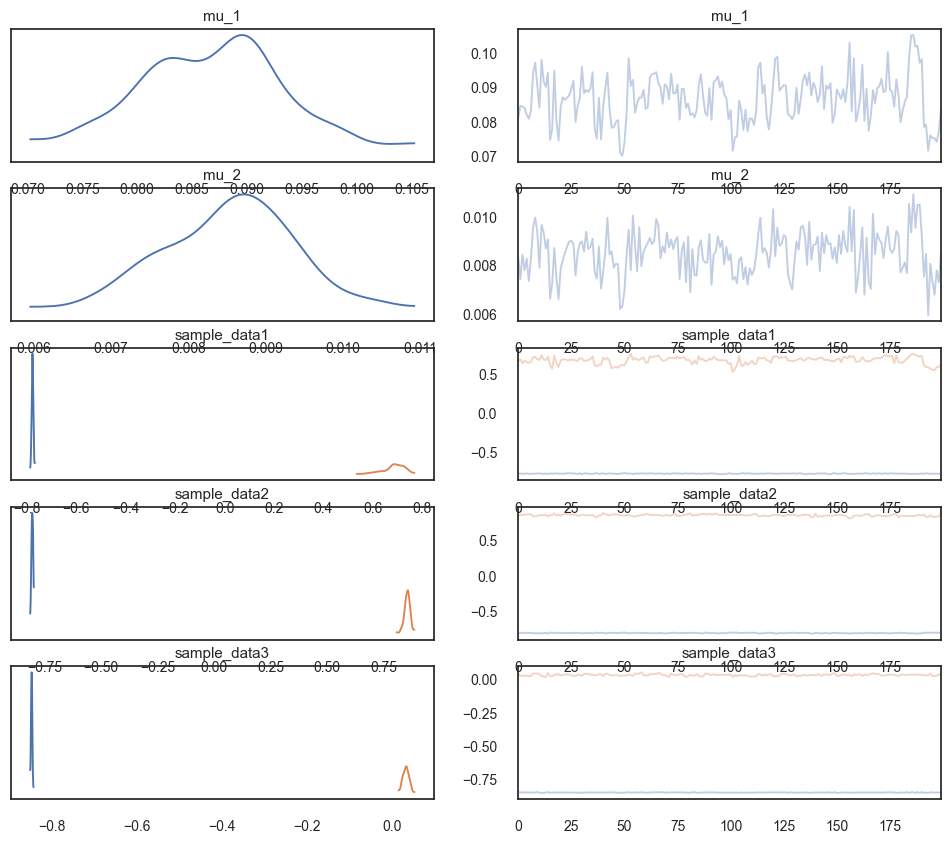

In [105]:
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model_test, posterior_samples)(y_obs_label)
data = az.from_pyro(posterior=mcmc, prior=prior, posterior_predictive=posterior_predictive)
az.plot_trace(data)
plt.show()

In [106]:
posterior_samples

{'mu_1': tensor([0.0811, 0.0847, 0.0846, 0.0841, 0.0821, 0.0810, 0.0832, 0.0942, 0.0973,
         0.0905, 0.0842, 0.0980, 0.0917, 0.0902, 0.0944, 0.0748, 0.0780, 0.0950,
         0.0802, 0.0747, 0.0844, 0.0872, 0.0864, 0.0871, 0.0877, 0.0896, 0.0920,
         0.0801, 0.0847, 0.0869, 0.0961, 0.0884, 0.0893, 0.0888, 0.0897, 0.0944,
         0.0783, 0.0752, 0.0871, 0.0750, 0.0845, 0.0899, 0.0943, 0.0838, 0.0784,
         0.0785, 0.0801, 0.0806, 0.0711, 0.0702, 0.0738, 0.0823, 0.0986, 0.0905,
         0.0922, 0.0828, 0.0854, 0.0871, 0.0871, 0.0894, 0.0838, 0.0844, 0.0929,
         0.0939, 0.0941, 0.0945, 0.0913, 0.0900, 0.0853, 0.0910, 0.0903, 0.0866,
         0.0941, 0.0884, 0.0884, 0.0909, 0.0807, 0.0897, 0.0896, 0.0841, 0.0854,
         0.0820, 0.0826, 0.0814, 0.0834, 0.0906, 0.0939, 0.0878, 0.0828, 0.0818,
         0.0898, 0.0807, 0.0916, 0.0922, 0.0933, 0.0900, 0.0918, 0.0880, 0.0869,
         0.0809, 0.0835, 0.0717, 0.0756, 0.0758, 0.0862, 0.0834, 0.0778, 0.0836,
         0.0773, 0.0

In [107]:
loc_mean_posterior, loc_cov_posterior =[], []
for key, values in posterior_samples.items():
    print(key)
    if key == "sample_data1":
        mean = values.mean(dim=0)
        cov = np.cov(values.detach().numpy(), rowvar=False)
        print("mean\n",mean)
        print("cov\n", cov)
        loc_mean_posterior.append(mean.detach().numpy())
        loc_cov_posterior.append(cov)
    elif key == "sample_data2":
        mean = values.mean(dim=0)
        cov = np.cov(values.detach().numpy(), rowvar=False)
        print("mean\n",mean)
        print("cov\n", cov)
        loc_mean_posterior.append(mean.detach().numpy())
        loc_cov_posterior.append(cov)
    elif key == "sample_data3":
        mean = values.mean(dim=0)
        cov = np.cov(values.detach().numpy(), rowvar=False)
        print("mean\n",mean)
        print("cov\n", cov)
        loc_mean_posterior.append(mean.detach().numpy())
        loc_cov_posterior.append(cov)
    elif key == "sigma_data":
        print("mean\n",values.mean(dim=0), "\nstd\n", values.std(dim=0))
    else:
        print("mean\n",values.mean(), "\nstd\n", values.std())

mu_1
mean
 tensor(0.0868, dtype=torch.float64) 
std
 tensor(0.0068, dtype=torch.float64)
mu_2
mean
 tensor(0.0085, dtype=torch.float64) 
std
 tensor(0.0009, dtype=torch.float64)
sample_data1
mean
 tensor([-0.7770,  0.6838], dtype=torch.float64)
cov
 [[1.12091215e-05 2.03303137e-06]
 [2.03303137e-06 2.02004358e-03]]
sample_data2
mean
 tensor([-0.8044,  0.8556], dtype=torch.float64)
cov
 [[1.36326332e-05 9.52945871e-06]
 [9.52945871e-06 1.57225734e-04]]
sample_data3
mean
 tensor([-0.8483,  0.0331], dtype=torch.float64)
cov
 [[2.18108876e-06 3.64402689e-06]
 [3.64402689e-06 4.61473311e-05]]


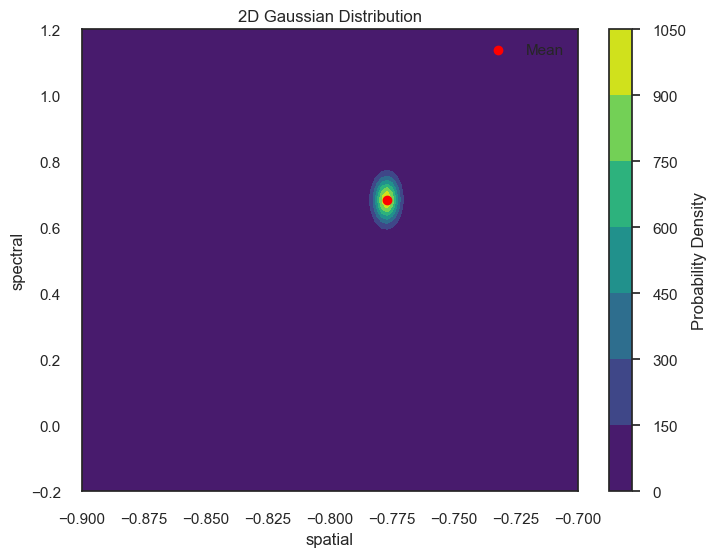

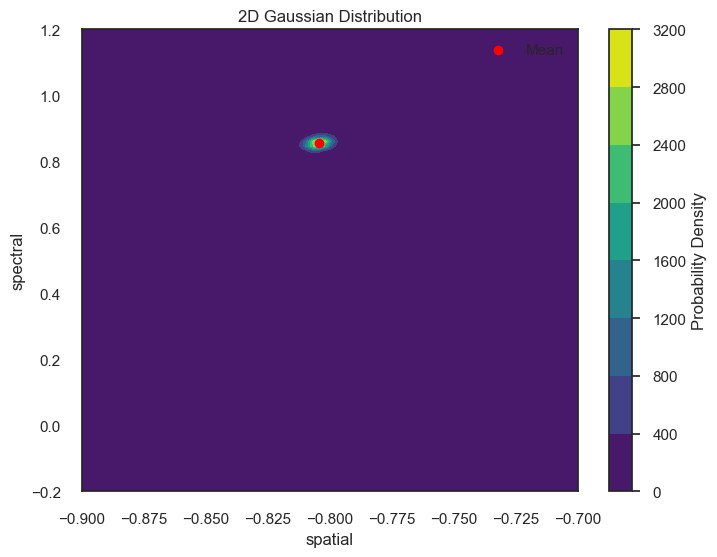

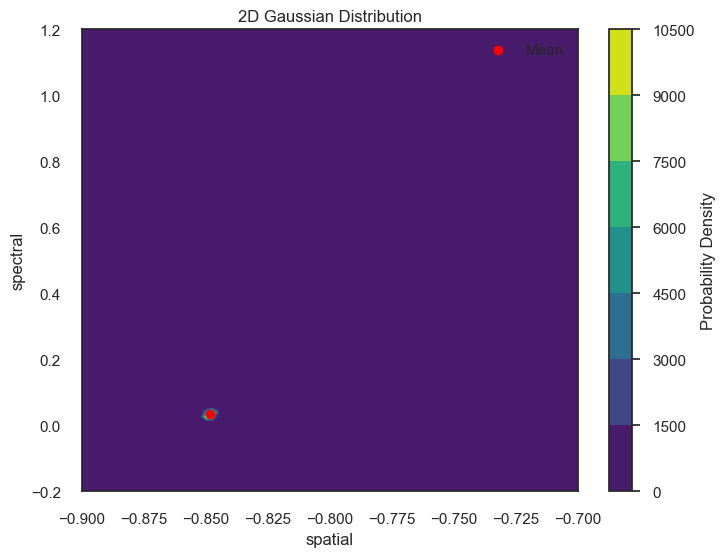

In [108]:
# Create a grid of points
x, y = np.meshgrid(np.linspace(-0.9, -0.7, 100), np.linspace(-0.2, 1.2, 100))
pos = np.dstack((x, y))  # Combine x and y grids into a (100, 100, 2) array
for i in range(3):
    # Create a multivariate normal distribution
    rv = multivariate_normal(loc_mean_posterior[i], loc_cov_posterior[i])

    # Calculate PDF values for each point in the grid
    pdf_values = rv.pdf(pos)

    # Plot the Gaussian distribution using contour plot
    plt.figure(figsize=(8, 6))
    plt.contourf(x, y, pdf_values, cmap='viridis')
    plt.colorbar(label='Probability Density')
    plt.xlabel('spatial')
    plt.ylabel('spectral')
    plt.title('2D Gaussian Distribution')
    plt.scatter(loc_mean_posterior[i][0], loc_mean_posterior[i][1], color='red', label='Mean')
    plt.legend()
    plt.grid(True)
plt.show()

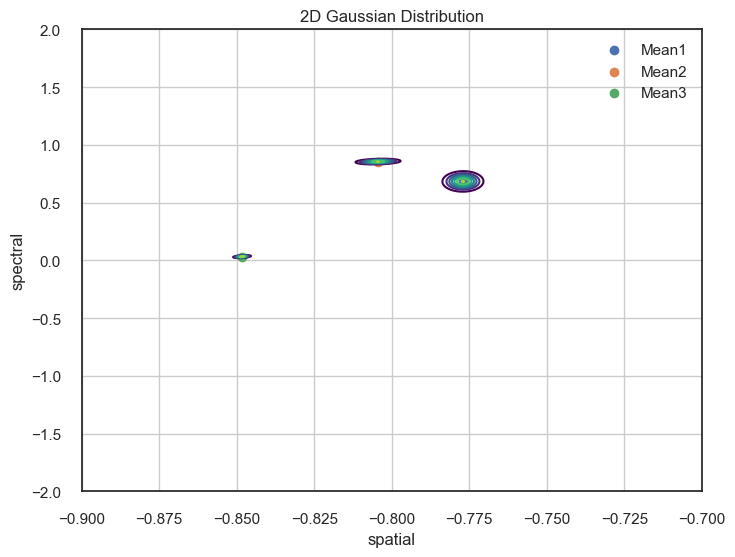

In [109]:
plt.figure(figsize=(8, 6))
# Create a grid of points
x, y = np.meshgrid(np.linspace(-0.9, -0.7, 1000), np.linspace(-2, 2, 1000))
pos = np.dstack((x, y))  # Combine x and y grids into a (100, 100, 2) array
for i in range(3):
    # Calculate distances from the mean for all points in the grid
    #distances = np.sqrt((x - loc_mean_posterior[i][0])**2 + (y - loc_mean_posterior[i][1])**2)
    # Create a multivariate normal distribution
    rv = multivariate_normal(loc_mean_posterior[i], loc_cov_posterior[i])
    # Calculate PDF values for each point in the grid
    pdf_values = rv.pdf(pos)
    
   
    #pdf_values[distances >0.01]=0
    # Plot the Gaussian distribution using contour plot
    plt.contour(x, y, pdf_values, extend='min', cmap='viridis')
    plt.scatter(loc_mean_posterior[i][0], loc_mean_posterior[i][1], label='Mean'+str(i+1))
#plt.colorbar(label='Probability Density')
plt.xlabel('spatial')
plt.ylabel('spectral')
plt.title('2D Gaussian Distribution')

plt.legend()
plt.grid(True)
plt.show()

In [110]:
data.posterior

<xarray.Dataset> Size: 14kB
Dimensions:             (chain: 1, draw: 200, sample_data1_dim_0: 2,
                         sample_data2_dim_0: 2, sample_data3_dim_0: 2)
Coordinates:
  * chain               (chain) int64 8B 0
  * draw                (draw) int64 2kB 0 1 2 3 4 5 ... 194 195 196 197 198 199
  * sample_data1_dim_0  (sample_data1_dim_0) int64 16B 0 1
  * sample_data2_dim_0  (sample_data2_dim_0) int64 16B 0 1
  * sample_data3_dim_0  (sample_data3_dim_0) int64 16B 0 1
Data variables:
    mu_1                (chain, draw) float64 2kB 0.08109 0.08469 ... 0.08361
    mu_2                (chain, draw) float64 2kB 0.008336 0.007425 ... 0.008472
    sample_data1        (chain, draw, sample_data1_dim_0) float64 3kB -0.7738...
    sample_data2        (chain, draw, sample_data2_dim_0) float64 3kB -0.8044...
    sample_data3        (chain, draw, sample_data3_dim_0) float64 3kB -0.8477...
Attributes:
    created_at:                 2024-06-04T14:12:55.643781
    arviz_version:              0.17.0
    inference_library:          pyro
    inference_library_version:  1.9.0

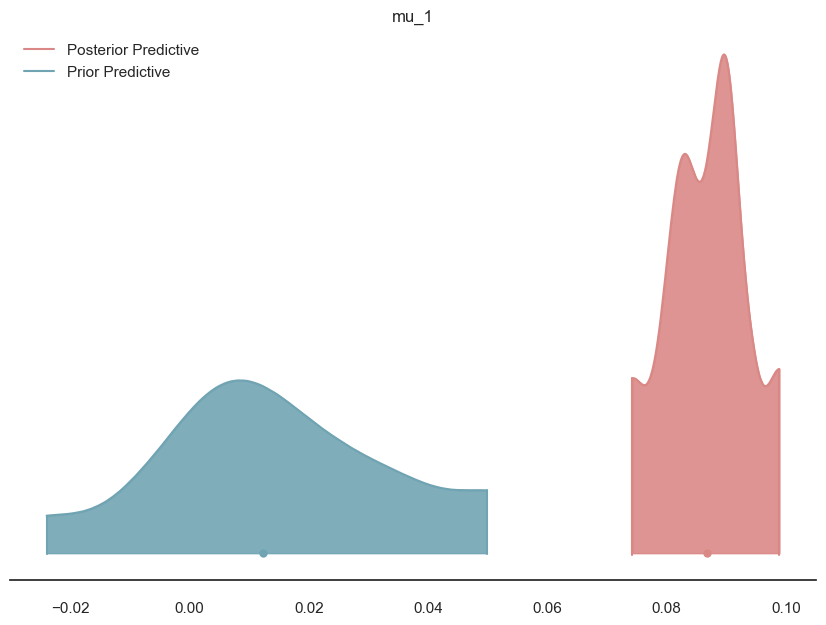

In [111]:
az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_1'],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    colors=[default_red, default_blue],
)
plt.show()

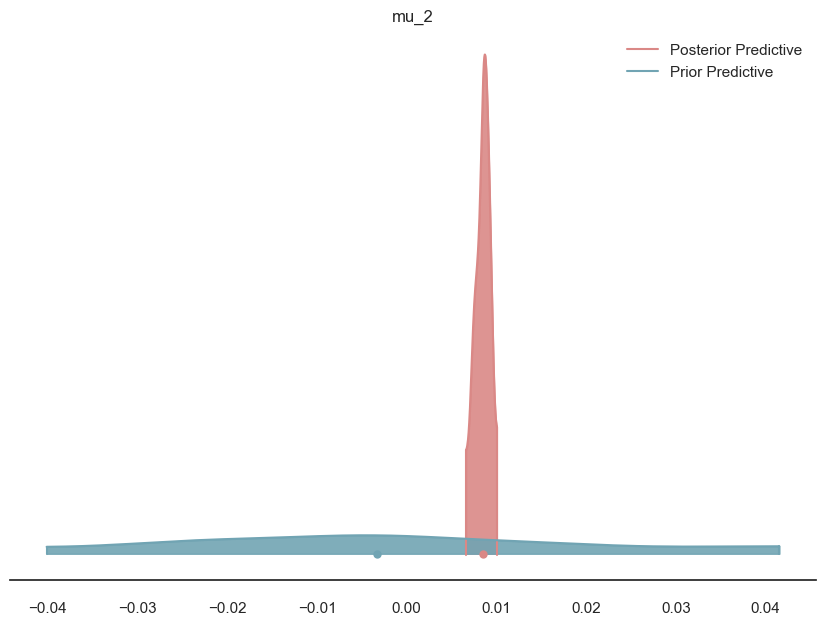

In [112]:
az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_2'],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    colors=[default_red, default_blue],
)
plt.show()

Condition number: 20965.33917600503.


/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


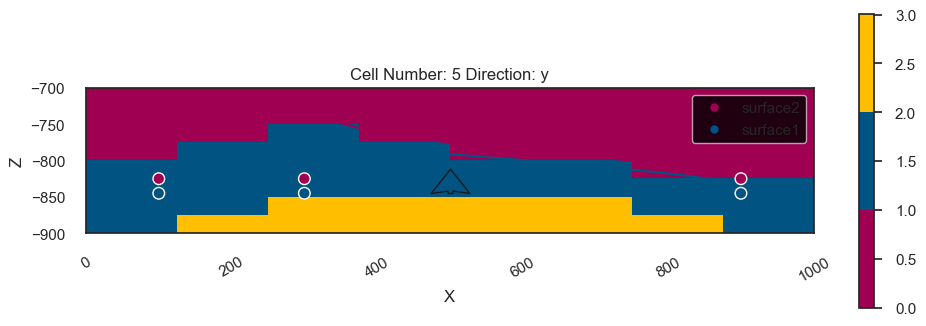

In [113]:
# Update the model with the new top layer's location
interpolation_input = geo_model_test.interpolation_input
interpolation_input.surface_points.sp_coords = torch.index_put(
    interpolation_input.surface_points.sp_coords,
    (torch.tensor([2]), torch.tensor([2])),
    posterior_samples["mu_1"].mean()
)
interpolation_input.surface_points.sp_coords = torch.index_put(
    interpolation_input.surface_points.sp_coords,
    (torch.tensor([5]), torch.tensor([2])),
    posterior_samples["mu_2"].mean()
)

#print("interpolation_input",interpolation_input.surface_points.sp_coords)

# # Compute the geological model
geo_model_test.solutions = gempy_engine.compute_model(
    interpolation_input=interpolation_input,
    options=geo_model_test.interpolation_options,
    data_descriptor=geo_model_test.input_data_descriptor,
    geophysics_input=geo_model_test.geophysics_input,
)

gpv.plot_2d(geo_model_test, cell_number=5,legend='force')

In [114]:
sp_coords_copy_test2 =interpolation_input.surface_points.sp_coords
sp_coords_copy_test2

tensor([[-0.2500,  0.0000,  0.0125],
        [ 0.2500,  0.0000,  0.0125],
        [-0.1250,  0.0000,  0.0868],
        [-0.2500,  0.0000,  0.0000],
        [ 0.2500,  0.0000,  0.0000],
        [-0.1250,  0.0000,  0.0085]], dtype=torch.float64,
       grad_fn=<IndexPutBackward0>)

In [115]:
sp_cord= geo_model_test.transform.apply_inverse(sp_coords_copy_test2.detach().numpy())
sp_cord

array([[ 100.        ,    0.        , -825.        ],
       [ 900.        ,    0.        , -825.        ],
       [ 300.        ,    0.        , -706.05992656],
       [ 100.        ,    0.        , -845.        ],
       [ 900.        ,    0.        , -845.        ],
       [ 300.        ,    0.        , -831.3809195 ]])

In [116]:
#gpv.plot_3d(geo_model_test)

In [117]:
custom_grid_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
custom_grid_values

tensor([3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000,
        3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000,
        3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000,
        3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000,
        3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000,
        3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 2.9999, 2.9999, 2.9999, 2.9999,
        2.9999, 2.9998, 2.9998, 2.9997, 2.9997, 2.9996, 2.9995, 2.9993, 2.9992,
        2.9989, 2.9987, 2.9984, 2.9980, 2.9975, 2.9969, 2.9961, 2.9952, 2.9941,
        2.9927, 2.9911, 2.9890, 2.9866, 2.9836, 2.9800, 2.9757, 2.9706, 2.9644,
        2.9570, 2.9483, 2.9380, 2.9260, 2.9119, 2.8957, 2.8770, 2.8557, 2.8316,
        2.8047, 2.7749, 2.7424, 2.7072, 2.6697, 2.6303, 2.5895, 2.5477, 2.5057,
        2.4639, 2.4230, 2.3835, 2.3457, 2.3102, 2.2770, 2.2464, 2.2183, 2.1928,
        2.1698, 2.1492, 2.1308, 2.1144, 

In [122]:
# # Creating marginal distribution plots
# p = PlotPosterior(data)
# p.create_figure(figsize=(9, 5), joyplot=False, marginal=True, likelihood=False)
# p.plot_marginal(
#     var_names=['mu_1', 'mu_2'],
#     plot_trace=False,
#     credible_interval=.70,
#     kind='kde',
#     marginal_kwargs={"bw": 1}
# )
# plt.show()

In [123]:
# # Visualizing the posterior distributions
# p = PlotPosterior(data)
# p.create_figure(figsize=(9, 6), joyplot=True)
# iteration = 99
# p.plot_posterior(
#     prior_var=['mu_1', 'mu_2'],
#     like_var=['mu_1', 'mu_2'],
#     obs='obs',
#     iteration=iteration,
#     marginal_kwargs={
#         "credible_interval": 0.94,
#         'marginal_kwargs': {"bw": 1},
#         'joint_kwargs': {"bw": 1}
#     }
# )
# plt.show()

In [124]:
# # Creating a pair plot for selected parameters
# az.plot_pair(data, divergences=False, var_names=['mu_1', 'mu_2'])
# plt.show()